In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sb

import datetime
import time
import pandas as pd
import numpy as np
import yahoofinancials as yf
import re
import requests

pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

START = '2000-01-01'
END = (datetime.datetime.utcnow() - 
        datetime.timedelta(days=1)).strftime('%Y-%m-%d')

def load_stock_data(idxs, start='2010-01-01', end='2020-06-01',
                    interval='daily'):
    data = yf.YahooFinancials(idxs)
    data = data.get_historical_price_data(start_date=start, 
                                          end_date=end, 
                                          time_interval=interval)
    df = []
    for col in idxs:
        tmp = pd.DataFrame(data[col]['prices'])
        tmp['stockname'] = col
        try:
            tmp['currency'] = data[col]['currency']
        except:
            tmp['currency'] = ''
        df.append(tmp)
    df = pd.concat(df)
    df['formatted_date'] = pd.to_datetime(df['formatted_date'], 
                                        format='%Y-%m-%d').dt.date
    df.sort_values(['stockname', 'formatted_date'], inplace=True)
    return df

In [17]:
# Load world important indices

windices = pd.read_csv('data/world_indices2.csv', sep=';')
windices = pd.concat([windices, windices['exchangeTimezoneName'].str.extract(
        r'(.+)/(.+)', expand=True)], axis=1).rename({0: 'timezoneContinent',
                                                     1: 'timezoneRegion'}, axis=1)
windices = pd.concat([windices, windices['market'].str.extract(r'(.+)_(.+)',
        expand=False)], axis=1).rename({0: 'marketCountry', 1: 'dummy'}, axis=1)
windices.head()

Symbol                       Name exchange                     shortName  \
0  ^GSPC                    S&P 500      SNP                       S&P 500   
1   ^DJI                     Dow 30      DJI  Dow Jones Industrial Average   
2  ^IXIC                     Nasdaq      NIM              NASDAQ Composite   
3   ^NYA        NYSE COMPOSITE (DJ)      NYS           NYSE COMPOSITE (DJ)   
4   ^XAX  NYSE AMEX COMPOSITE INDEX      NYS     NYSE AMEX COMPOSITE INDEX   

  exchangeTimezoneName exchangeTimezoneShortName  isEsgPopulated  \
0     America/New_York                       EDT           False   
1     America/New_York                       EDT           False   
2     America/New_York                       EDT           False   
3     America/New_York                       EDT           False   
4     America/New_York                       EDT           False   

   gmtOffSetMilliseconds quoteType symbol   messageBoardId     market  \
0              -14400000     INDEX  ^GSPC  finmb_INDEXGSPC  us_market   
1              -14400000     INDEX   ^DJI   finmb_INDEXDJI  us_market   
2              -14400000     INDEX  ^IXIC  finmb_INDEXIXIC  us_market   
3              -14400000     INDEX   ^NYA   finmb_INDEXNYA  us_market   
4              -14400000     INDEX   ^XAX   finmb_INDEXXAX  us_market   

  longName timezoneContinent timezoneRegion marketCountry   dummy  
0      NaN           America       New_York            us  market  
1      NaN           America       New_York            us  market  
2      NaN           America       New_York            us  market  
3      NaN           America       New_York            us  market  
4      NaN           America       New_York            us  market

In [18]:
# download mapping for country codes

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) ' + \
          'AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36'}
page = requests.get('https://www.iban.com/country-codes', headers=header)
countries = pd.read_html(page.text)[0]
countries['iso_a2'] = countries['Alpha-2 code'].str.lower()
cmapping = dict(zip(countries['iso_a2'], countries['Country']))

windices['marketCountry'] = windices['marketCountry'].map(cmapping)

In [20]:
# manually created, how many stocks are listed per index

comp_mapping = {'^IXIC': 2500, '^NYA': 2000, '^XAX': 213, '^VIX': 500, '^GDAXI': 30,
    'IMOEX.ME': 50, '^HSI': 50, '000001.SS': 954, '399001.SZ': 500,
    '^STI': 30, '^AORD': 500, '^BSESN': 30, '^JKSE': 30, '^KLSE': 30,
    '^KS11': 2354, '^TWII': 898, '^GSPTSE': 250, '^BVSP': 60,
    '^MXX': 35, '^IPSA': 40, '^MERV': 20
}

windices['n_components'] = windices['Name'].str.extract(r'(\d+)')
tmp_comp = windices.loc[windices['n_components'].notna(), 
                        ['Symbol', 'n_components']].to_dict(orient='list')
comp_mapping_ext = dict(zip(tmp_comp['Symbol'], pd.to_numeric(tmp_comp['n_components'])))
comp_mapping = {**comp_mapping, **comp_mapping_ext}
windices['n_components'] = windices['Symbol'].map(comp_mapping)

In [21]:
# download historic index data

world_indices = load_stock_data(windices['Symbol'], START, END)
world_indices = world_indices.loc[world_indices['close'].notna(), :]
world_indices['formatted_date'] = pd.to_datetime(world_indices['formatted_date'], 
                                                 format='%Y-%m-%d')
world_indices['year'] = world_indices['formatted_date'].dt.year
world_indices.head()

date         high          low         open        close  volume  \
0  946863000  1366.579956  1366.579956  1366.579956  1366.579956     0.0   
1  946949400  1407.517944  1361.213989  1368.692993  1406.370972     0.0   
2  947035800  1433.780029  1398.322998  1407.828979  1409.682007     0.0   
3  947122200  1463.954956  1400.253052  1406.036011  1463.942017     0.0   
4  947208600  1522.824951  1477.154053  1477.154053  1516.604004     0.0   

      adjclose formatted_date  stockname currency  year  
0  1366.579956     2000-01-03  000001.SS      CNY  2000  
1  1406.370972     2000-01-04  000001.SS      CNY  2000  
2  1409.682007     2000-01-05  000001.SS      CNY  2000  
3  1463.942017     2000-01-06  000001.SS      CNY  2000  
4  1516.604004     2000-01-07  000001.SS      CNY  2000

In [22]:
# join both tables

world_indices = pd.merge(world_indices, windices, 
                         left_on=['stockname'], right_on=['Symbol'])
world_indices['stockname'] = world_indices['stockname'].map(
            dict(zip(windices['Symbol'], windices['Name']))
)
world_indices.head()

date         high          low         open        close  volume  \
0  946863000  1366.579956  1366.579956  1366.579956  1366.579956     0.0   
1  946949400  1407.517944  1361.213989  1368.692993  1406.370972     0.0   
2  947035800  1433.780029  1398.322998  1407.828979  1409.682007     0.0   
3  947122200  1463.954956  1400.253052  1406.036011  1463.942017     0.0   
4  947208600  1522.824951  1477.154053  1477.154053  1516.604004     0.0   

      adjclose formatted_date            stockname currency  year     Symbol  \
0  1366.579956     2000-01-03  SSE Composite Index      CNY  2000  000001.SS   
1  1406.370972     2000-01-04  SSE Composite Index      CNY  2000  000001.SS   
2  1409.682007     2000-01-05  SSE Composite Index      CNY  2000  000001.SS   
3  1463.942017     2000-01-06  SSE Composite Index      CNY  2000  000001.SS   
4  1516.604004     2000-01-07  SSE Composite Index      CNY  2000  000001.SS   

                  Name exchange            shortName exchangeTimezoneName  \
0  SSE Composite Index      SHH  SSE Composite Index        Asia/Shanghai   
1  SSE Composite Index      SHH  SSE Composite Index        Asia/Shanghai   
2  SSE Composite Index      SHH  SSE Composite Index        Asia/Shanghai   
3  SSE Composite Index      SHH  SSE Composite Index        Asia/Shanghai   
4  SSE Composite Index      SHH  SSE Composite Index        Asia/Shanghai   

  exchangeTimezoneShortName  isEsgPopulated  gmtOffSetMilliseconds quoteType  \
0                       CST           False               28800000     INDEX   
1                       CST           False               28800000     INDEX   
2                       CST           False               28800000     INDEX   
3                       CST           False               28800000     INDEX   
4                       CST           False               28800000     INDEX   

      symbol        messageBoardId     market             longName  \
0  000001.SS  finmb_INDEX000001.SS  cn_market  SSE Composite Index   
1  000001.SS  finmb_INDEX000001.SS  cn_market  SSE Composite Index   
2  000001.SS  finmb_INDEX000001.SS  cn_market  SSE Composite Index   
3  000001.SS  finmb_INDEX000001.SS  cn_market  SSE Composite Index   
4  000001.SS  finmb_INDEX000001.SS  cn_market  SSE Composite Index   

  timezoneContinent timezoneRegion marketCountry   dummy  n_components  
0              Asia       Shanghai         China  market           954  
1              Asia       Shanghai         China  market           954  
2              Asia       Shanghai         China  market           954  
3              Asia       Shanghai         China  market           954  
4              Asia       Shanghai         China  market           954

In [23]:
# crashes can be enhanced by incorporating data from:
# https://en.wikipedia.org/wiki/List_of_stock_market_crashes_and_bear_markets
# https://en.wikipedia.org/wiki/VIX

def event_plot(df, col, filename=None):
    df_copy = df.loc[df['stockname']==col, :]
    df_sort = df_copy.sort_values('close')
    lows = df_sort.head(25)
    highs = df_sort.tail(25)

    fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True,
                                   gridspec_kw={'height_ratios': [5, 1]},
                                   tight_layout=True)
    # plot time series
    axs[0].plot(df_copy['formatted_date'],
               df_copy['close'],
                label='{} - {}'.format(col, np.unique(df_copy['n_components'])[0]))
    
    # approximate dates for crashes
    for crashs in (('2000-03-01', '2000-12-31'), # Dotcom bubble
                   ('2001-09-01', '2001-12-31'), # World Trade Center
                   ('2007-08-01', '2009-12-31'), # Financial Crisis
                   ('2020-01-01', '2020-06-30') # Corona
                  ):
        start = mdates.datestr2num(crashs[0])
        end = mdates.datestr2num(crashs[1])
        width = end - start
        max_height = highs['close'].max()*1.1

        rectl = Rectangle((start, 0), width, max_height, linewidth=1, 
                         edgecolor='r', facecolor='#EEEEEE')
        axs[0].add_patch(rectl)
        rectl2 = Rectangle((start, 0), width, 1, linewidth=1, 
                     edgecolor='r', facecolor='#EEEEEE')
        axs[1].add_patch(rectl2)
        
    # mark highs/lows of time series
    axs[1].eventplot(highs['formatted_date'], lineoffsets=[0.75], 
                     linelengths=0.4, linewidths=1,
                     orientation='horizontal', color='green', 
                     alpha=0.5)
    axs[1].eventplot(lows['formatted_date'], lineoffsets=[0.75], 
                 linelengths=0.4, linewidths=1,
                 orientation='horizontal', color='red', 
                 alpha=0.5)
    
    axs[0].set_xlim([df[df['stockname']==col]['formatted_date'].min(), 
                     df[df['stockname']==col]['formatted_date'].max()])
    axs[0].set_ylim([0,max_height])
    axs[1].set_ylim([0.5,1])
    axs[0].grid()
    axs[0].legend(loc='upper left')

    axs[1].set_xlabel('Time')
    axs[0].set_ylabel('Points')
    axs[0].set_title('{} - {} - {} - {}'.format(col, 
                               np.unique(df_copy.timezoneContinent)[0],
                               np.unique(df_copy.marketCountry)[0], 
                               np.unique(df_copy.timezoneRegion)[0]))
    axs[1].set_ylabel('Event')
    axs[1].tick_params(labelleft=False)
    axs[1].grid()
    if filename is not None:
        title = re.sub('[^0-9a-zA-Z]+', '_', filename)
        plt.savefig('indices/{}.png'.format(title), dpi=150, format='png',
            bbox_inches='tight')
    plt.show()

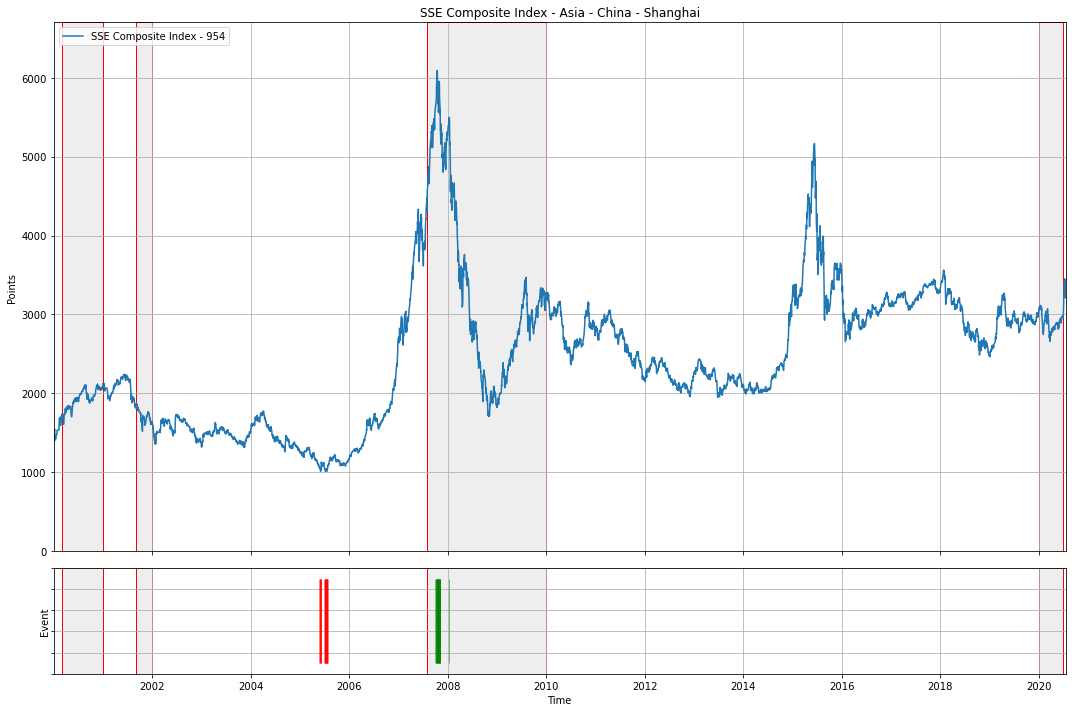

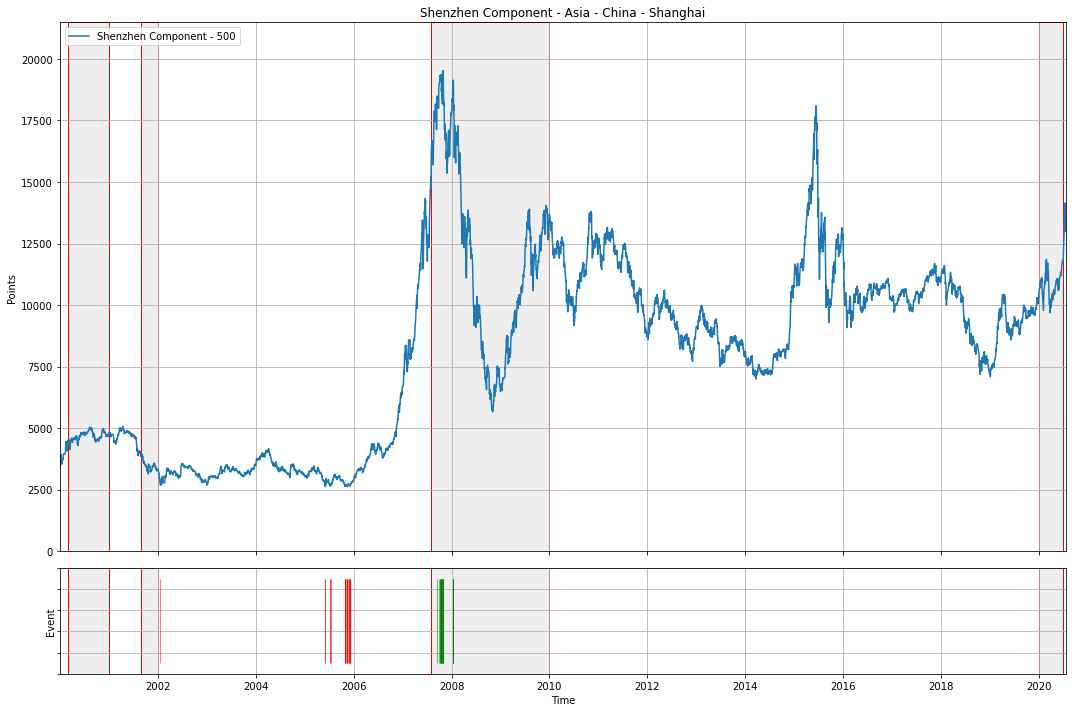

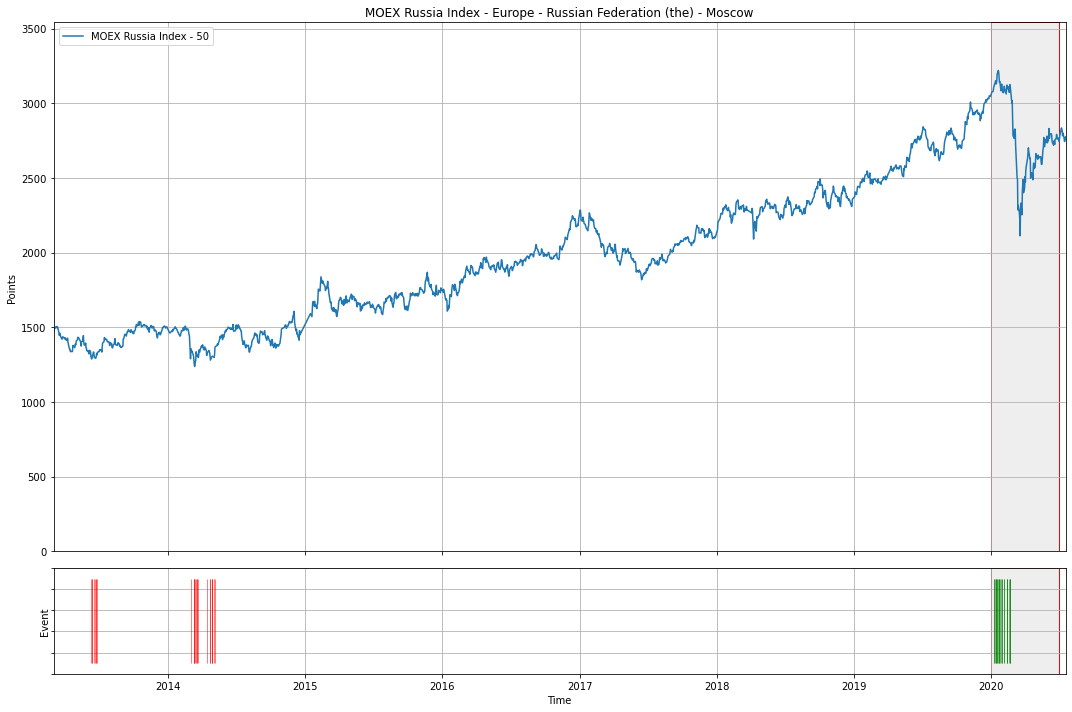

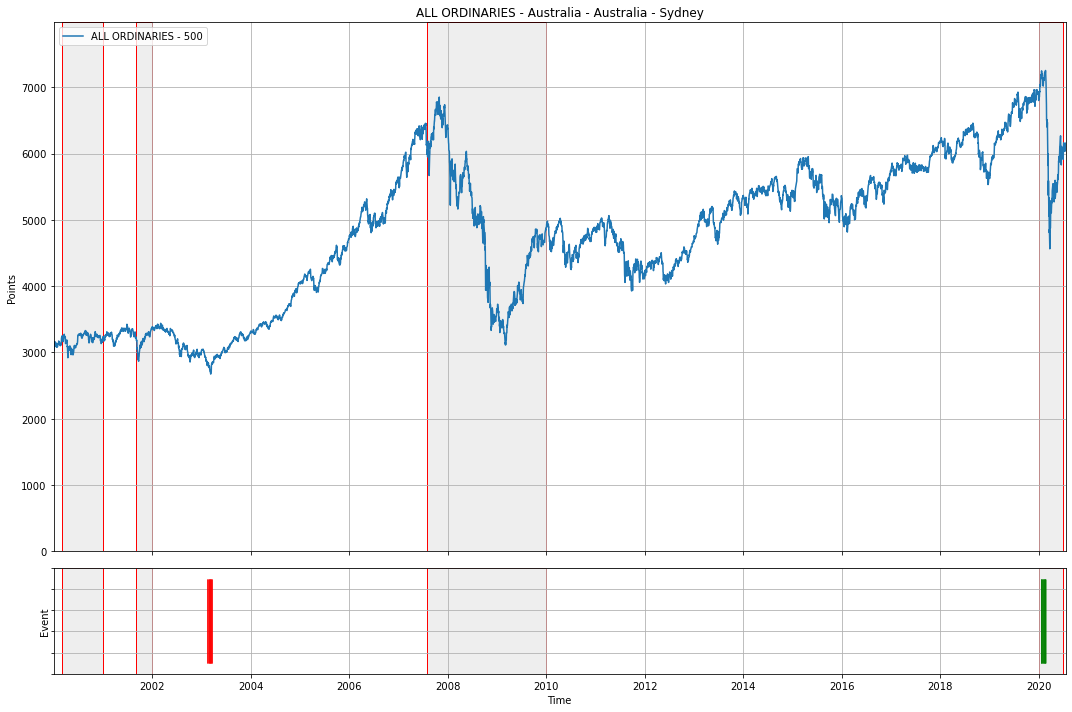

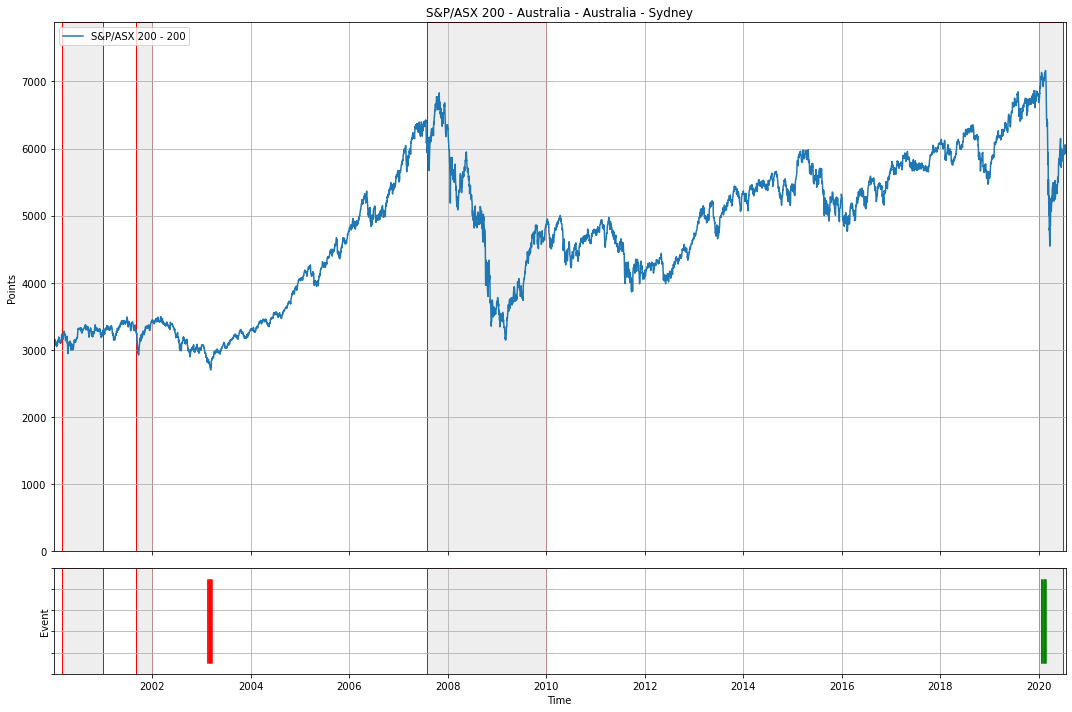

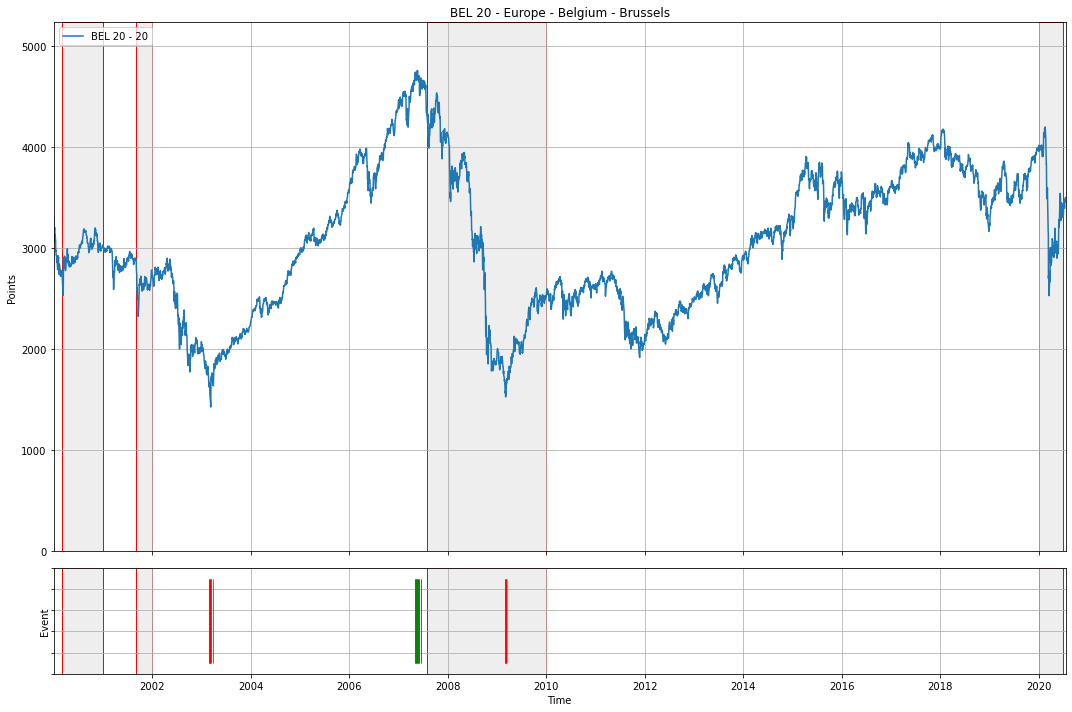

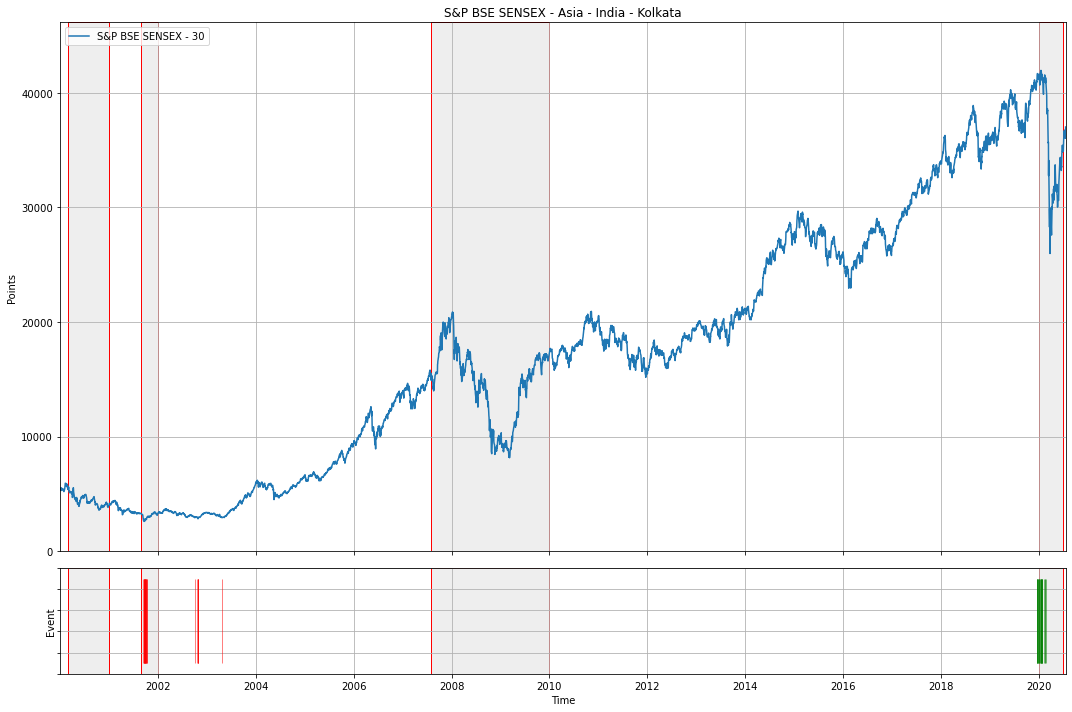

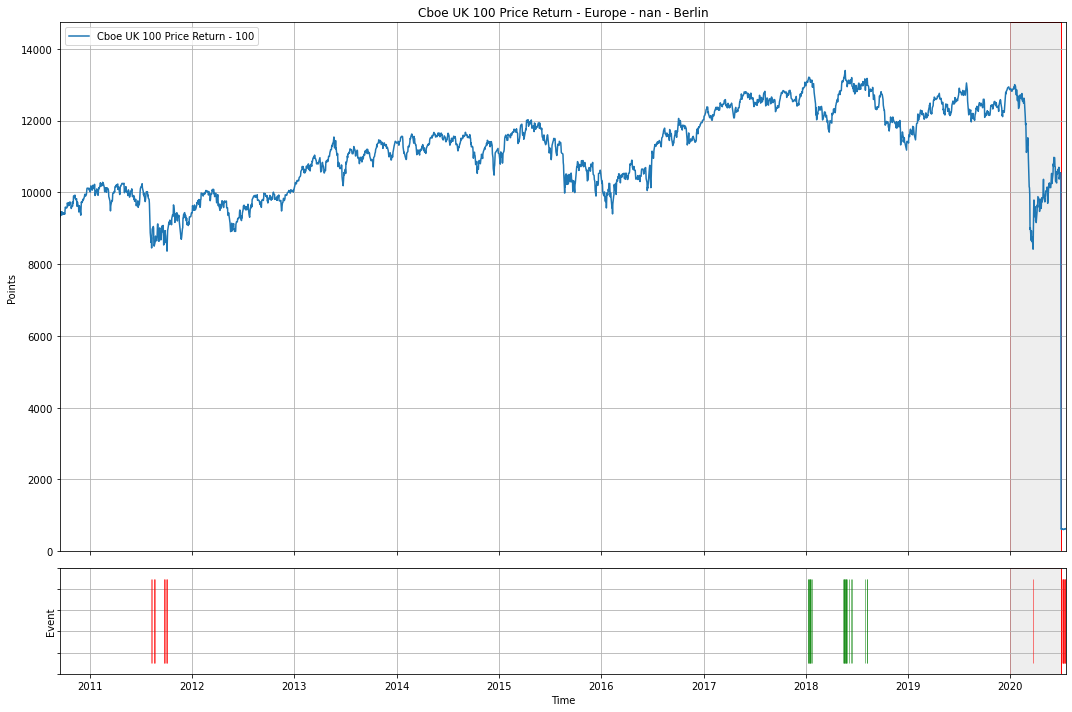

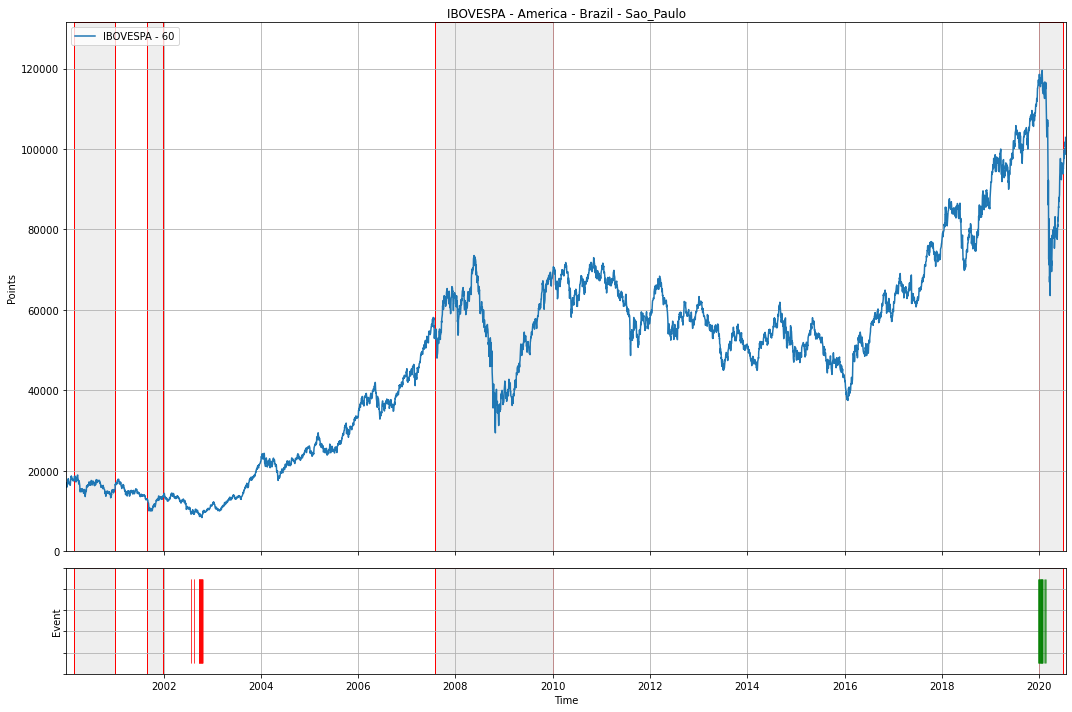

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Attempting to set identical left == right == 737625.0 results in singular transformations; automatically expanding.


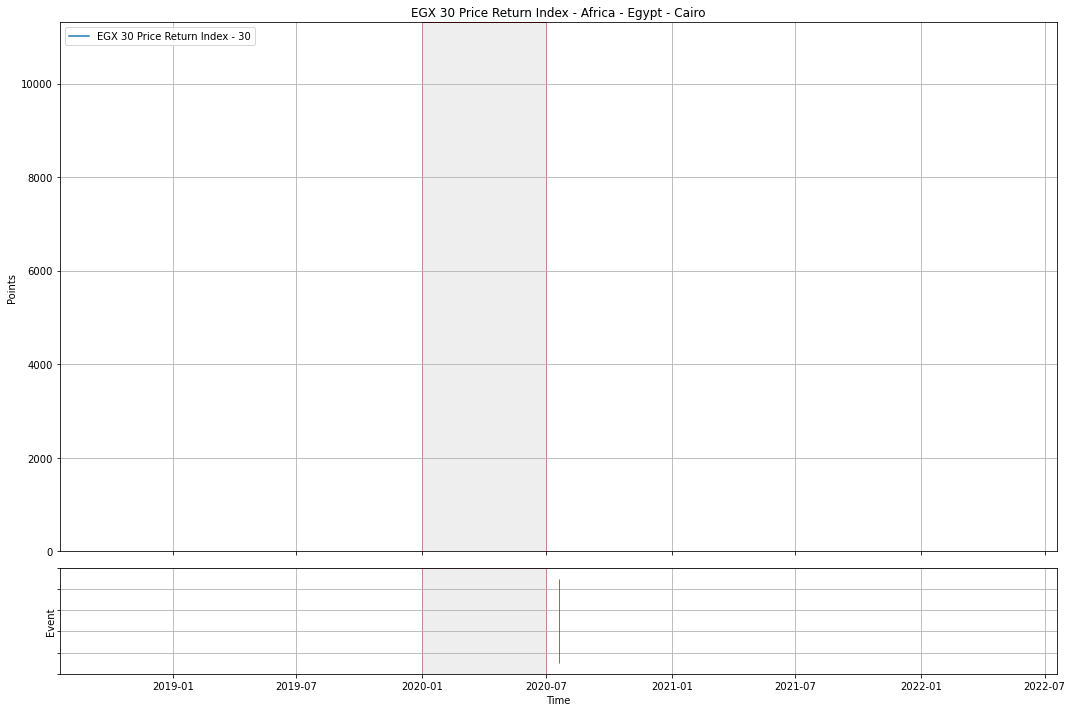

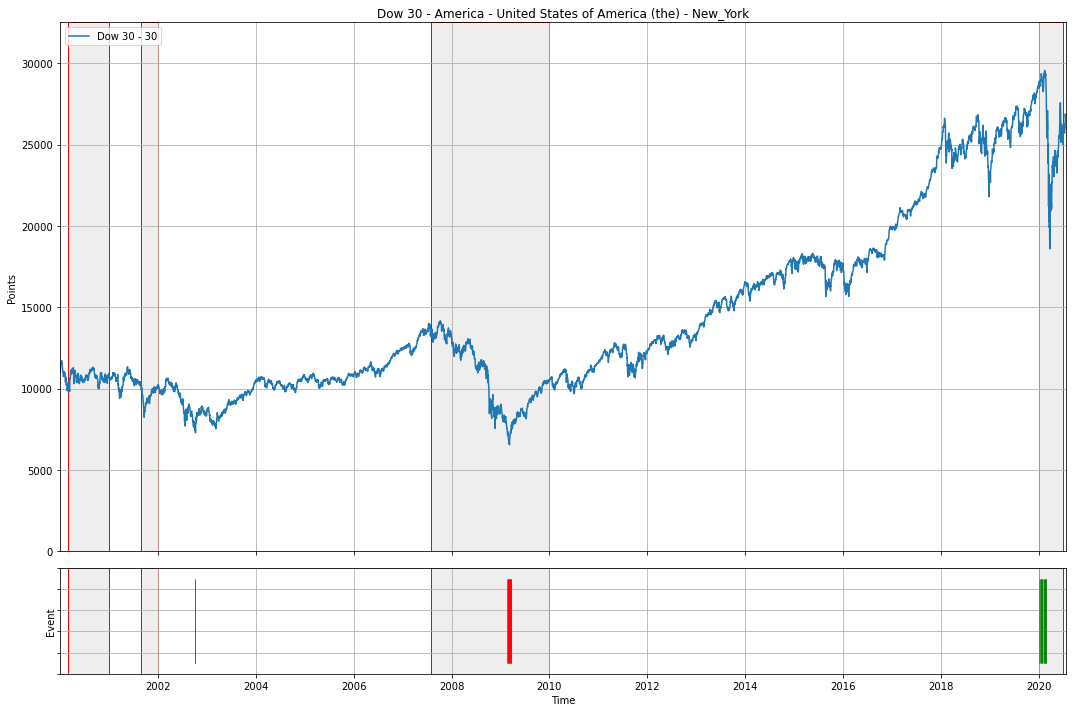

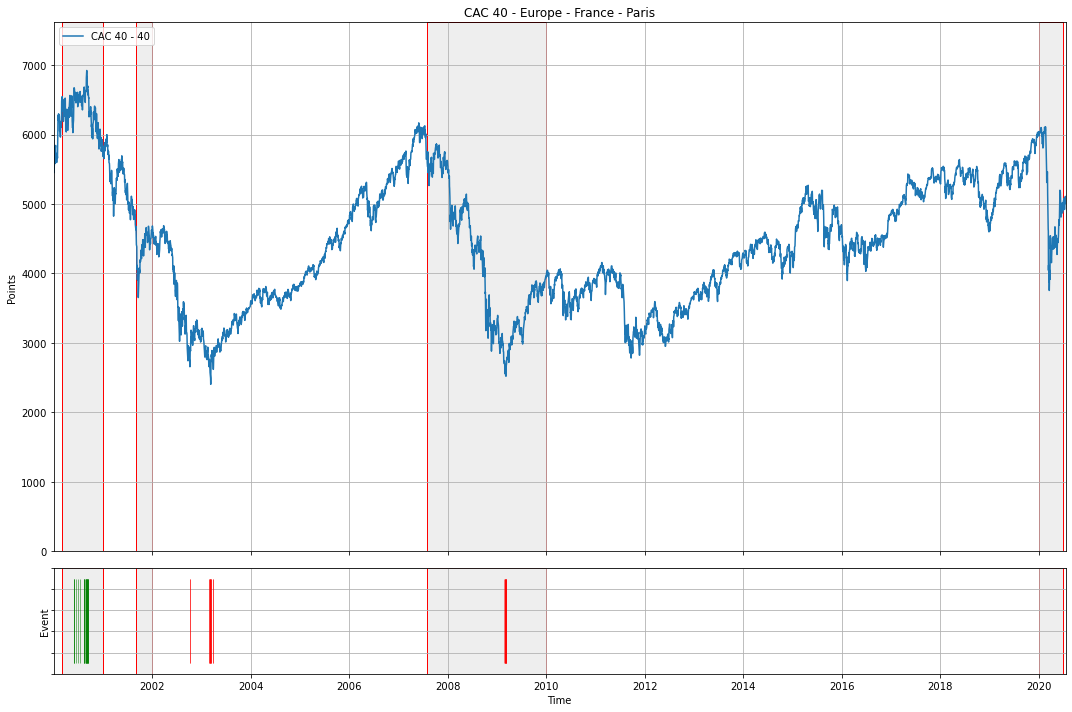

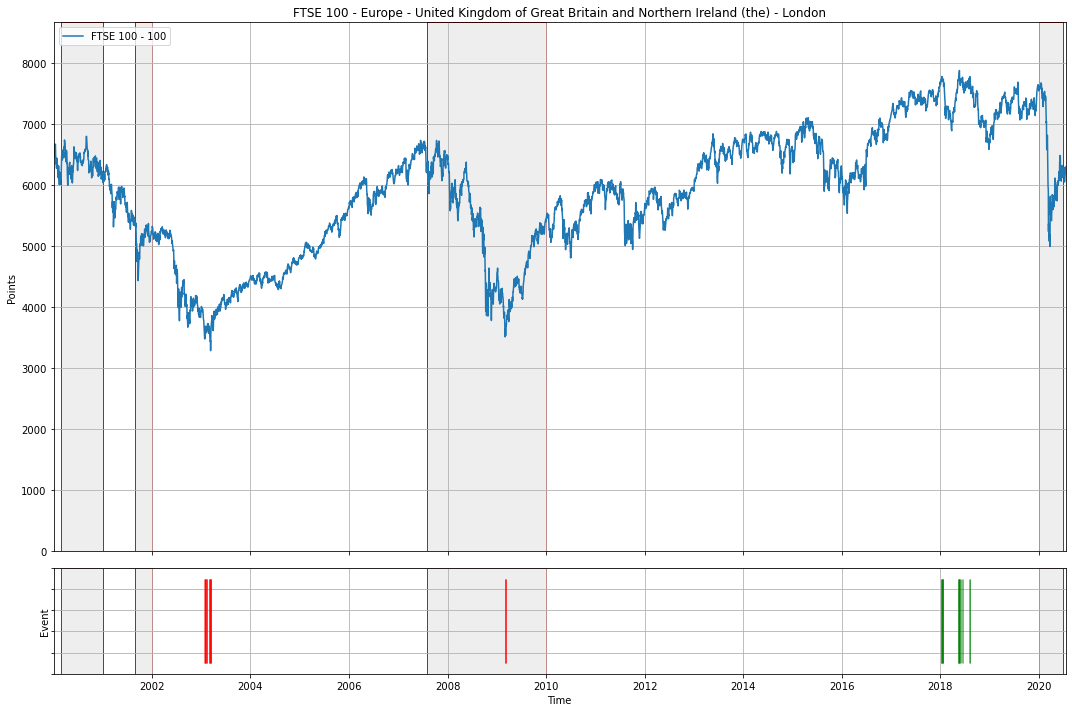

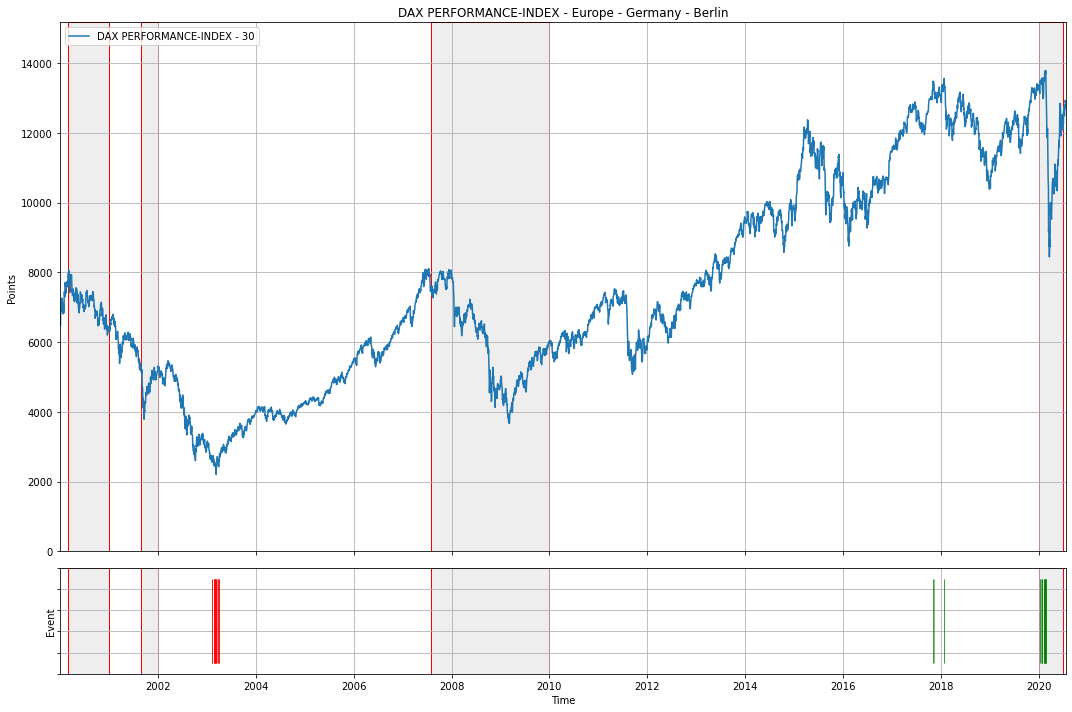

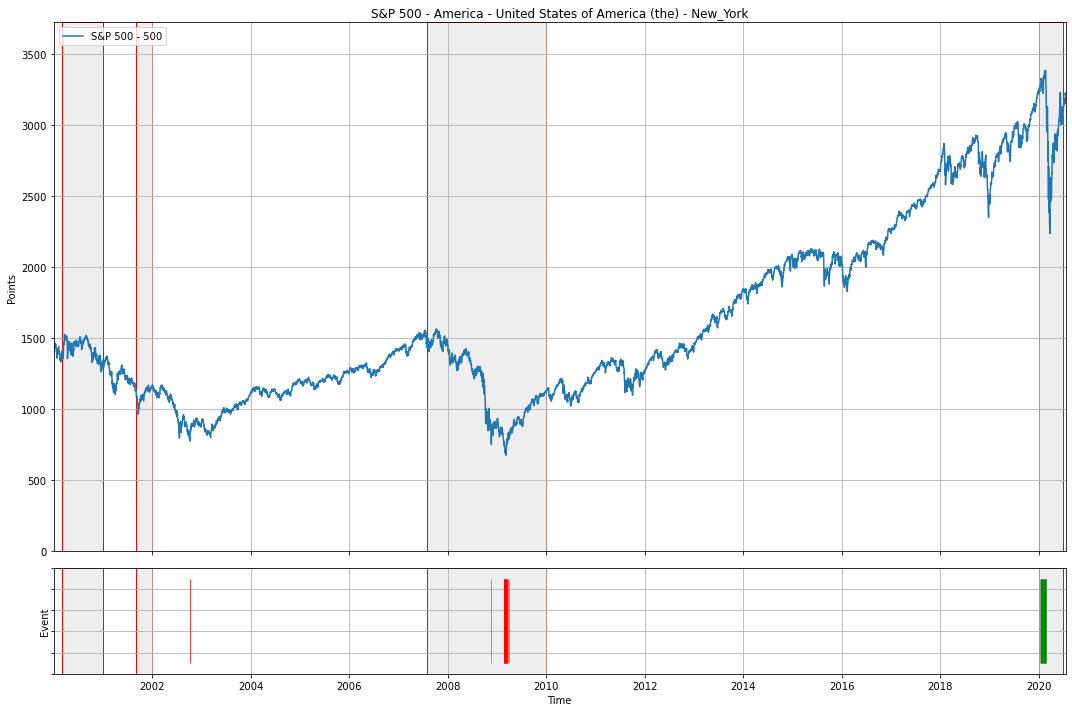

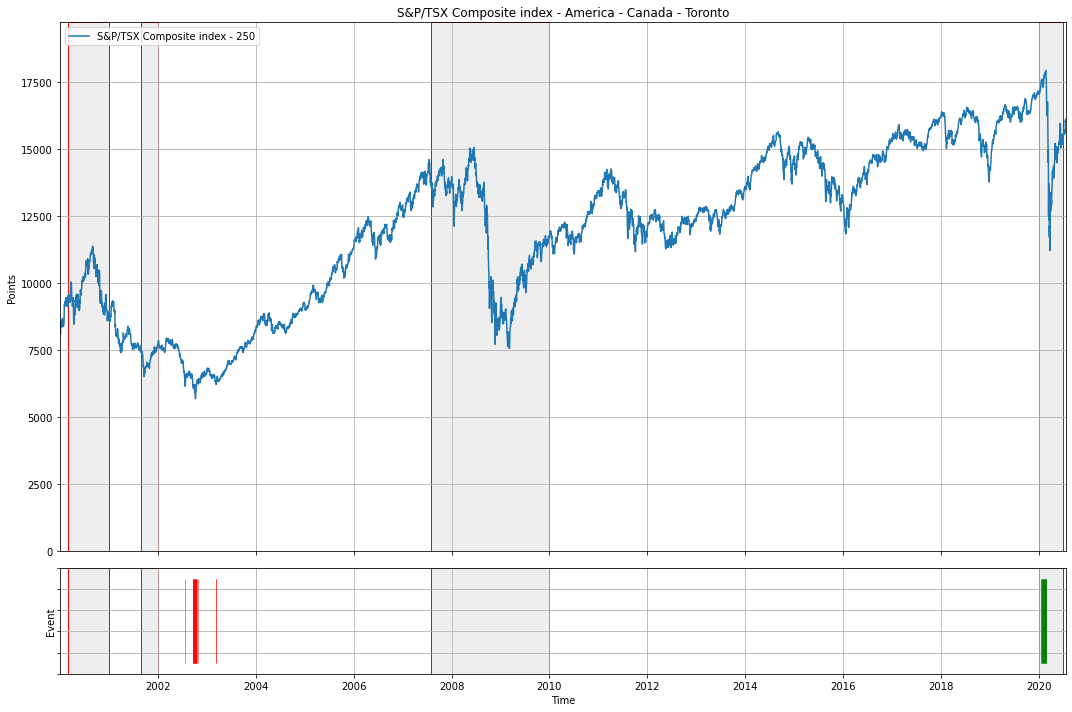

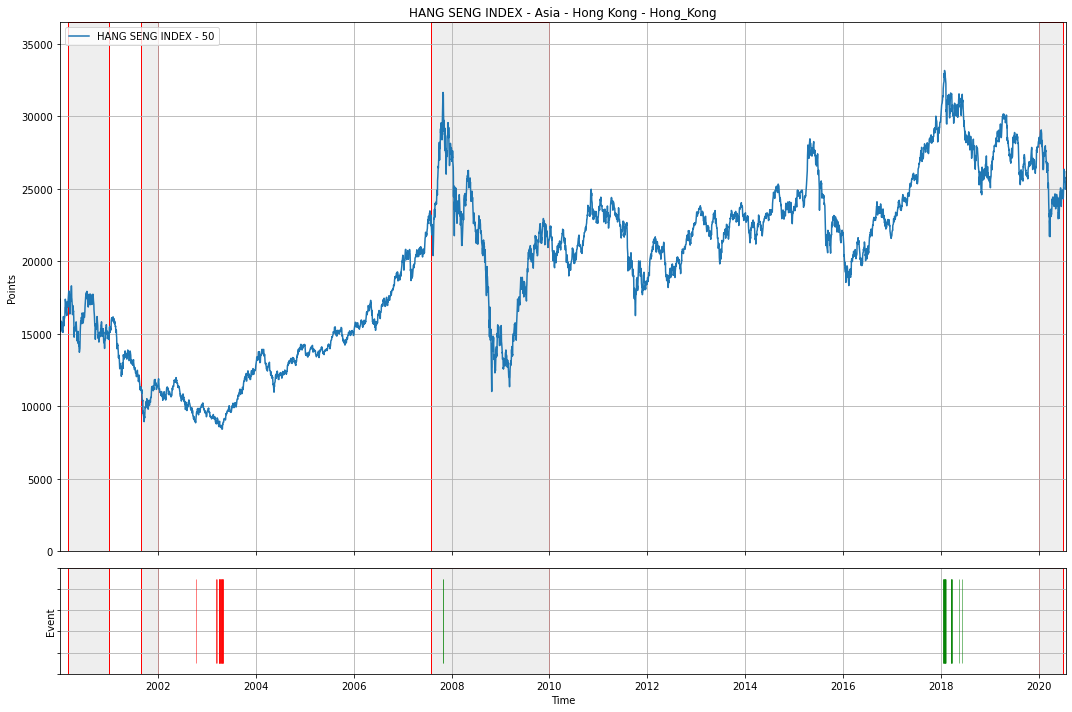

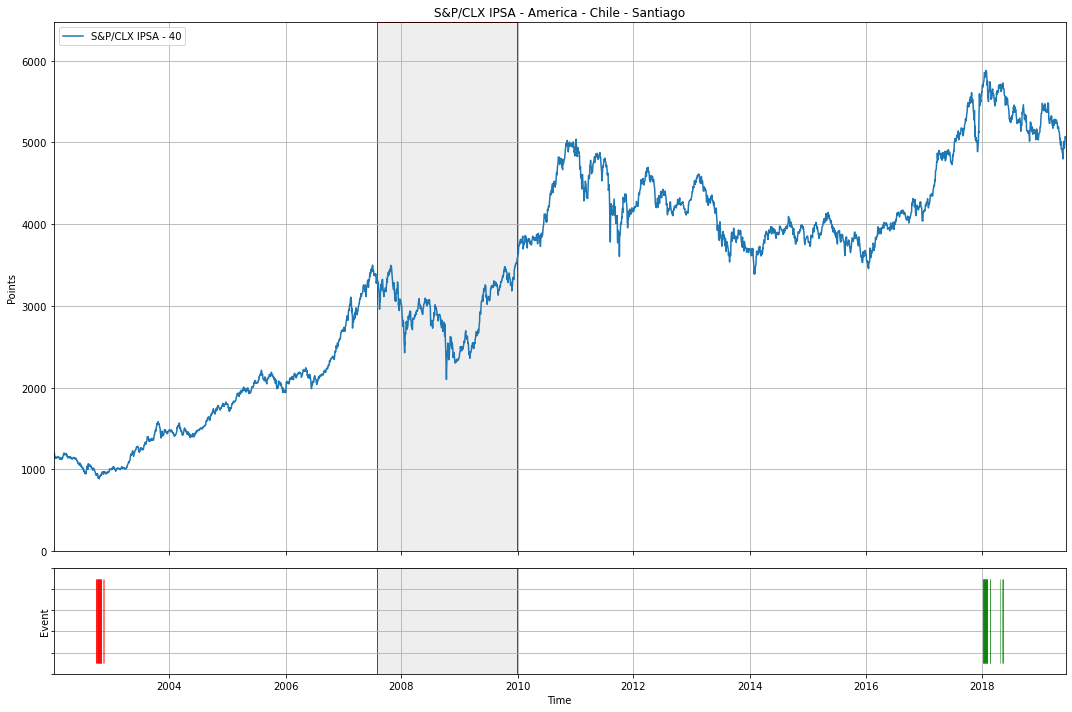

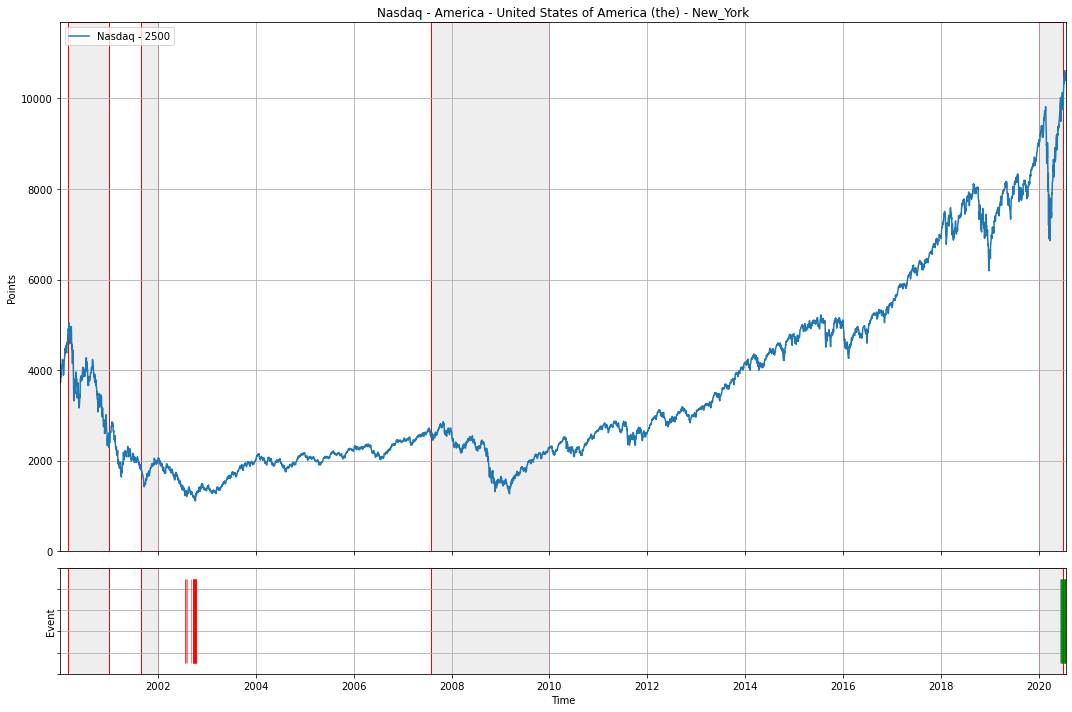

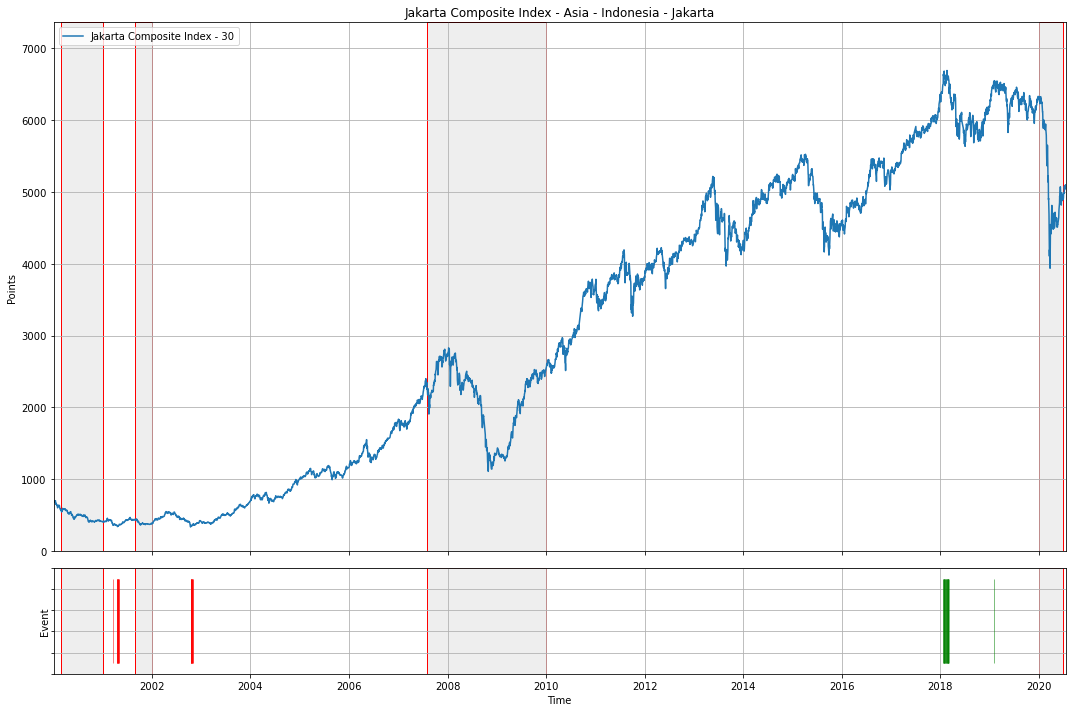

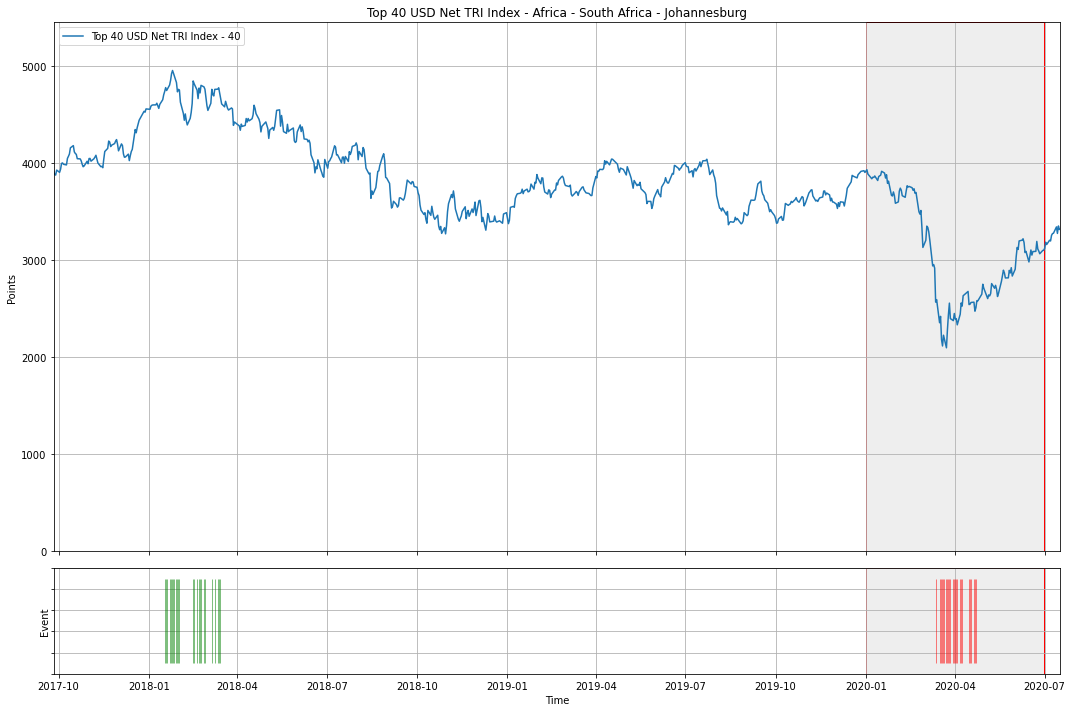

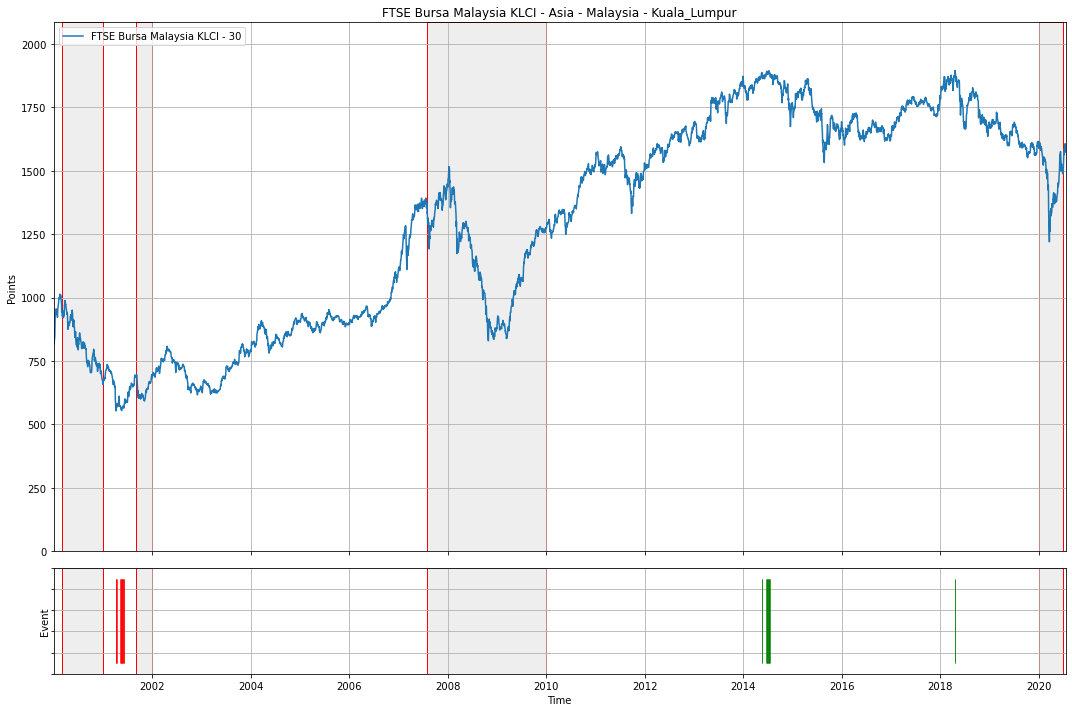

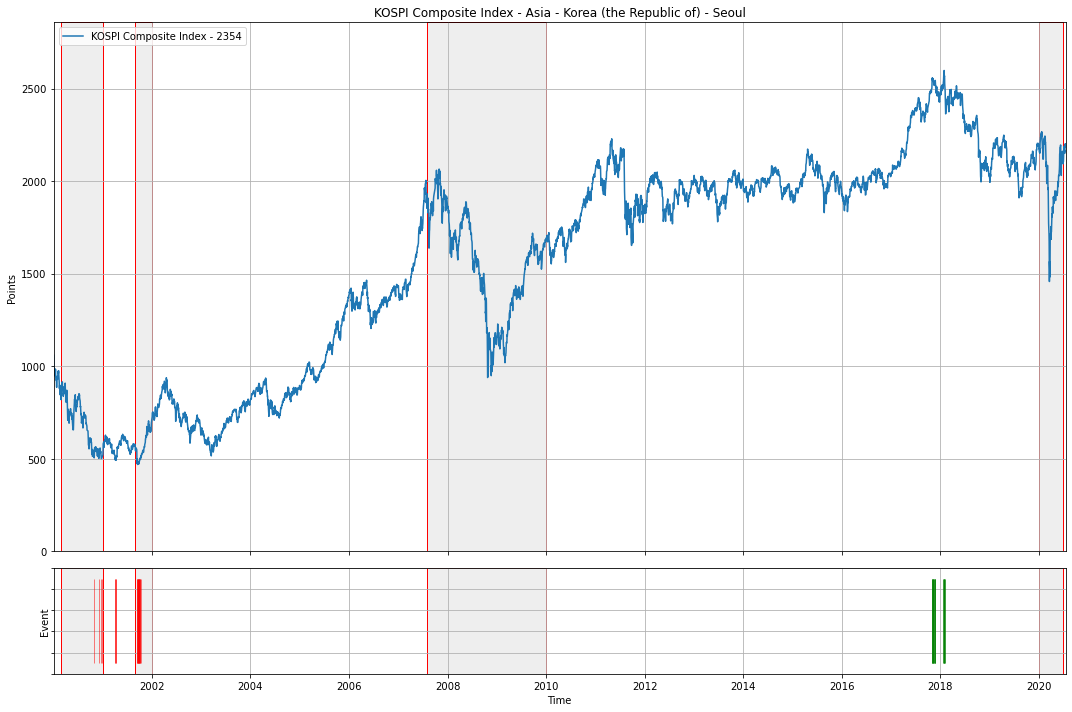

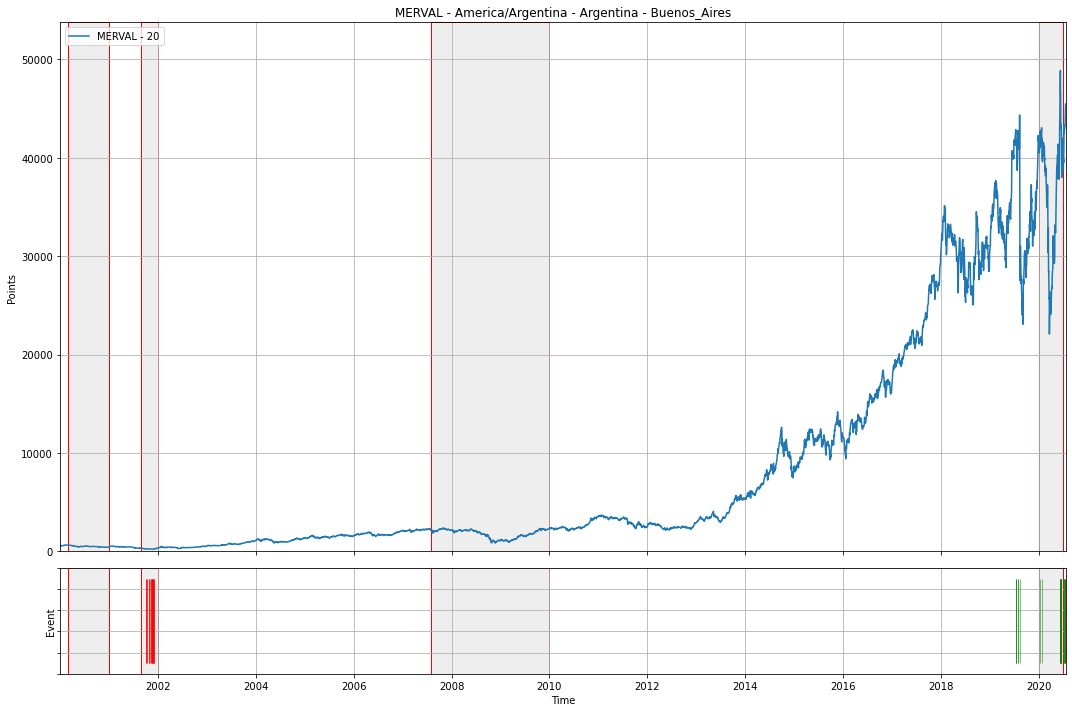

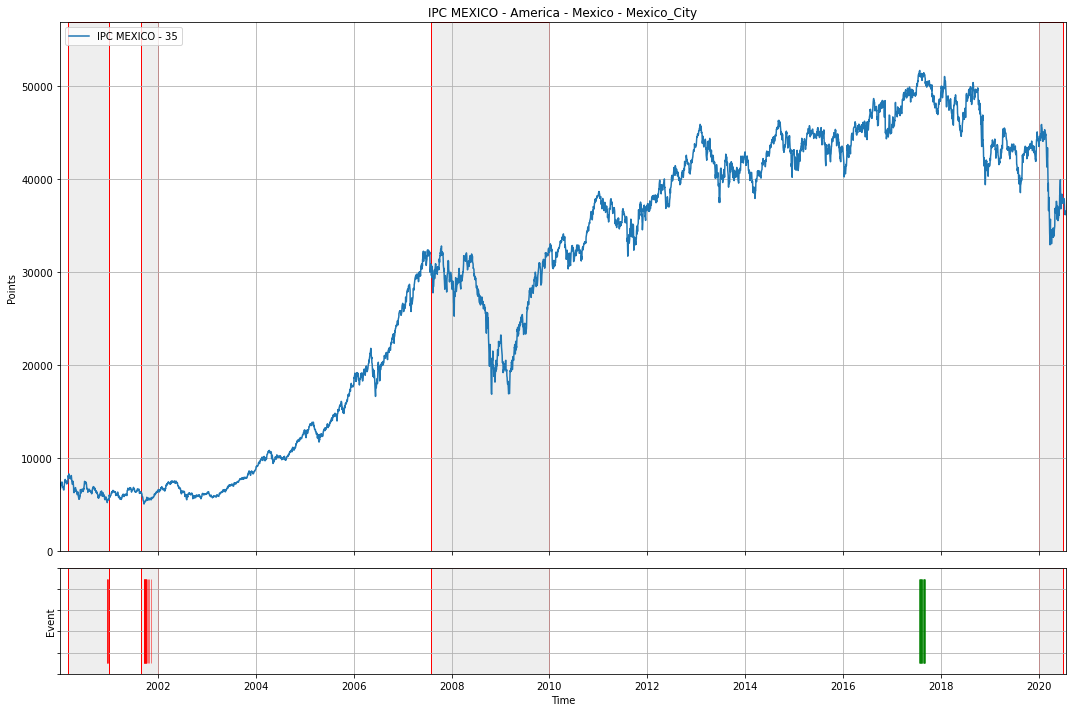

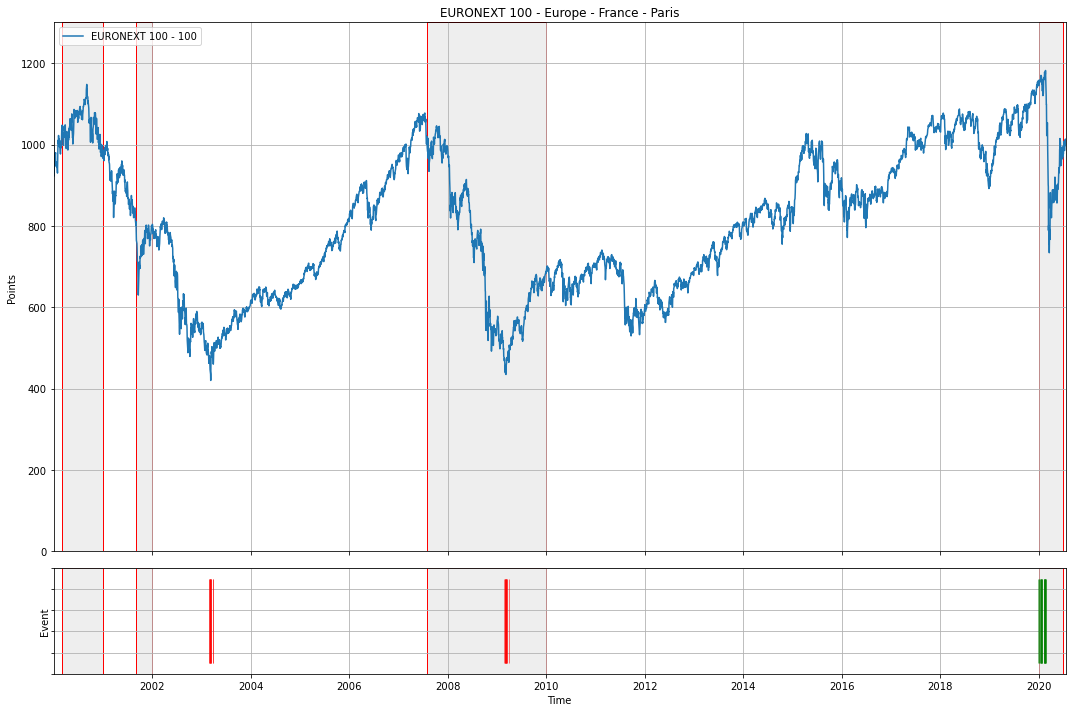

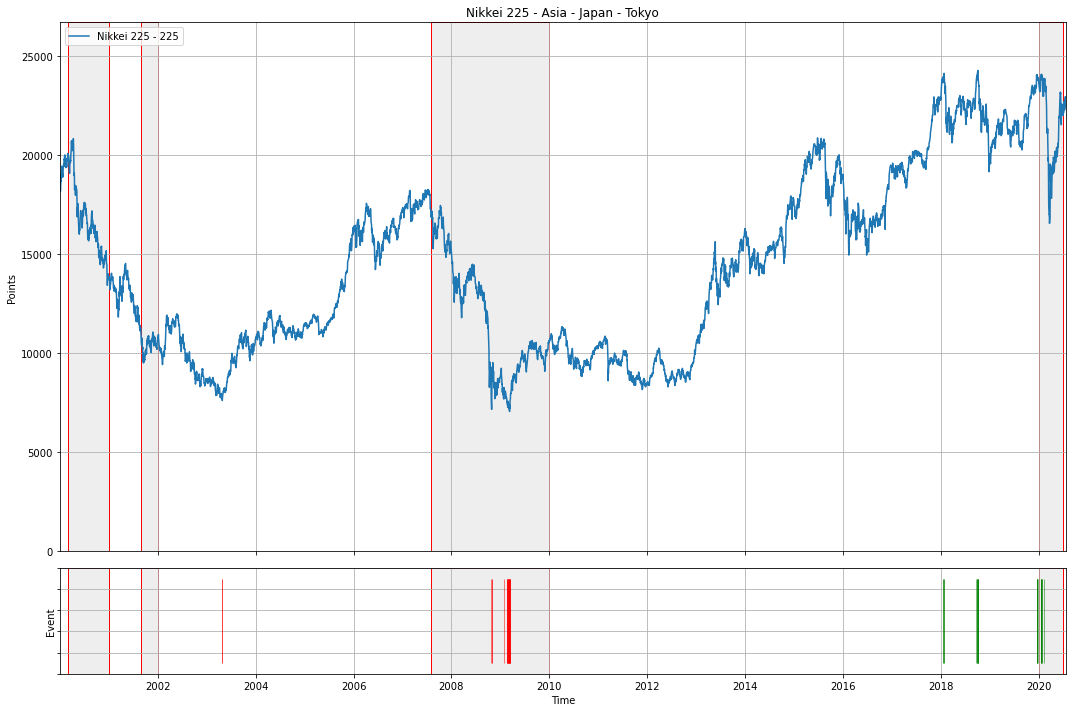

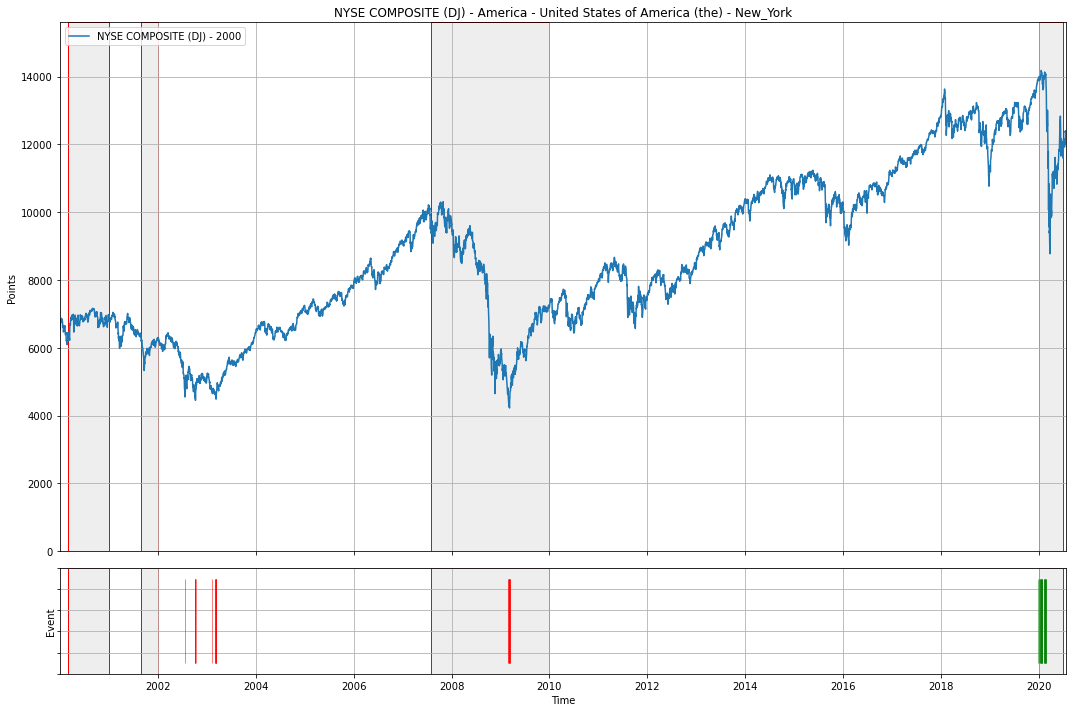

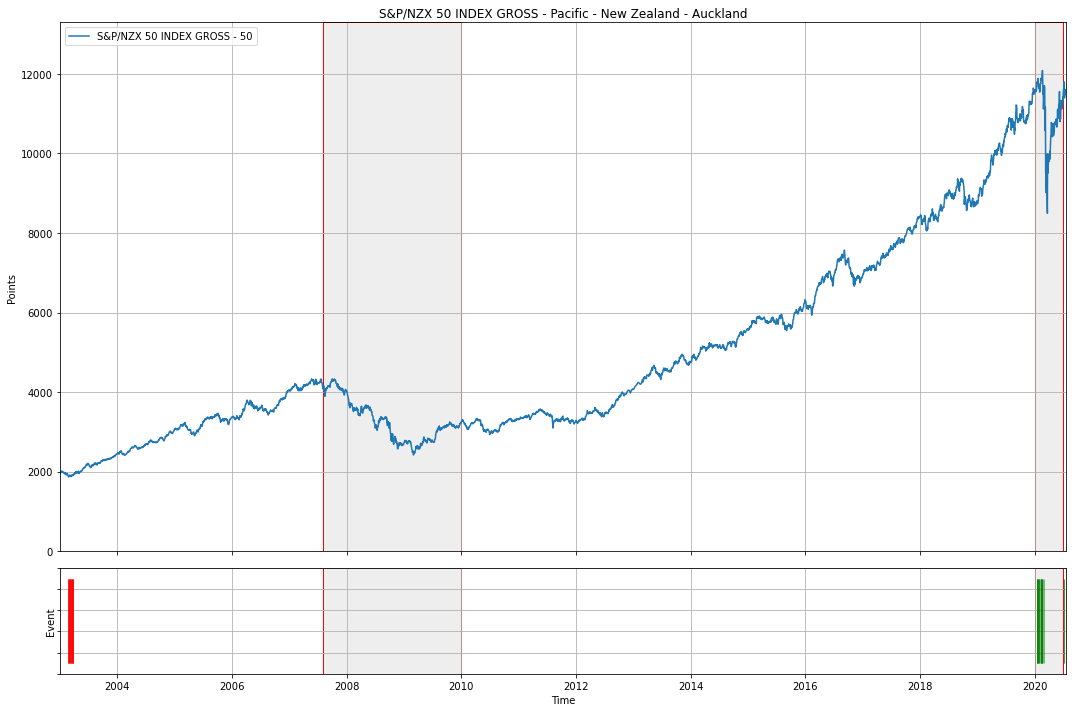

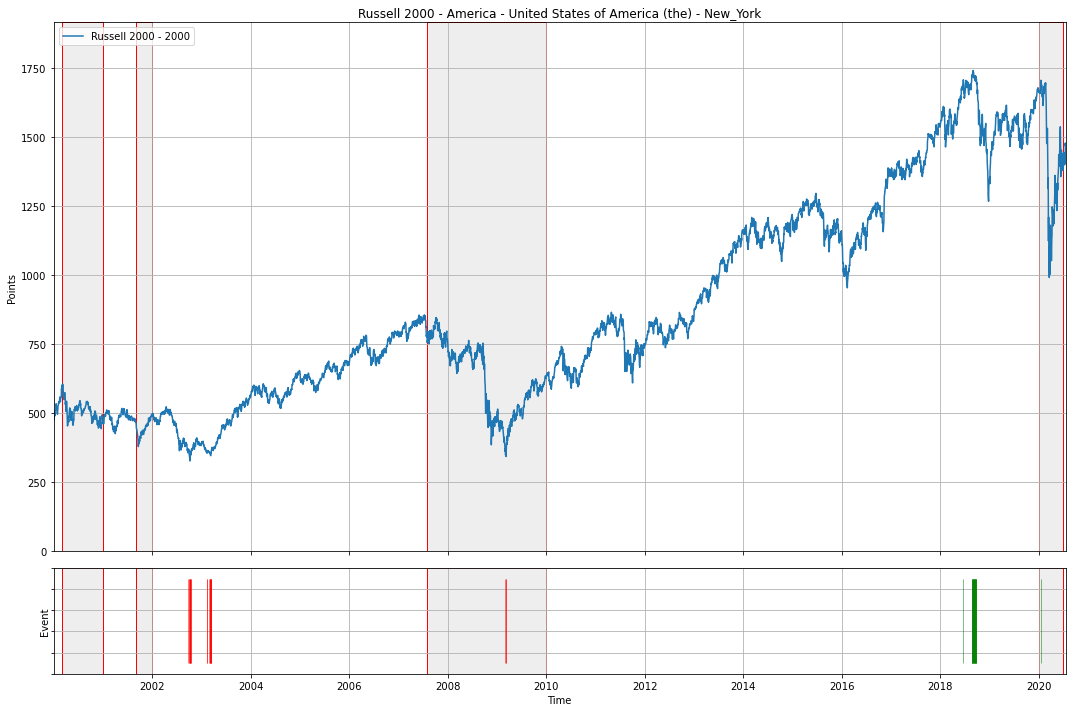

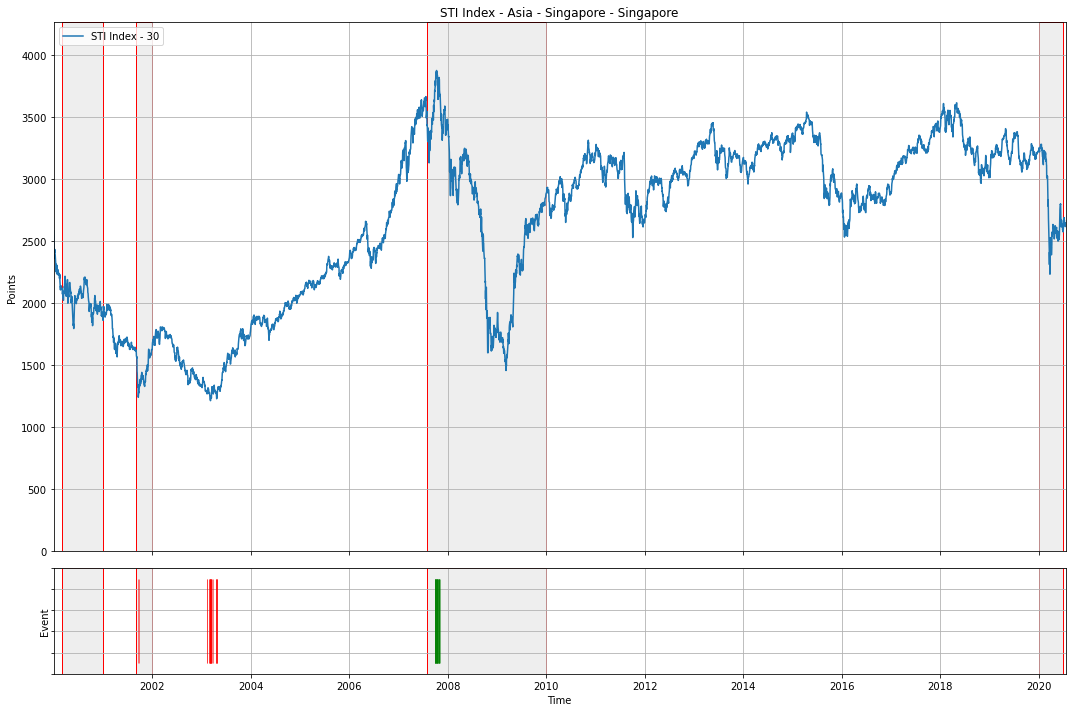

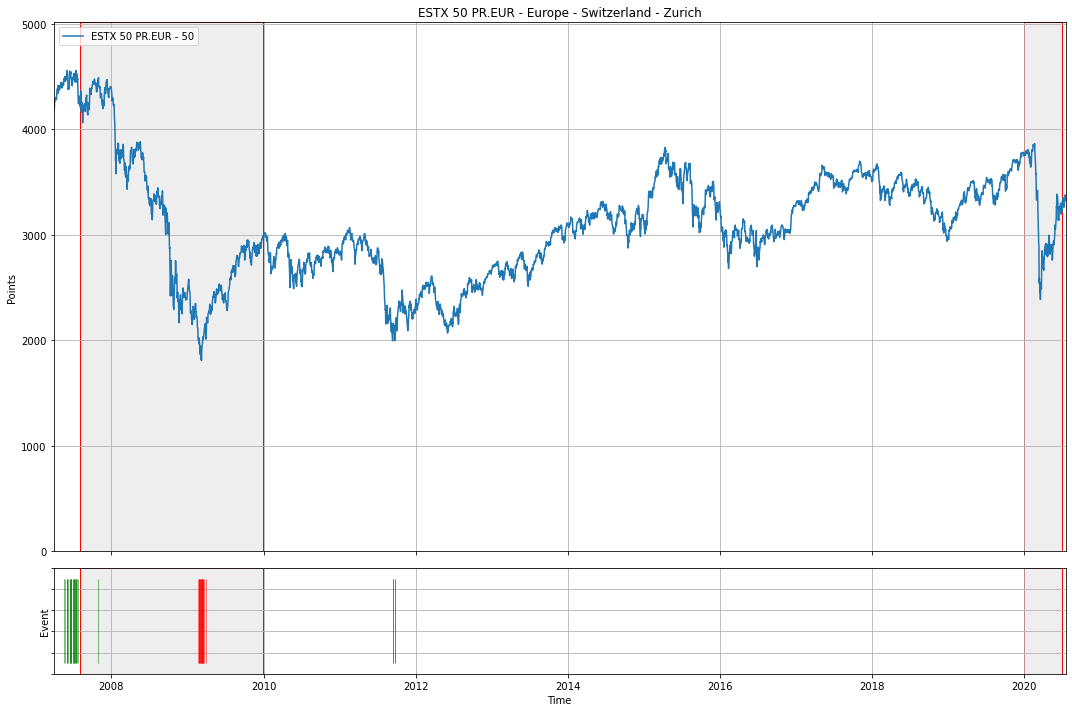

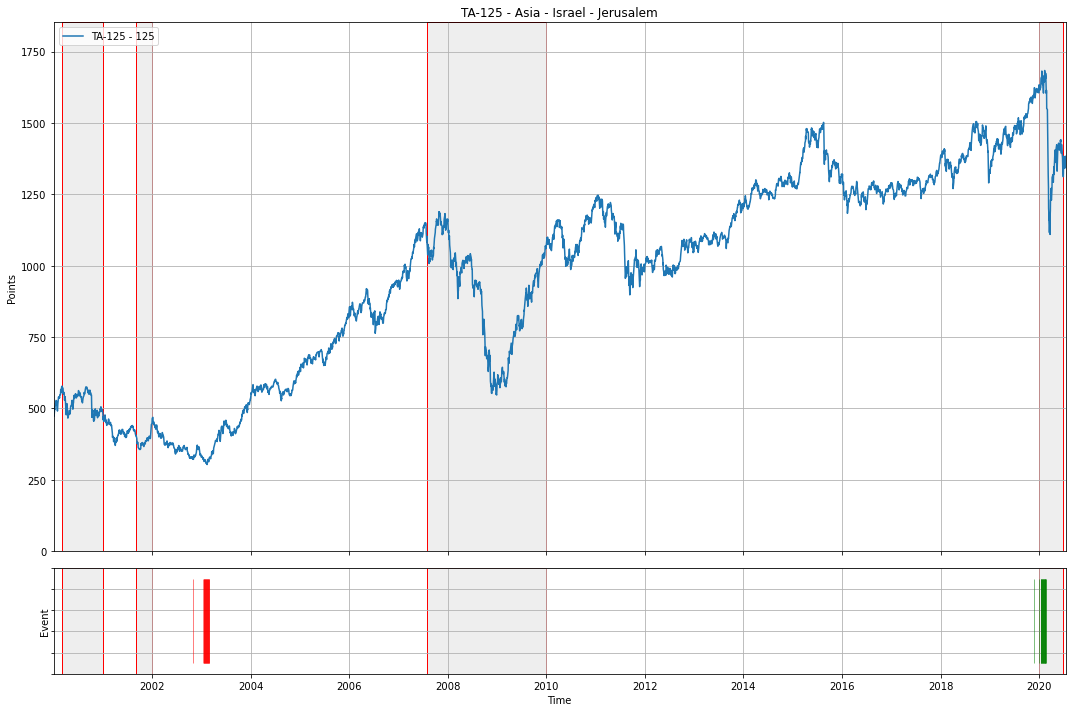

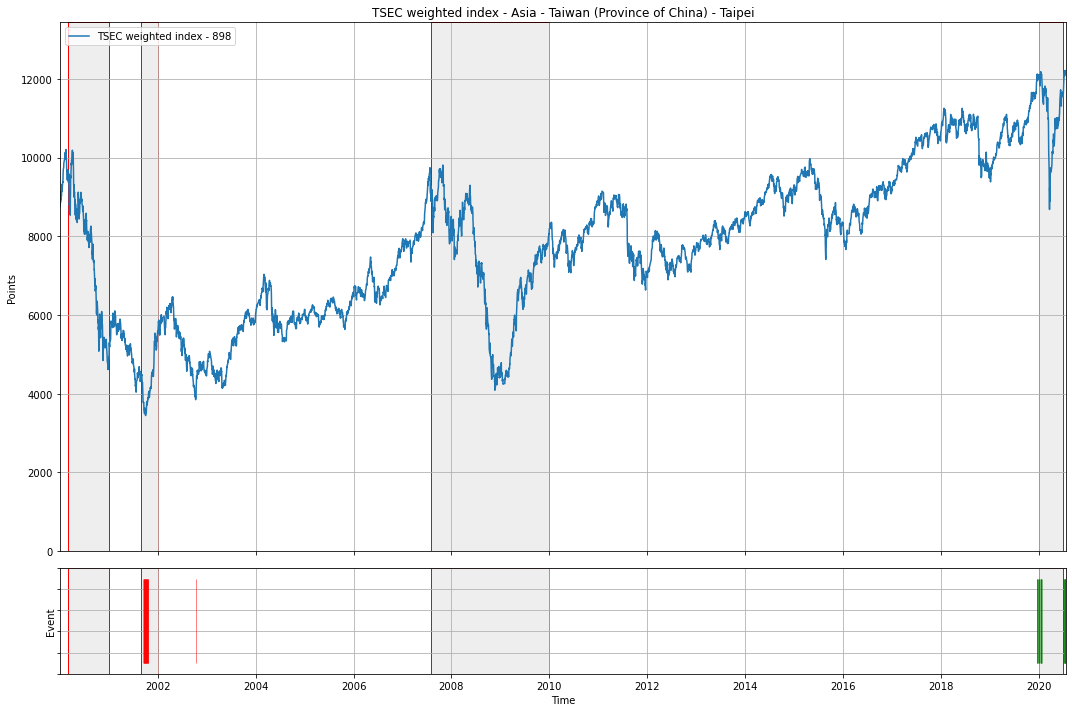

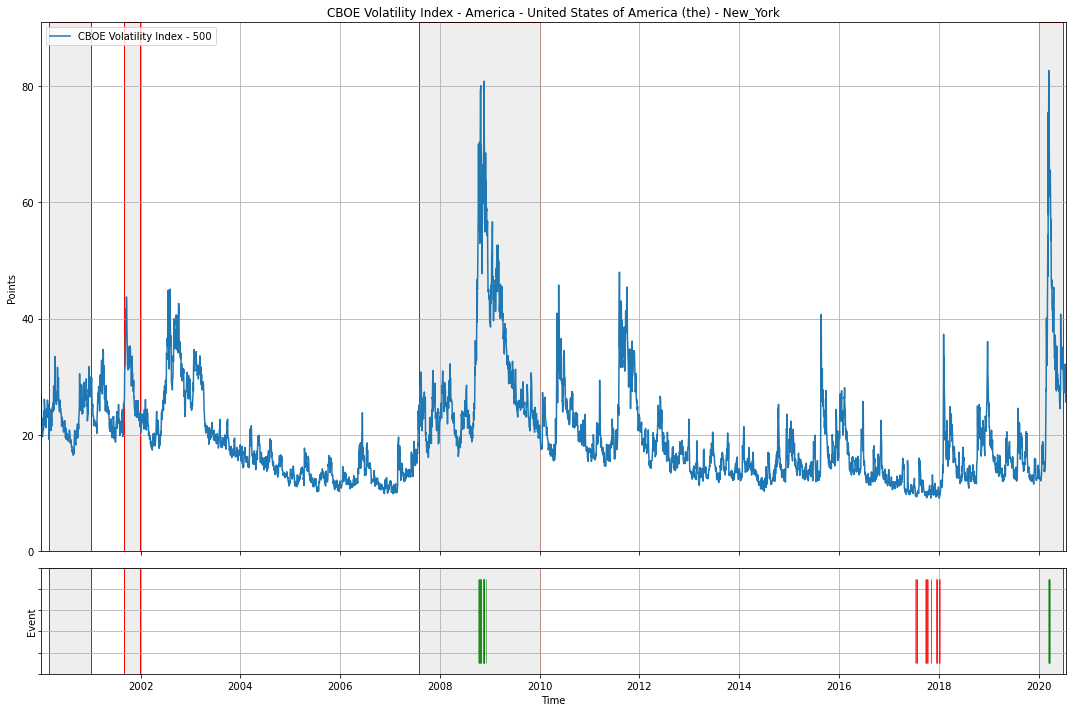

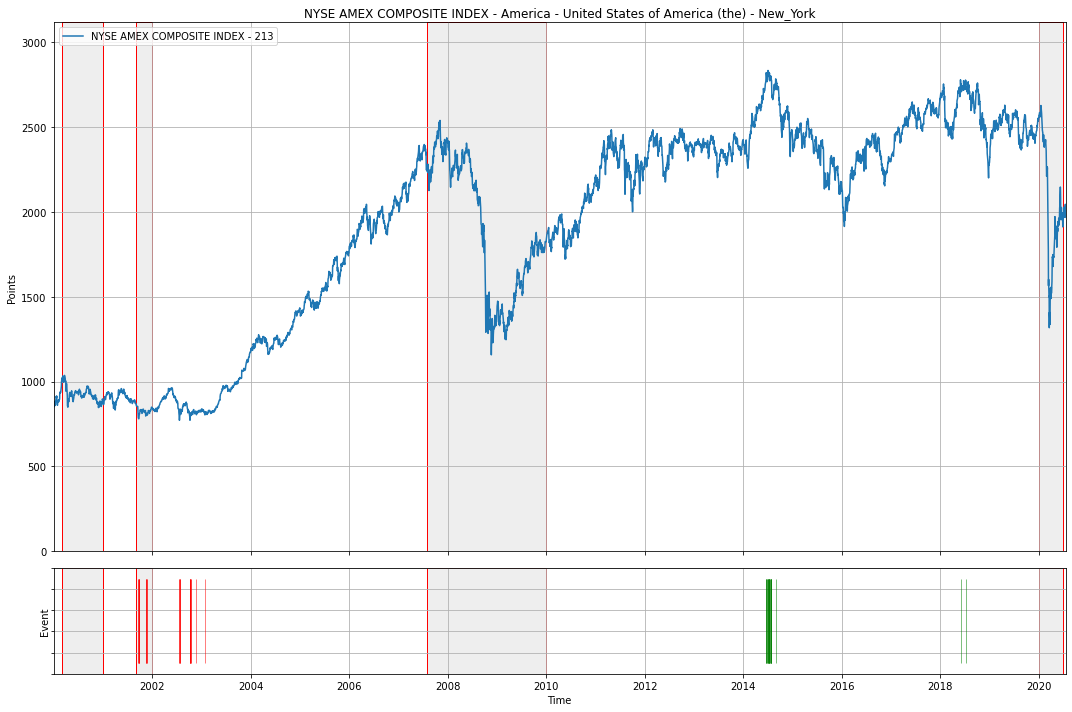

In [24]:
for stock in world_indices['stockname'].unique():
    event_plot(world_indices, stock, stock)

# Performances

In [25]:
full_dates = pd.DataFrame(pd.date_range(START, end=END), columns=['dates'])
pivot = pd.pivot(world_indices, index='formatted_date', 
                 columns='stockname', values='close')
pivot = pd.merge(full_dates, pivot, how='left', 
                 left_on='dates', right_on='formatted_date')
pivot.set_index('dates', inplace=True)
pivot.fillna(method='ffill', axis=0, inplace=True)
#pivot['year'] = pd.to_datetime(pivot.index).year
#pivot['month'] = pd.to_datetime(pivot.index).month
#pivot.index = pd.to_datetime(pivot['formatted_date'])
pivot.head()

ALL ORDINARIES       BEL 20       CAC 40  CBOE Volatility Index  \
dates                                                                         
2000-01-01             NaN          NaN          NaN                    NaN   
2000-01-02             NaN          NaN          NaN                    NaN   
2000-01-03     3124.100098  3311.050049  5917.370117              24.209999   
2000-01-04     3050.899902  3172.209961  5672.020020              27.010000   
2000-01-05     3030.100098  3057.530029  5479.700195              26.410000   

            Cboe UK 100 Price Return  DAX PERFORMANCE-INDEX        Dow 30  \
dates                                                                       
2000-01-01                       NaN                    NaN           NaN   
2000-01-02                       NaN                    NaN           NaN   
2000-01-03                       NaN            6750.759766  11357.509766   
2000-01-04                       NaN            6586.950195  10997.929688   
2000-01-05                       NaN            6502.069824  11122.650391   

            EGX 30 Price Return Index  ESTX 50 PR.EUR  EURONEXT 100  \
dates                                                                 
2000-01-01                        NaN             NaN           NaN   
2000-01-02                        NaN             NaN           NaN   
2000-01-03                        NaN             NaN    996.770020   
2000-01-04                        NaN             NaN    955.969971   
2000-01-05                        NaN             NaN    930.260010   

               FTSE 100  FTSE Bursa Malaysia KLCI  HANG SENG INDEX  IBOVESPA  \
dates                                                                          
2000-01-01          NaN                       NaN              NaN       NaN   
2000-01-02          NaN                       NaN              NaN       NaN   
2000-01-03          NaN                833.890015     17369.630859   16930.0   
2000-01-04  6665.899902                832.799988     17072.820312   15851.0   
2000-01-05  6535.899902                815.799988     15846.719727   16245.0   

             IPC MEXICO  Jakarta Composite Index  KOSPI Composite Index  \
dates                                                                     
2000-01-01          NaN                      NaN                    NaN   
2000-01-02          NaN                      NaN                    NaN   
2000-01-03  7077.709961                      NaN                    NaN   
2000-01-04  6675.270020               700.218018            1059.040039   
2000-01-05  6764.310059               678.086975             986.309998   

                MERVAL  MOEX Russia Index  NYSE AMEX COMPOSITE INDEX  \
dates                                                                  
2000-01-01         NaN                NaN                        NaN   
2000-01-02         NaN                NaN                        NaN   
2000-01-03  551.830017                NaN                 868.739990   
2000-01-04  522.969971                NaN                 849.650024   
2000-01-05  532.679993                NaN                 858.880005   

            NYSE COMPOSITE (DJ)       Nasdaq    Nikkei 225  Russell 2000  \
dates                                                                      
2000-01-01                  NaN          NaN           NaN           NaN   
2000-01-02                  NaN          NaN           NaN           NaN   
2000-01-03          6762.109863  4131.149902           NaN    496.420013   
2000-01-04          6543.759766  3901.689941  19002.859375    478.380005   
2000-01-05          6567.029785  3877.540039  18542.550781    478.829987   

                S&P 500  S&P BSE SENSEX  S&P/ASX 200  S&P/CLX IPSA  \
dates                                                                
2000-01-01          NaN             NaN          NaN           NaN   
2000-01-02          NaN             NaN          NaN           NaN   
2000-01-03  145

In [67]:
# The plot below helps to resolve the question: having a fixed date, and a look-back 
# delta time frame of x days, at which date in the past should I have had invested my money to make profit?
# Thank you, captain hindsight...

def buy_sell_pctchange(df, stock, delta=180, filename=None):
    """
    Shows the percentage change of a stock bought at date x
    and sold at date x + delta.
    """
    pct_changes = []
    for ix, row in df.iterrows():
        try:
            cur_val = row[stock]
            future_val = pivot[stock].loc[ix+datetime.timedelta(days=delta)]
            pct_change = (future_val - cur_val)/cur_val
            pct_changes.append( (ix, pct_change) )
        except:
            break

    changes = pd.DataFrame(pct_changes)
    changes.index = pd.to_datetime(changes[0])
    changes.index.name = 'Dates (at stock buy date)'
    changes.drop([0], axis=1, inplace=True)
    changes.columns = [stock]
    max_height = changes[stock].dropna().max()*1.1
    min_height = changes[stock].dropna().min()*1.1
    if np.isnan(max_height):
        max_height = 1
    if np.isnan(min_height):
        min_height = 0
        
    fig, ax = plt.subplots(figsize=(15, 10), tight_layout=True)
    # approximate dates for crashes
    for crashs in (('2000-03-01', '2000-12-31'), # Dotcom bubble
                   ('2001-09-01', '2001-12-31'), # World Trade Center
                   ('2007-08-01', '2009-12-31'), # Financial Crisis
                   ('2020-01-01', '2020-06-30') # Corona
                  ):
        start = mdates.datestr2num(crashs[0])
        end = mdates.datestr2num(crashs[1])
        width = end - start

        rectl = Rectangle((start, min_height), width, max_height - min_height, 
                         linewidth=1, edgecolor='r', facecolor='#EEEEEE')
        ax.add_patch(rectl)
        rectl2 = Rectangle((start, min_height), width, max_height - min_height,
                         linewidth=1, edgecolor='r', facecolor='#EEEEEE')
        ax.add_patch(rectl2)
    
    ax.plot([changes.index.min(), changes.index.max()], 
            [0, 0], color='r', ls='--')
    changes.plot(figsize=(15, 10), ax=ax)
    ax.set_ylim([min_height, max_height])
    ax.set_xlim([changes.index.min(), changes.index.max()])
    ax.set_title('Maximum Change ({} days)'.format(delta))
    ax.set_ylabel('Percentage Change {} days (at stock sell date)'.format(delta))
    plt.grid()
    if filename is not None:
        title = re.sub('[^0-9a-zA-Z]+', '_', stock)
        plt.savefig('indices/pct_change_{}_{}.png'.format(title, delta), dpi=150, format='png',
            bbox_inches='tight')
    plt.show()

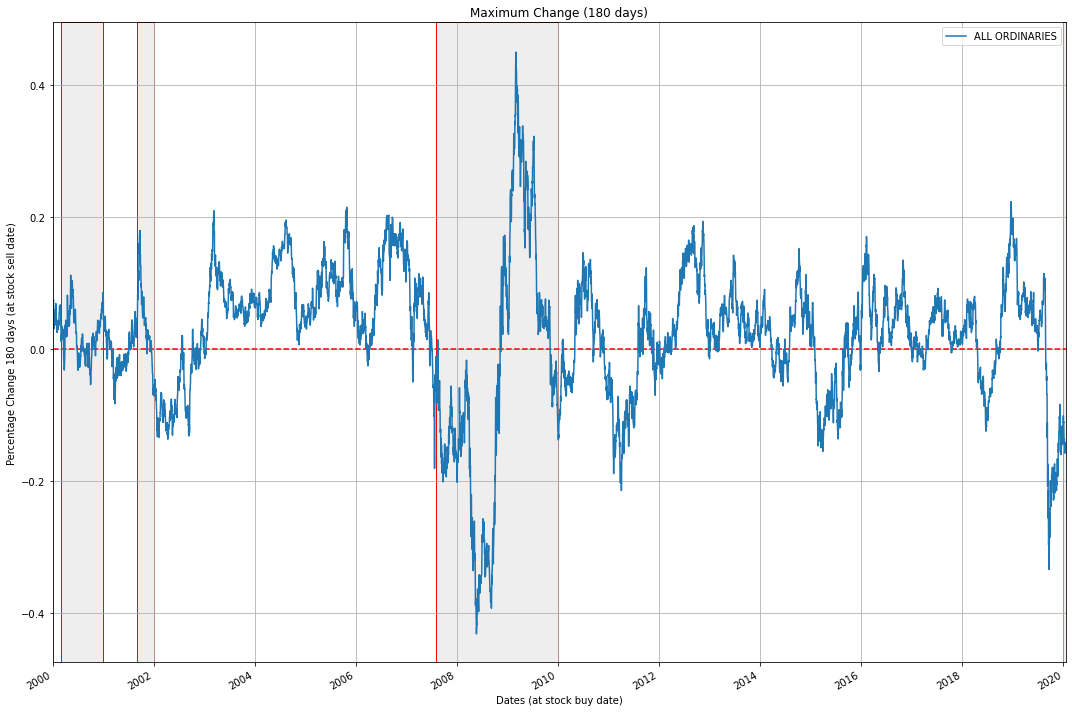

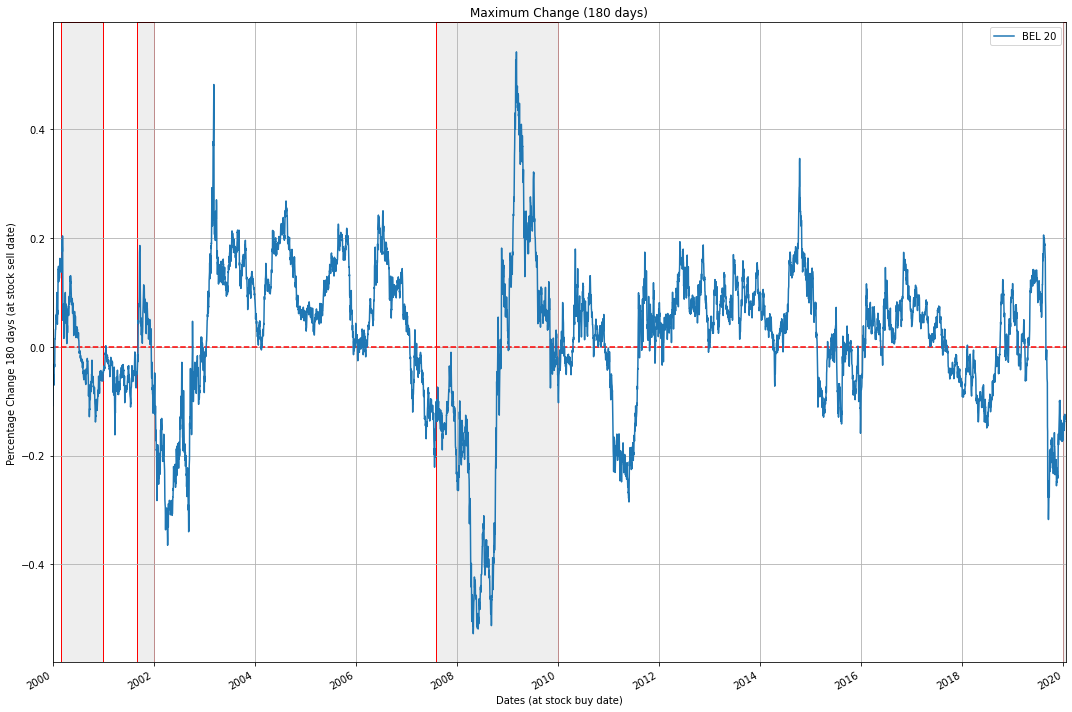

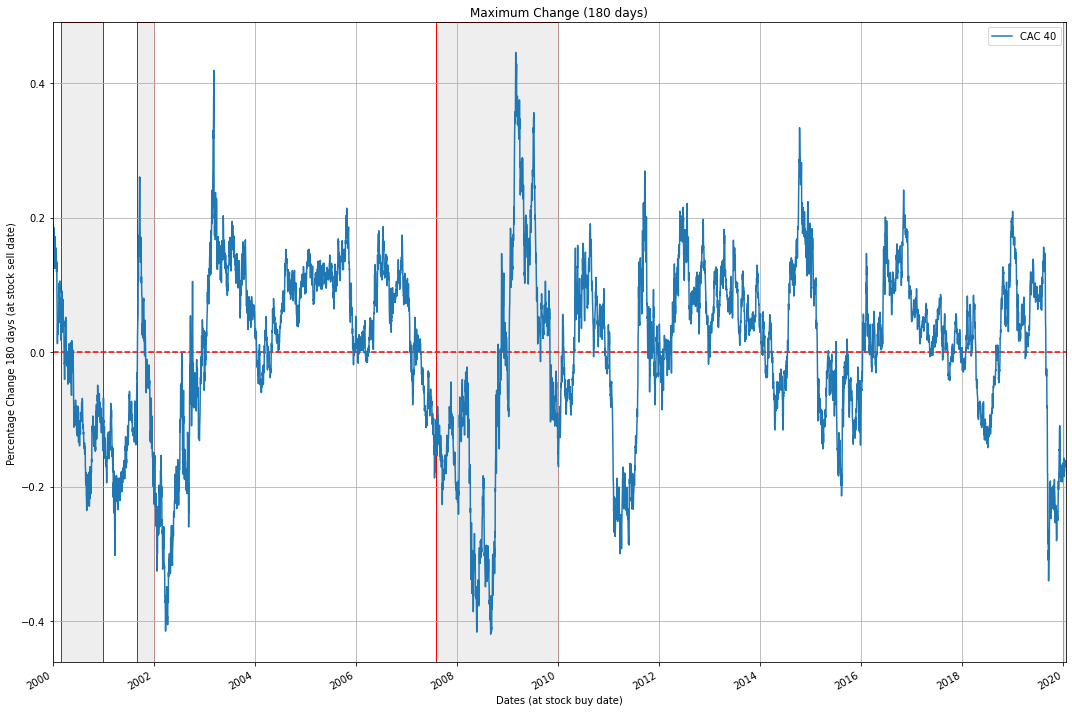

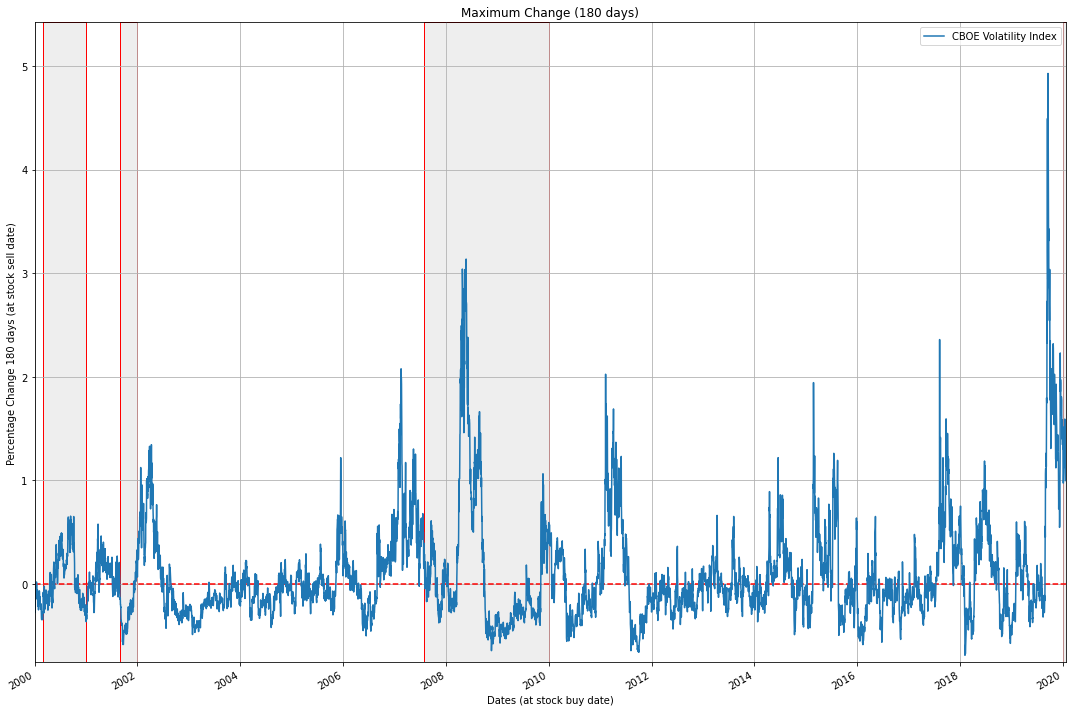

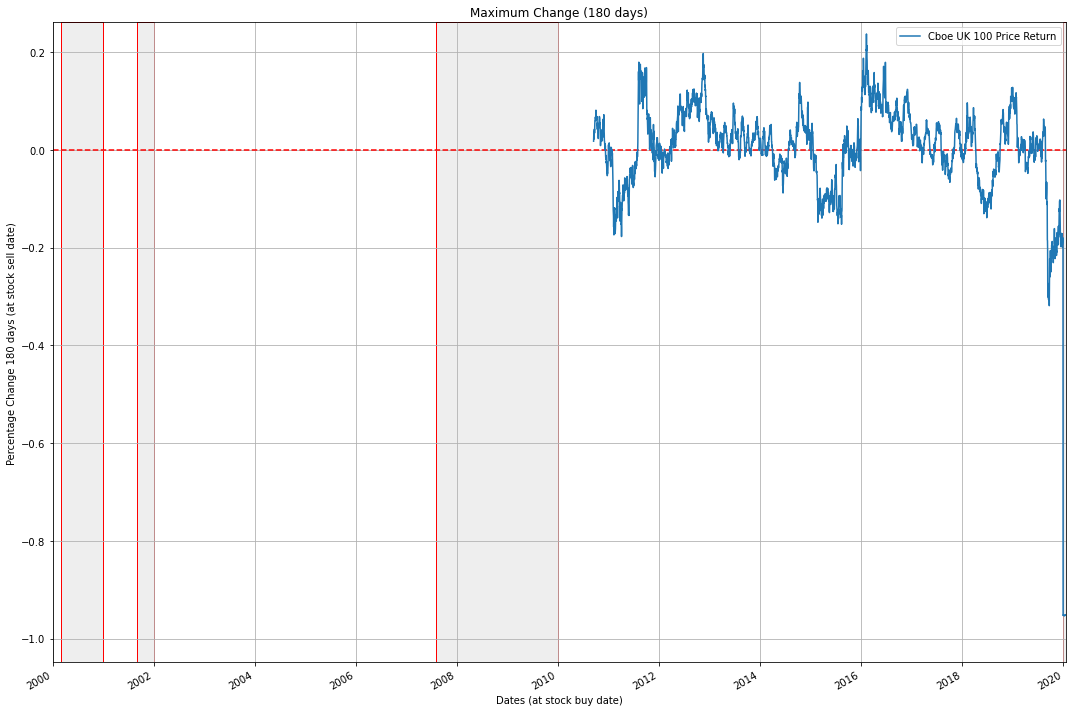

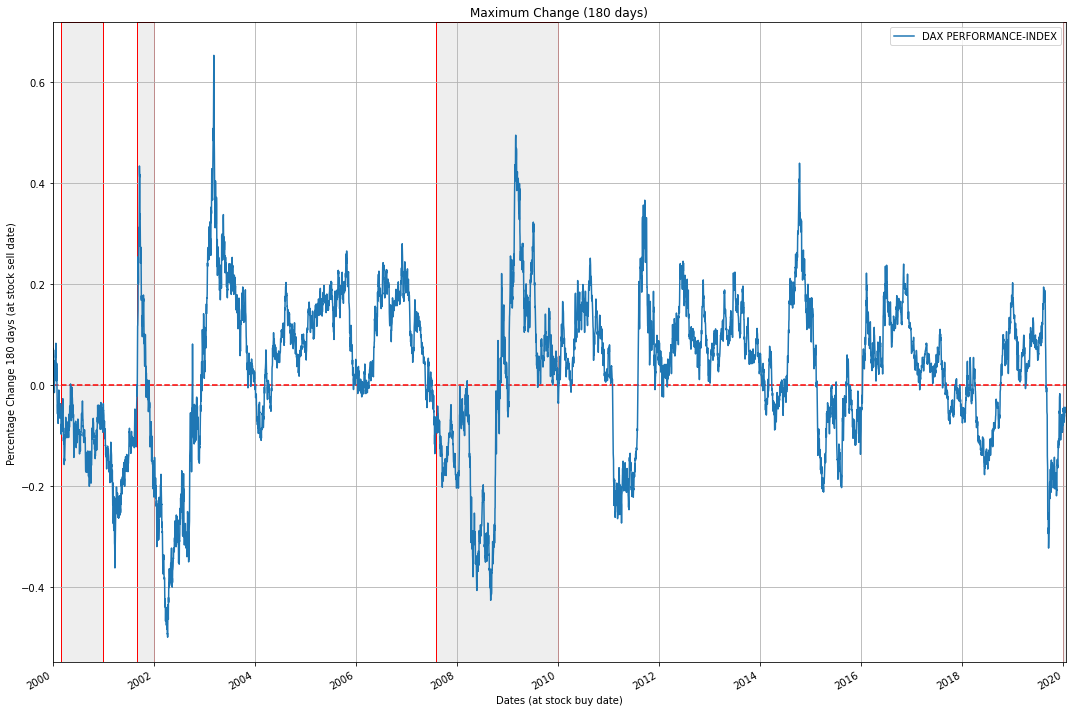

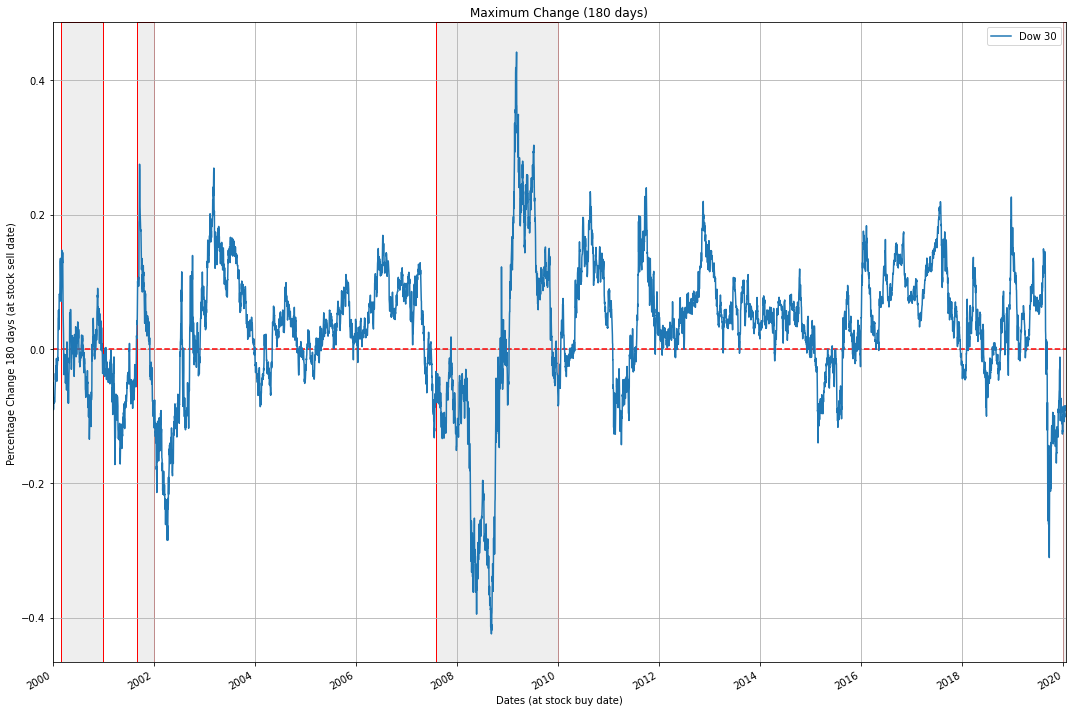

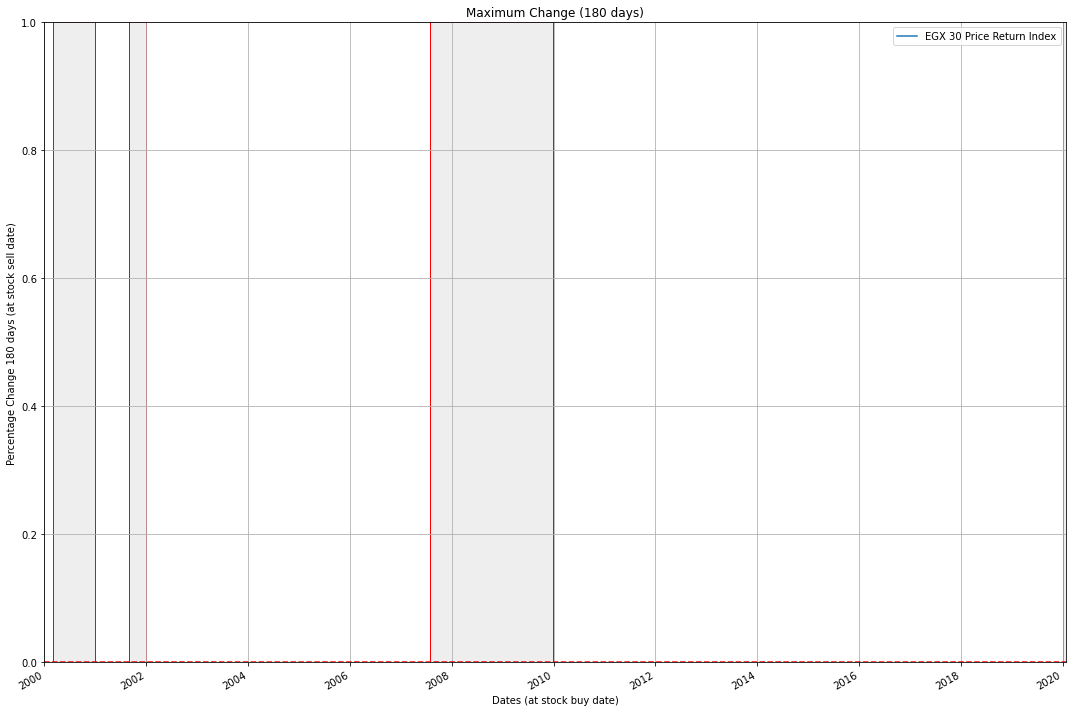

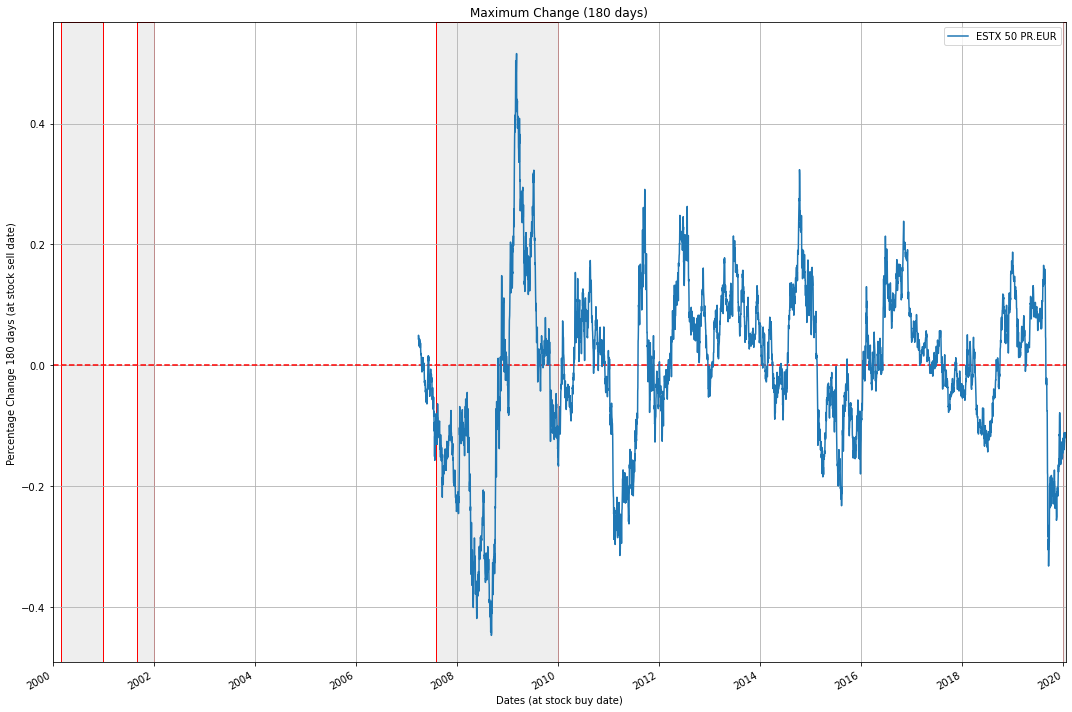

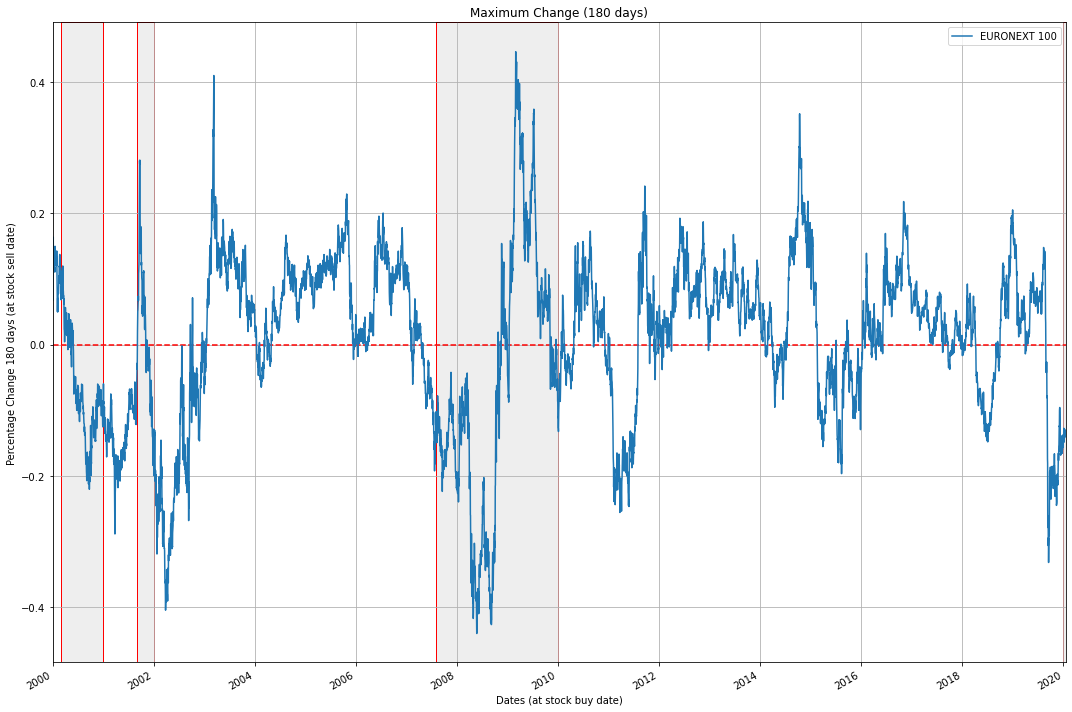

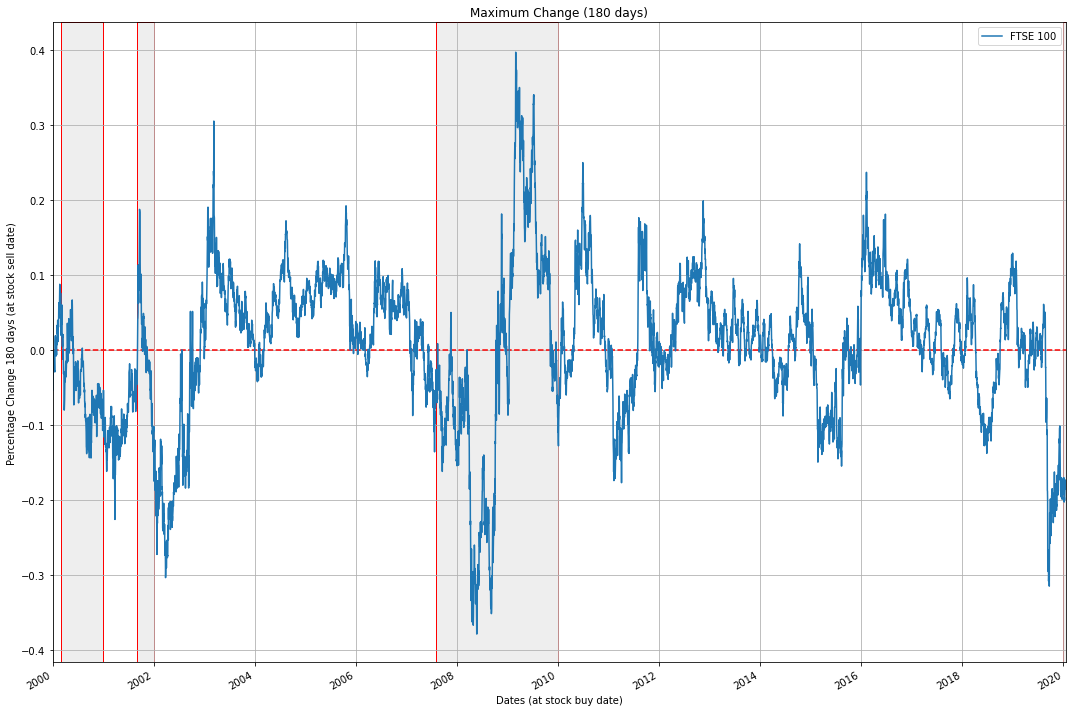

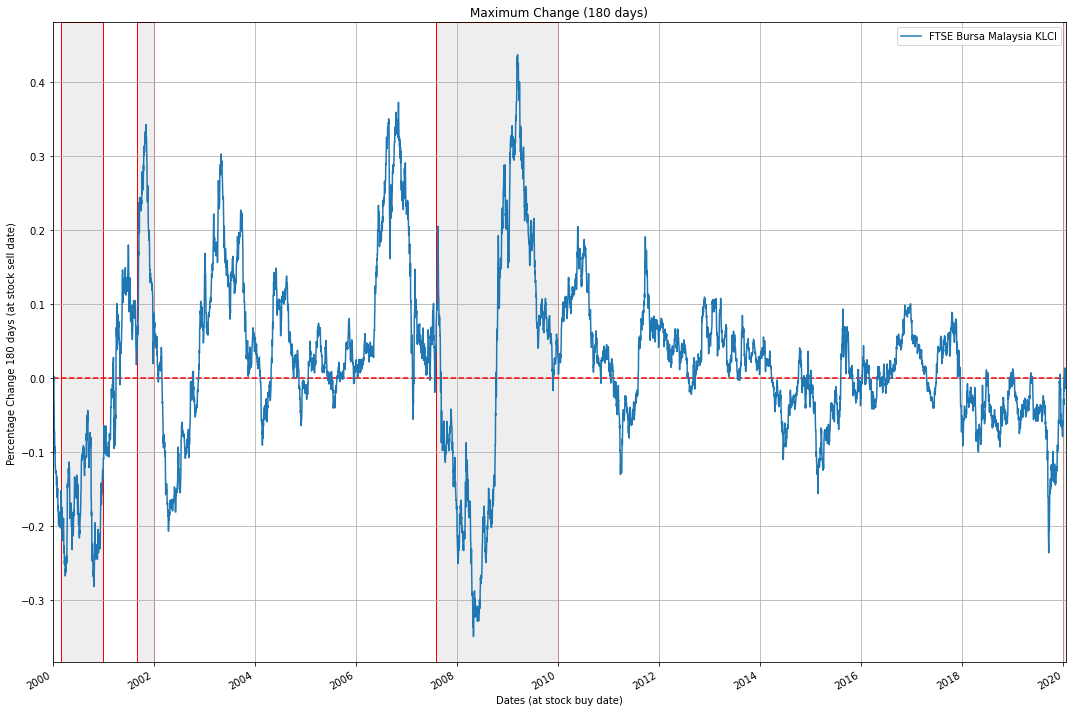

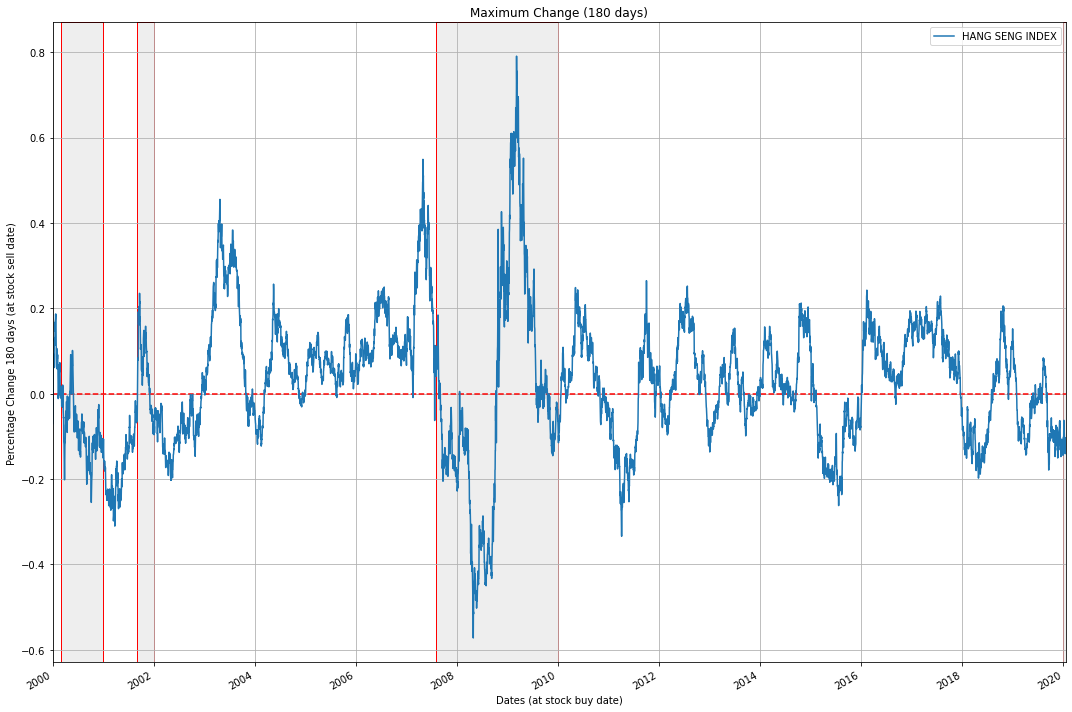

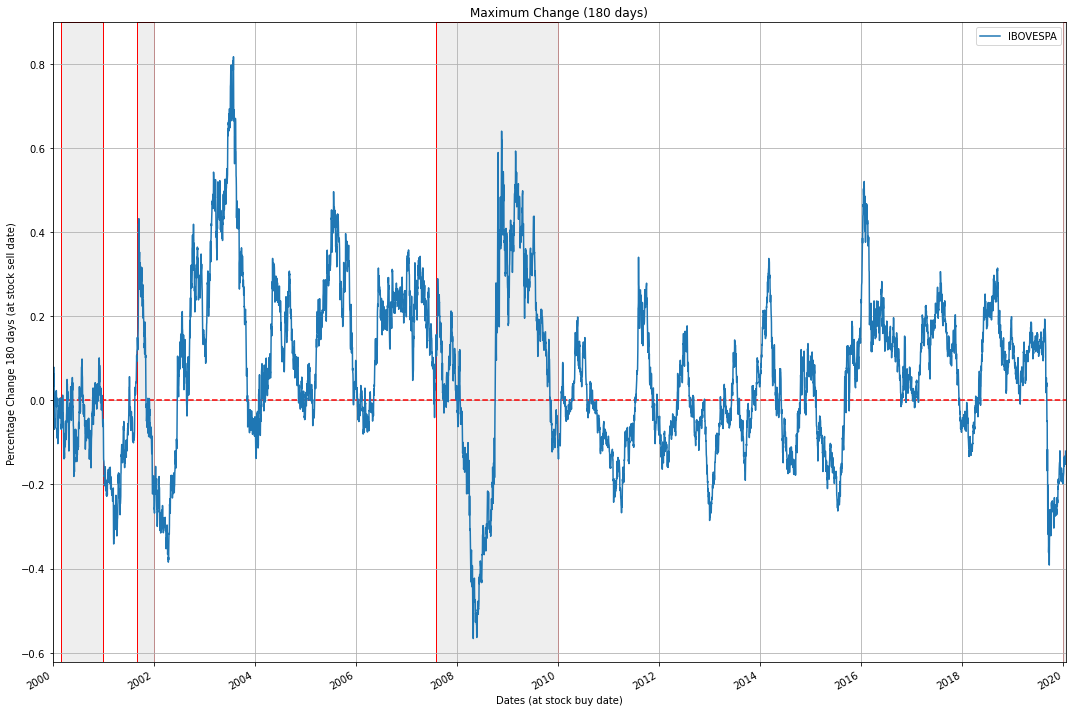

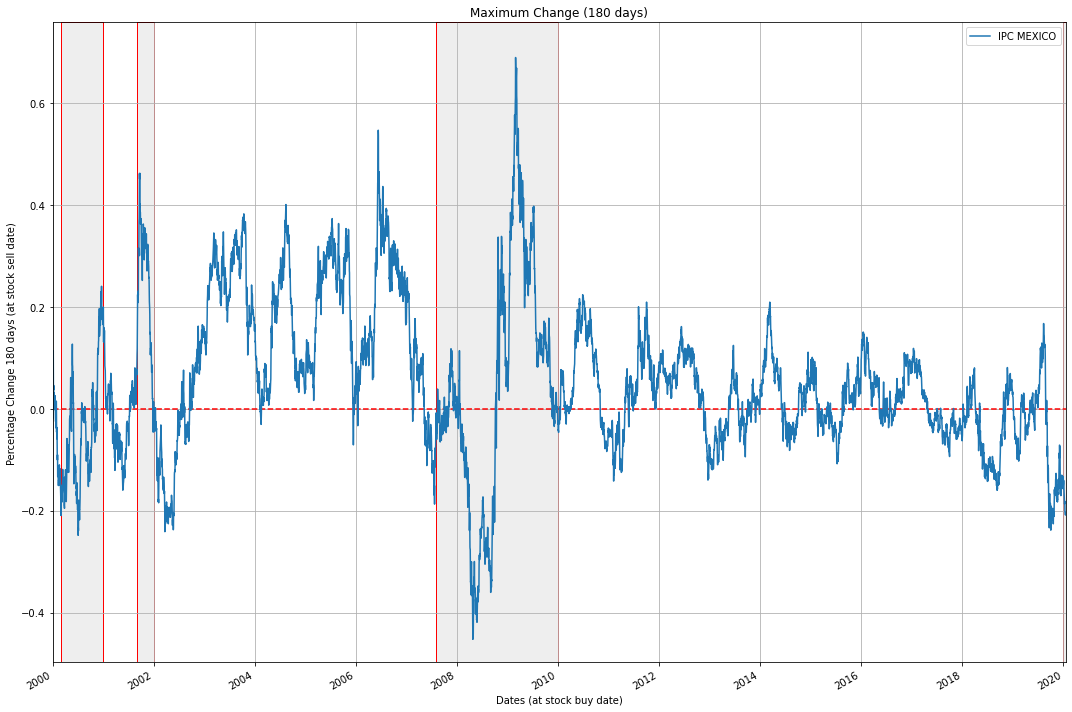

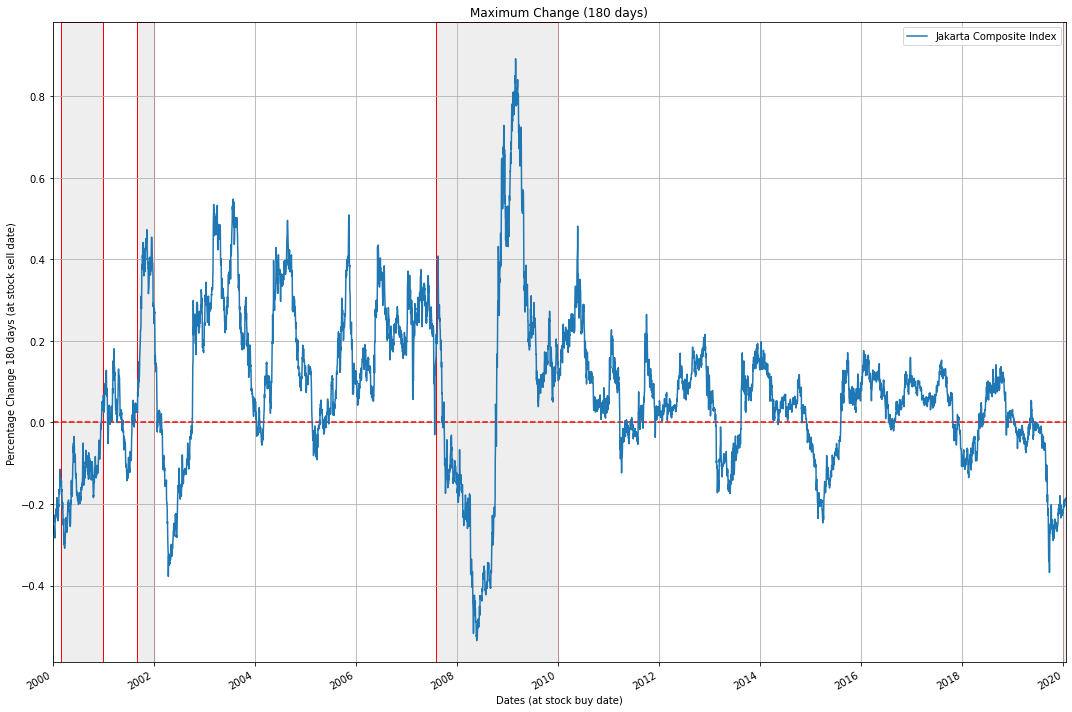

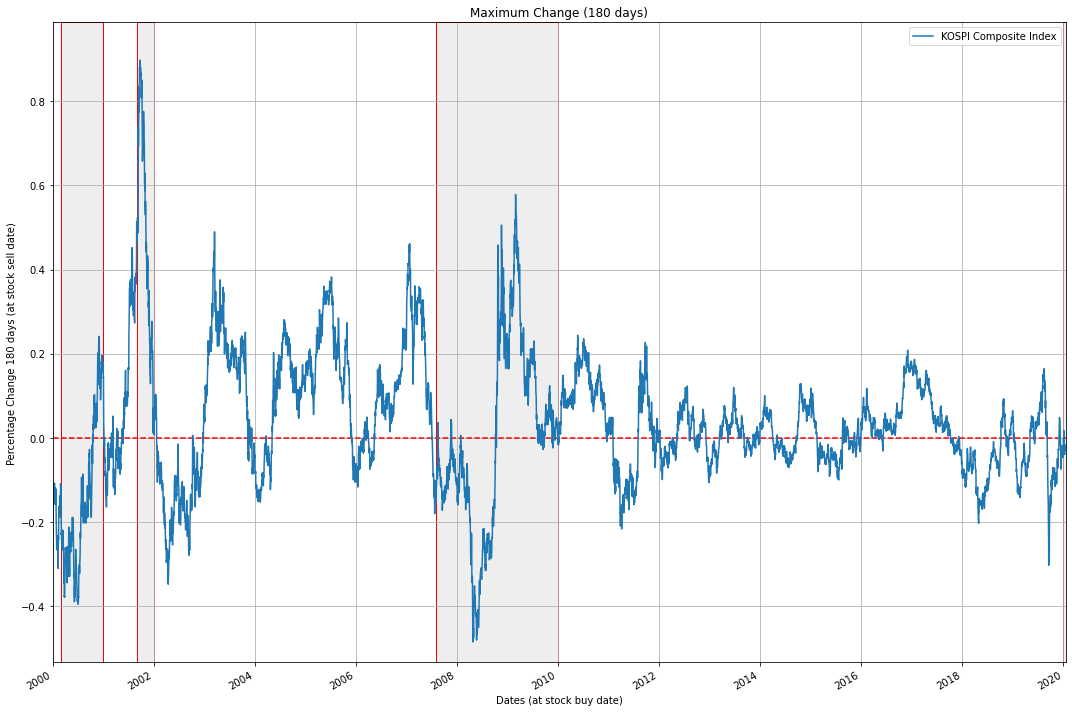

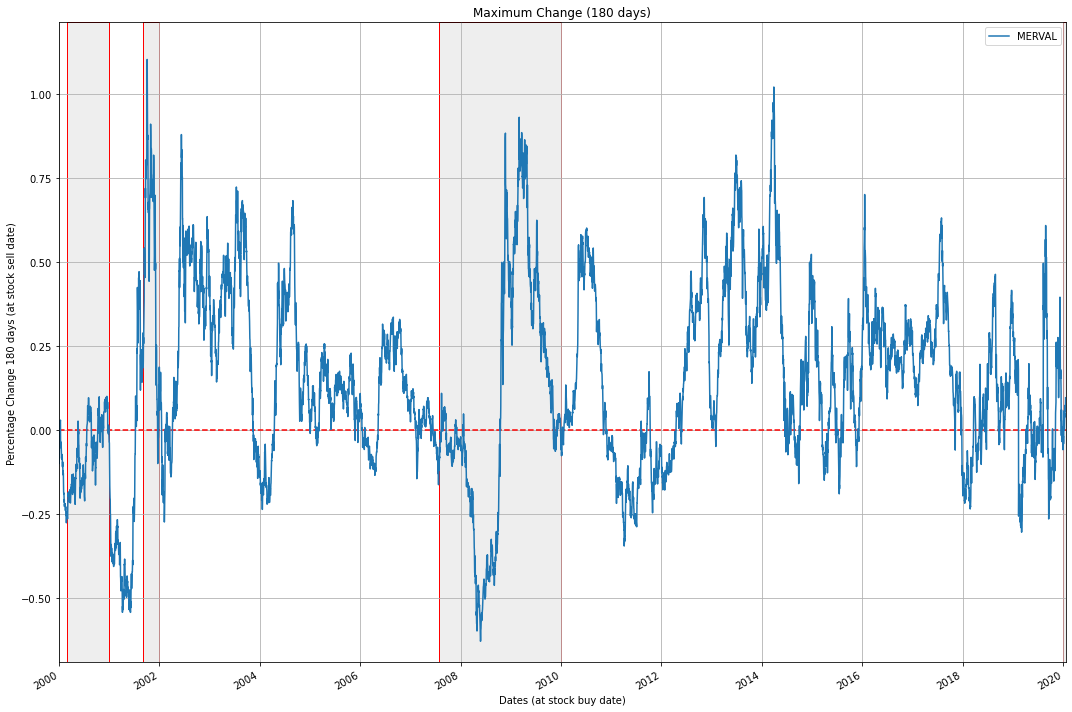

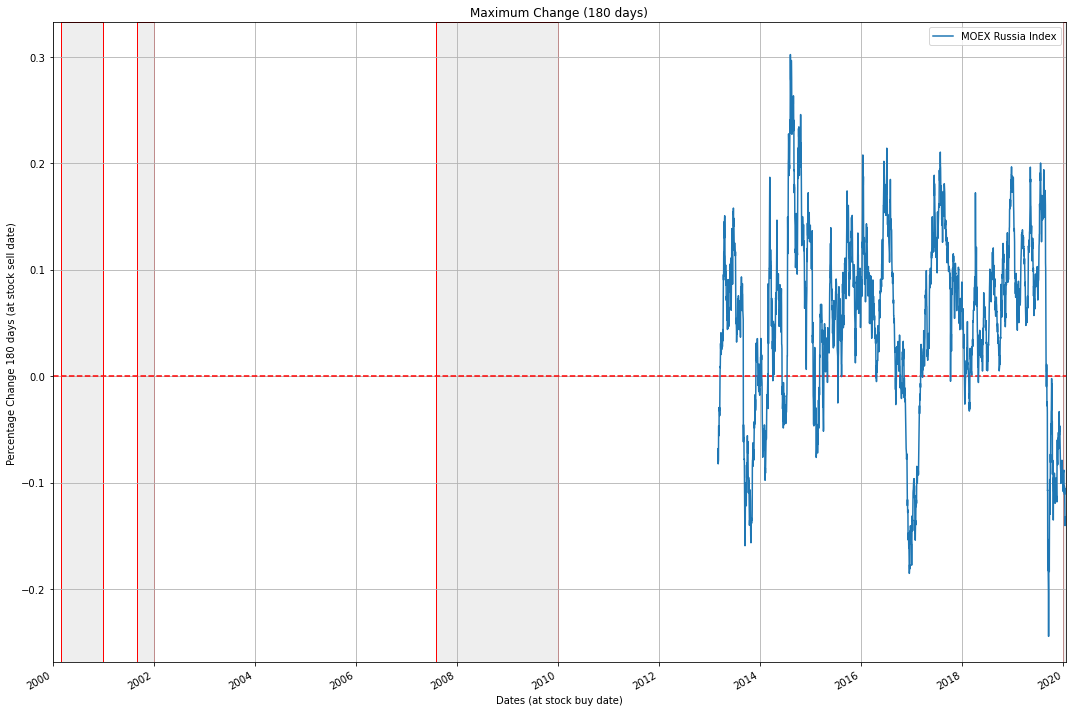

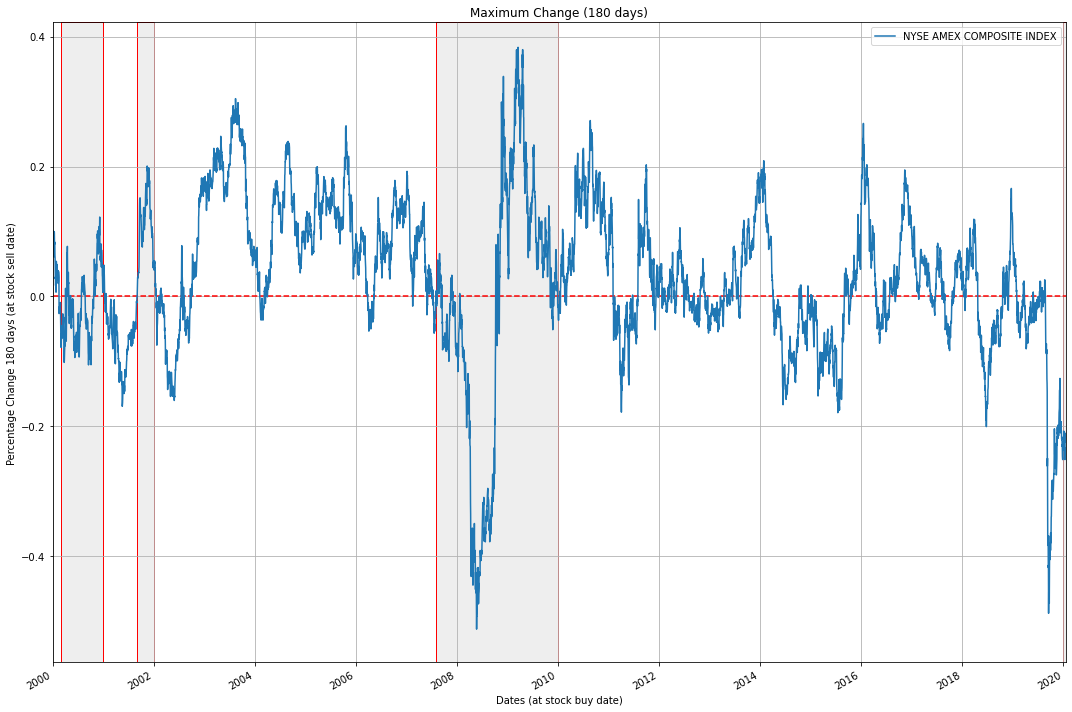

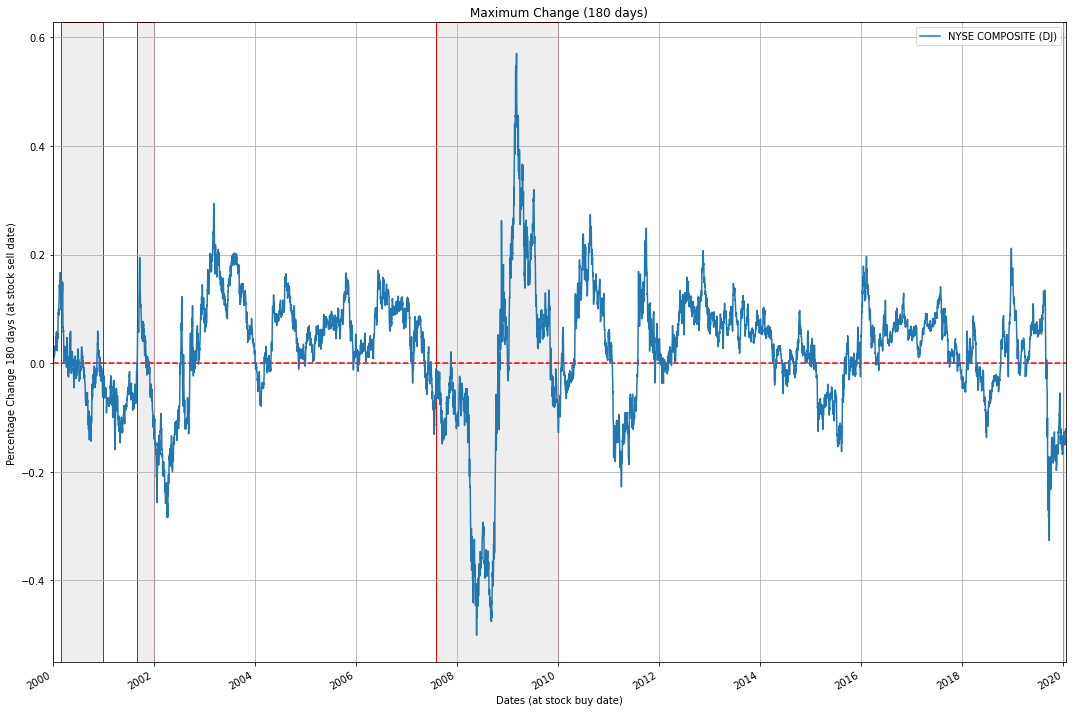

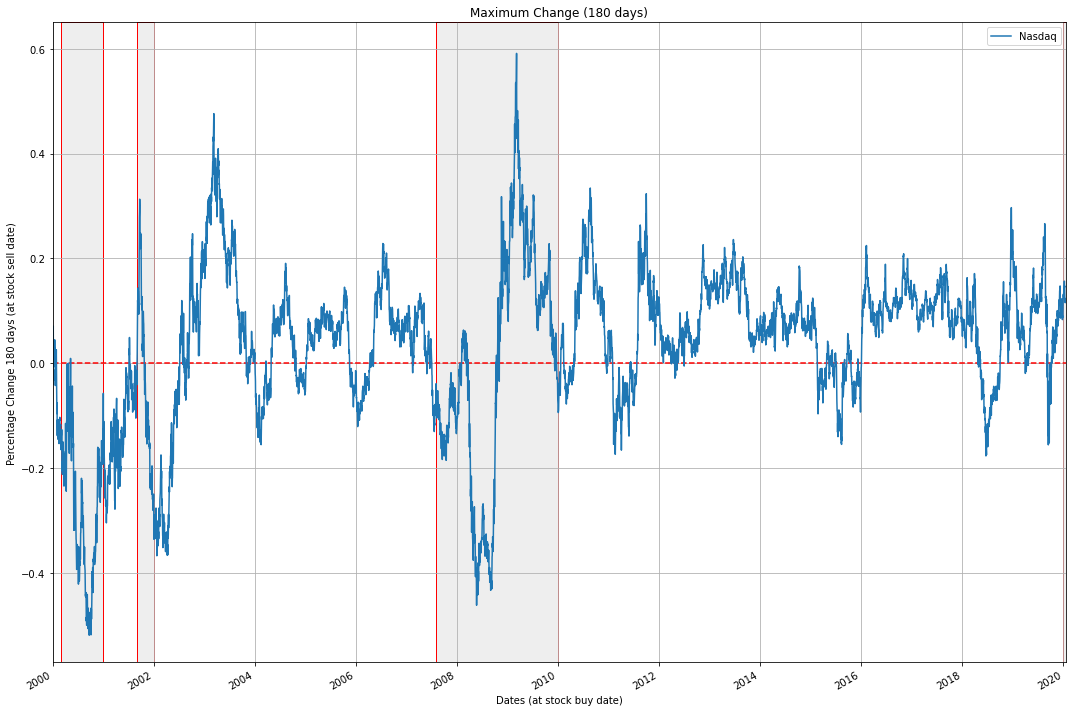

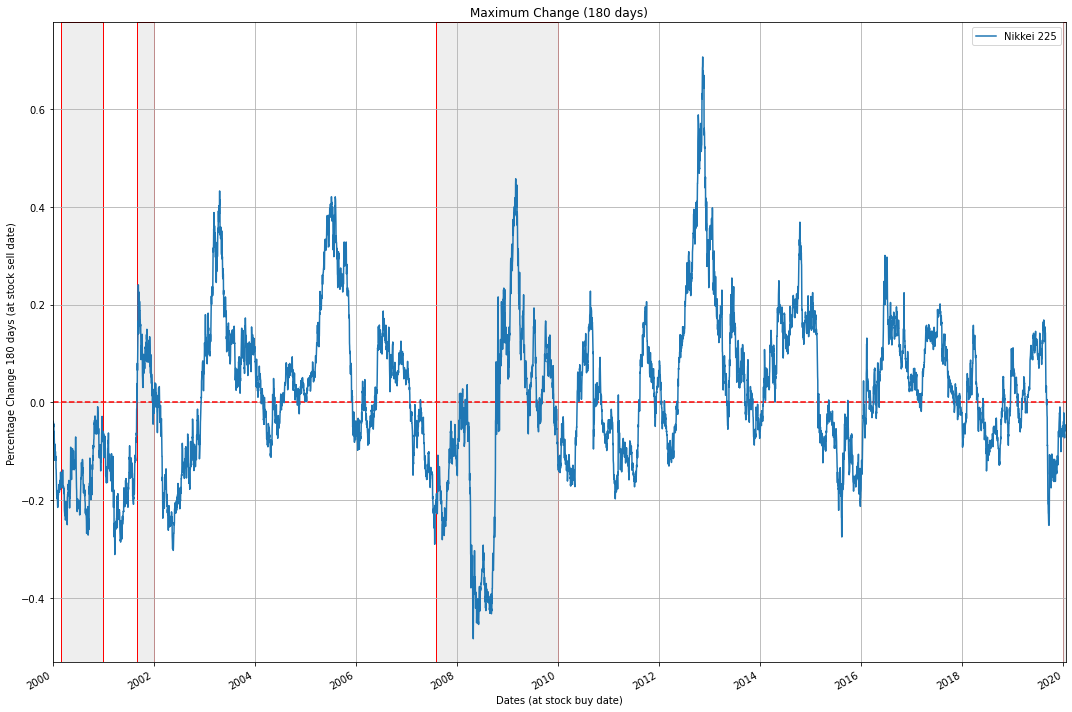

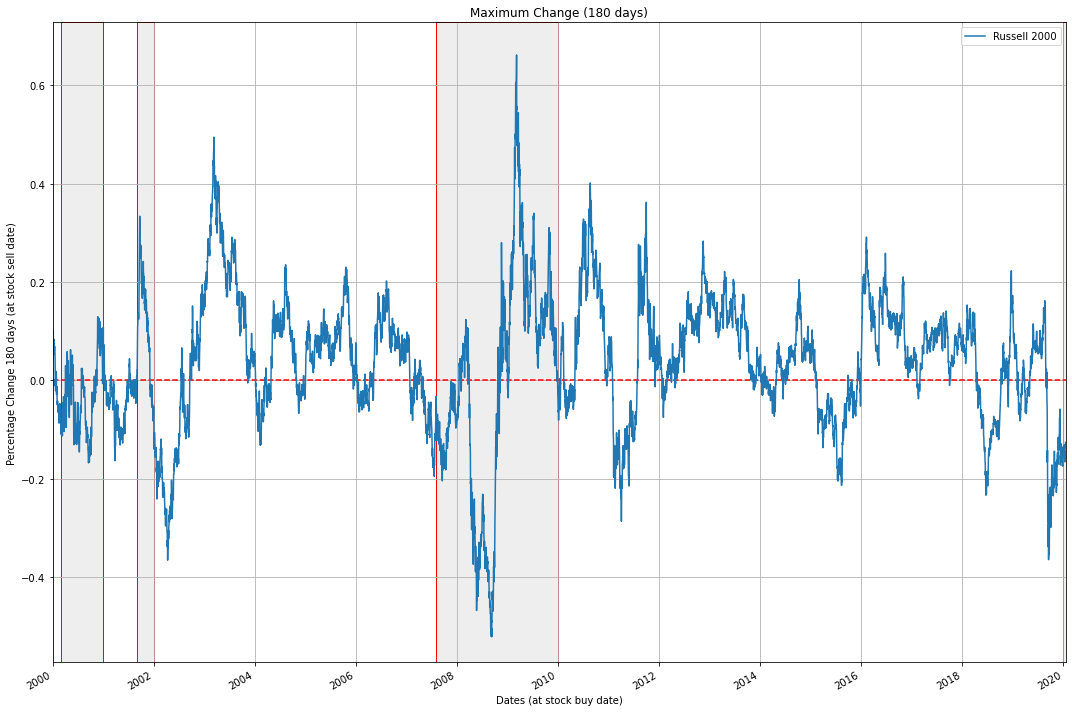

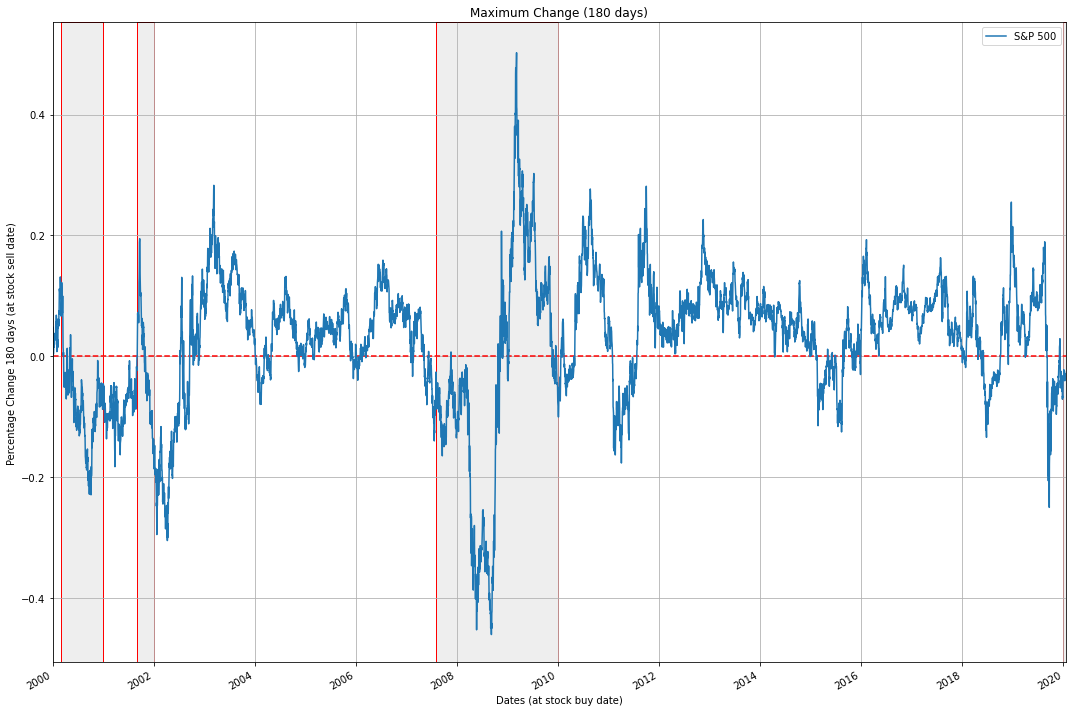

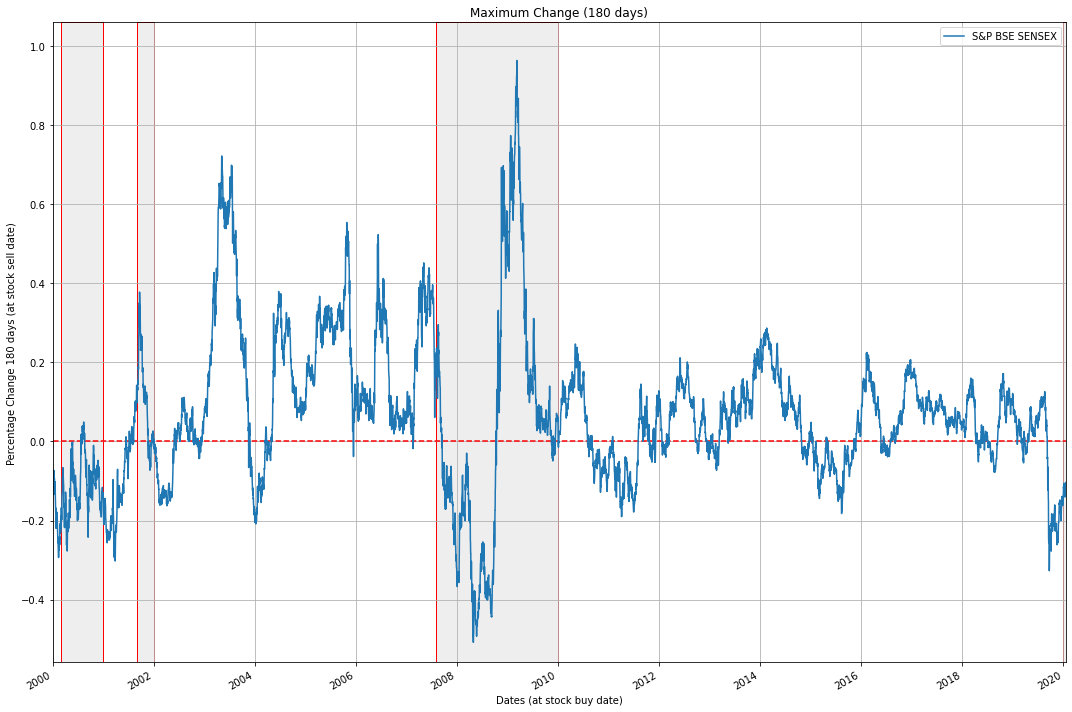

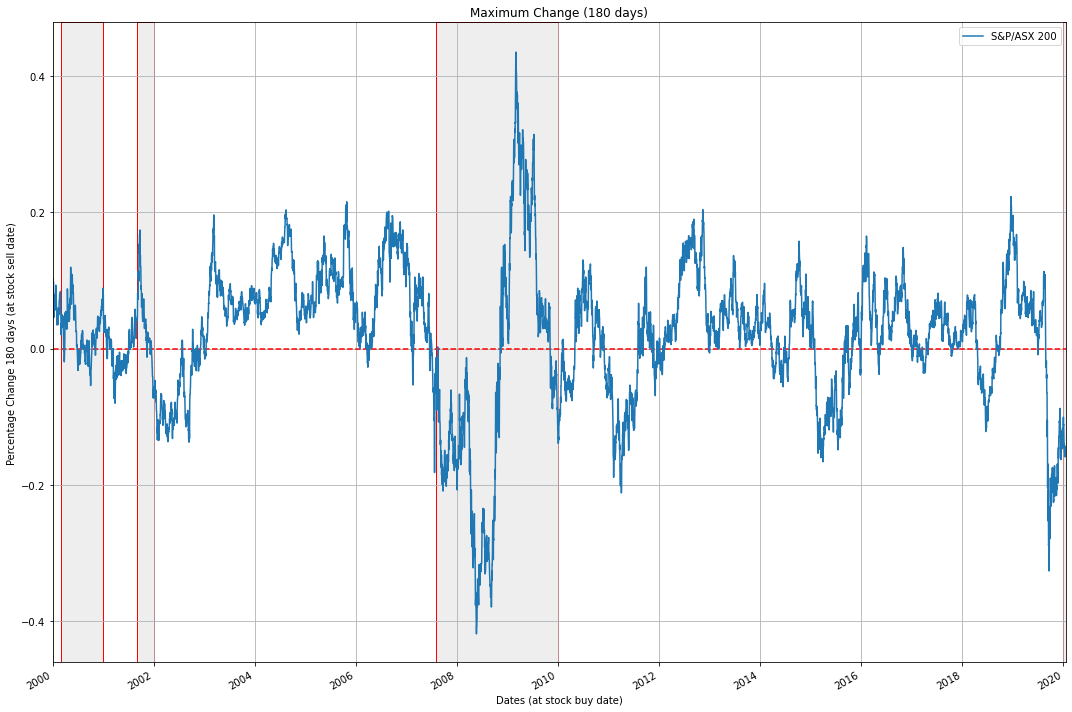

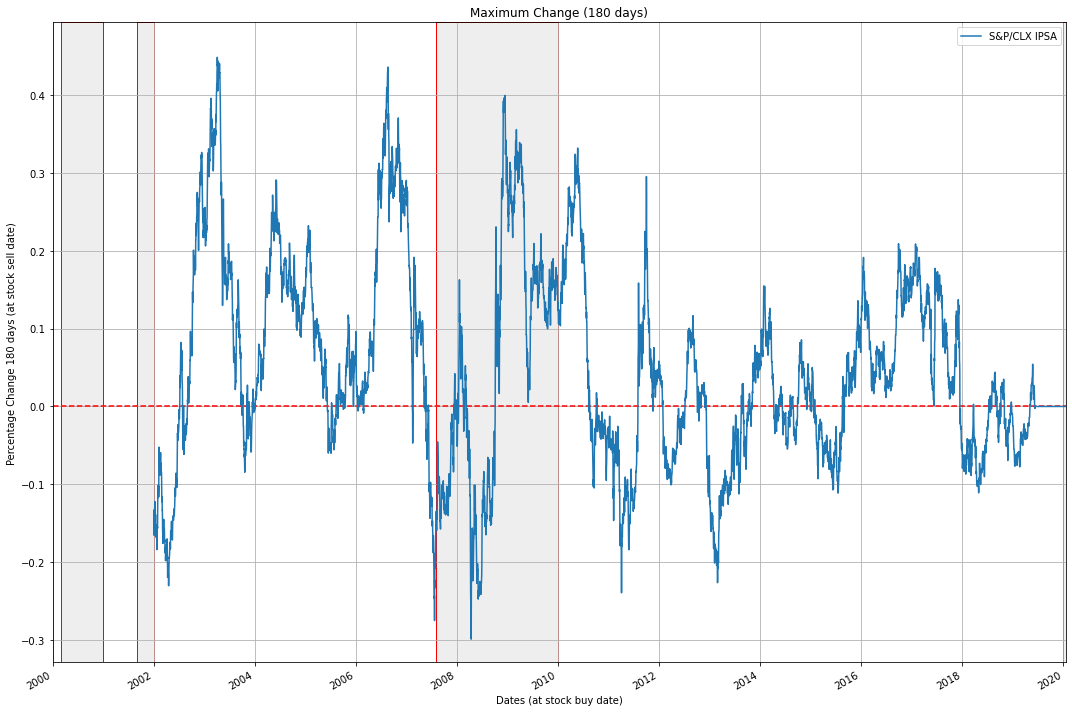

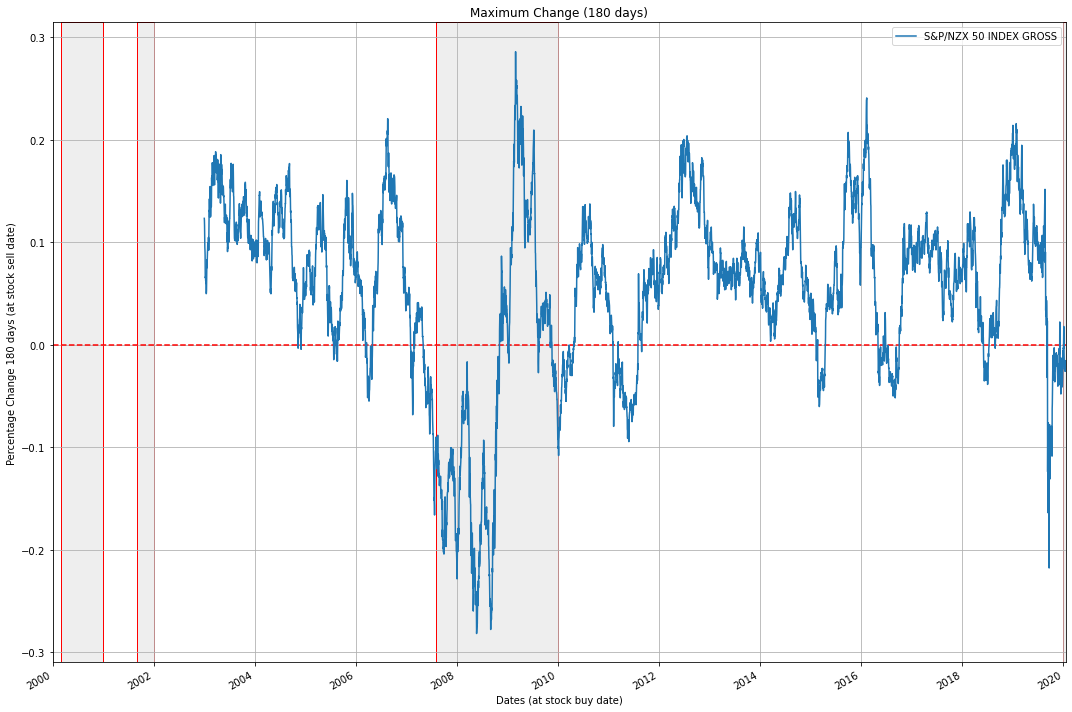

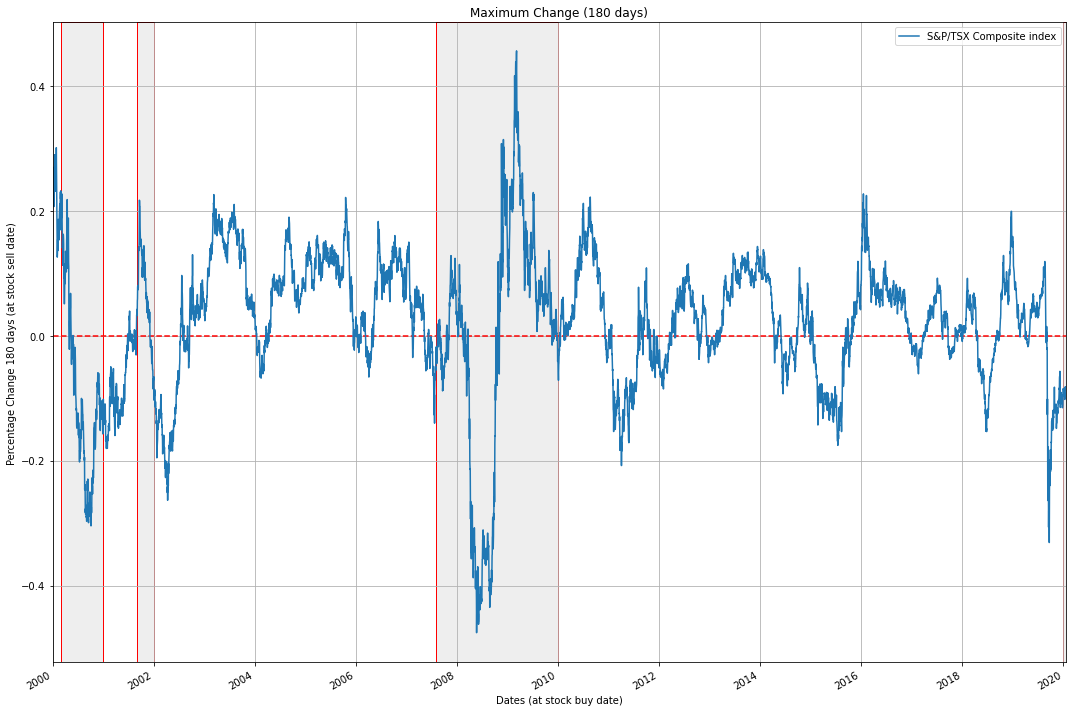

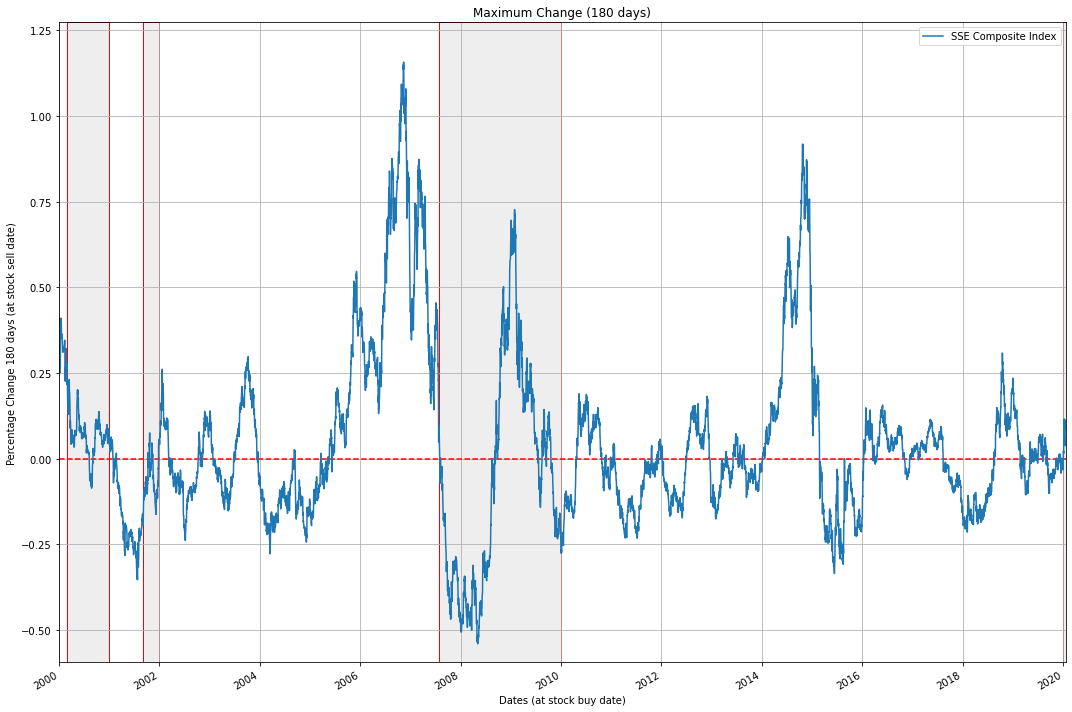

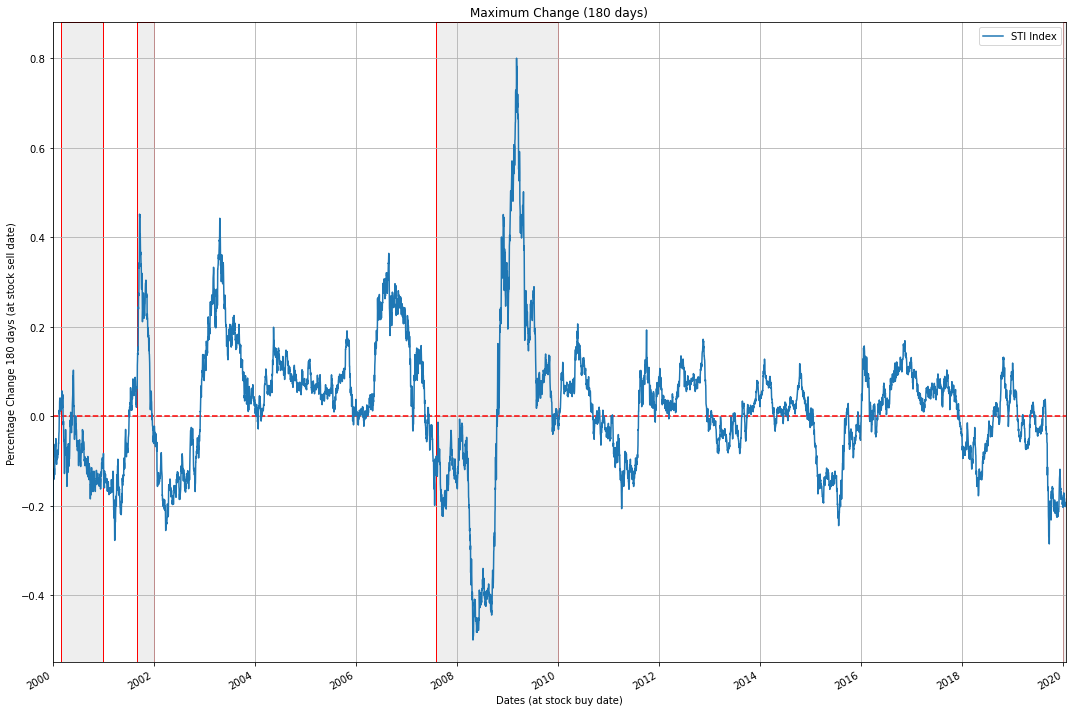

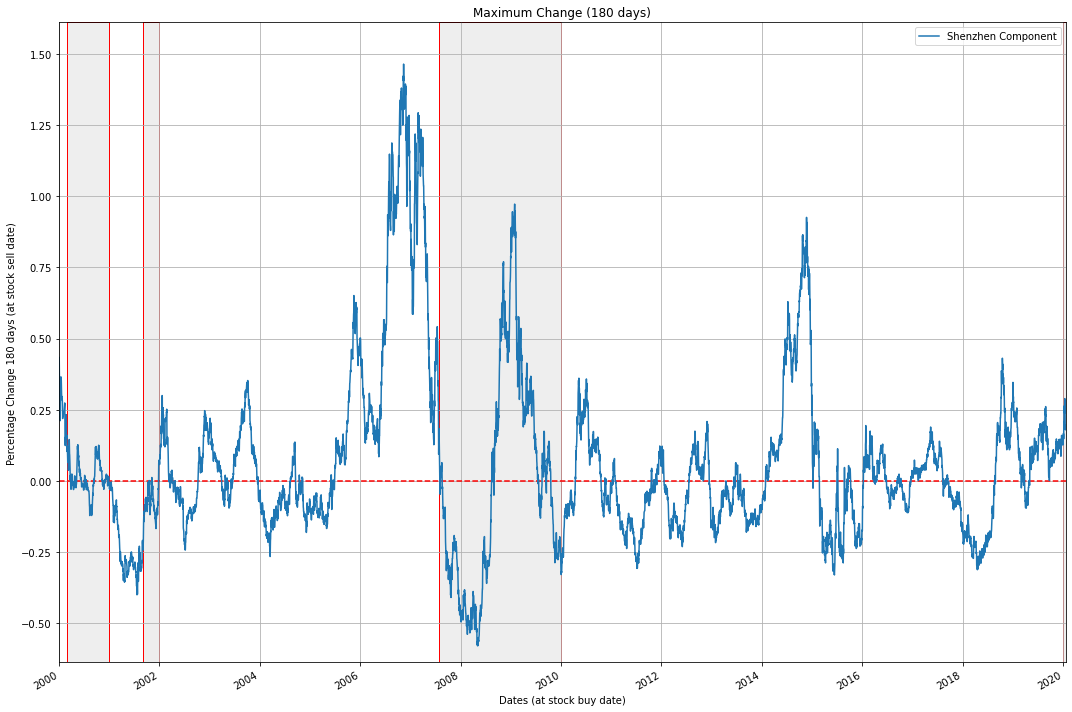

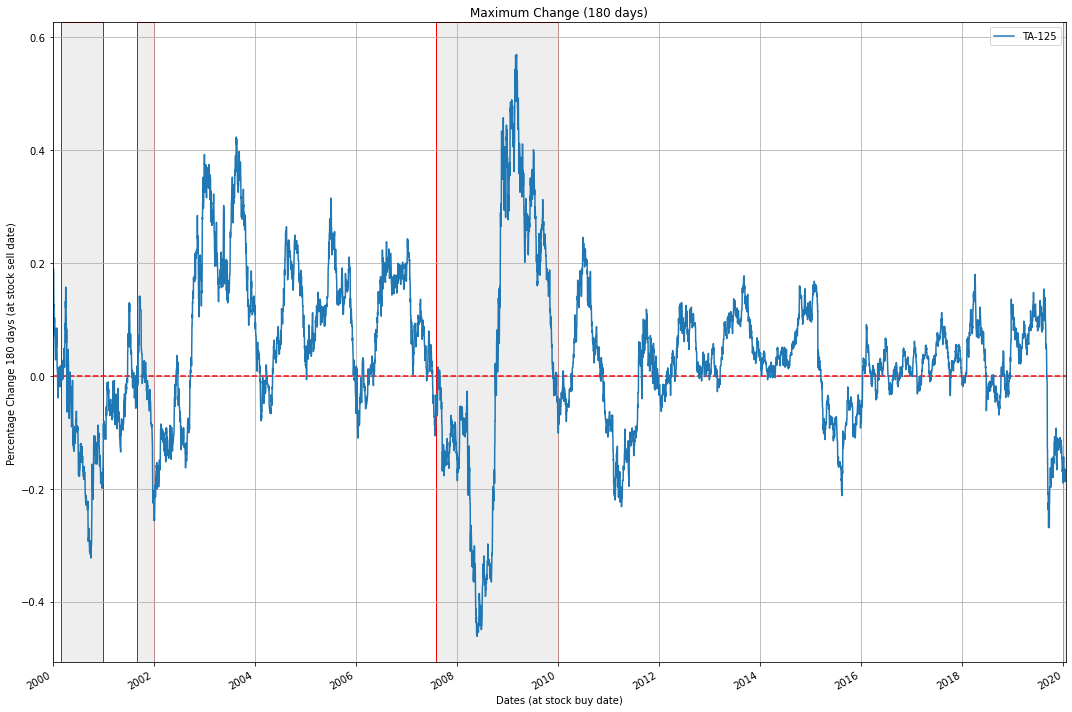

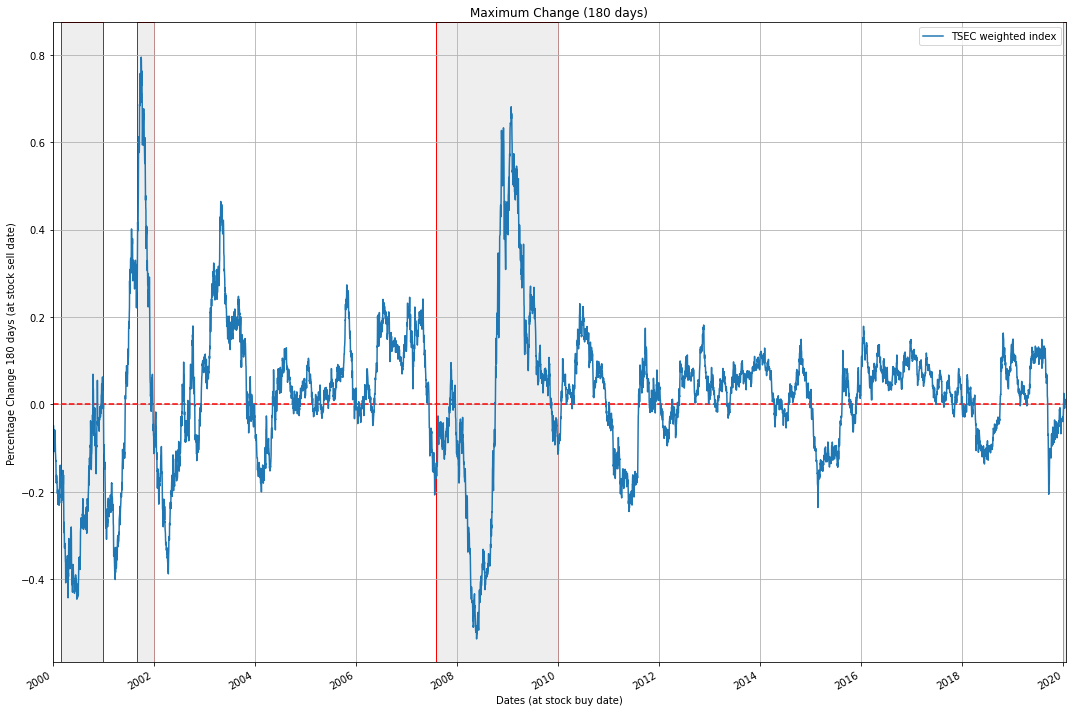

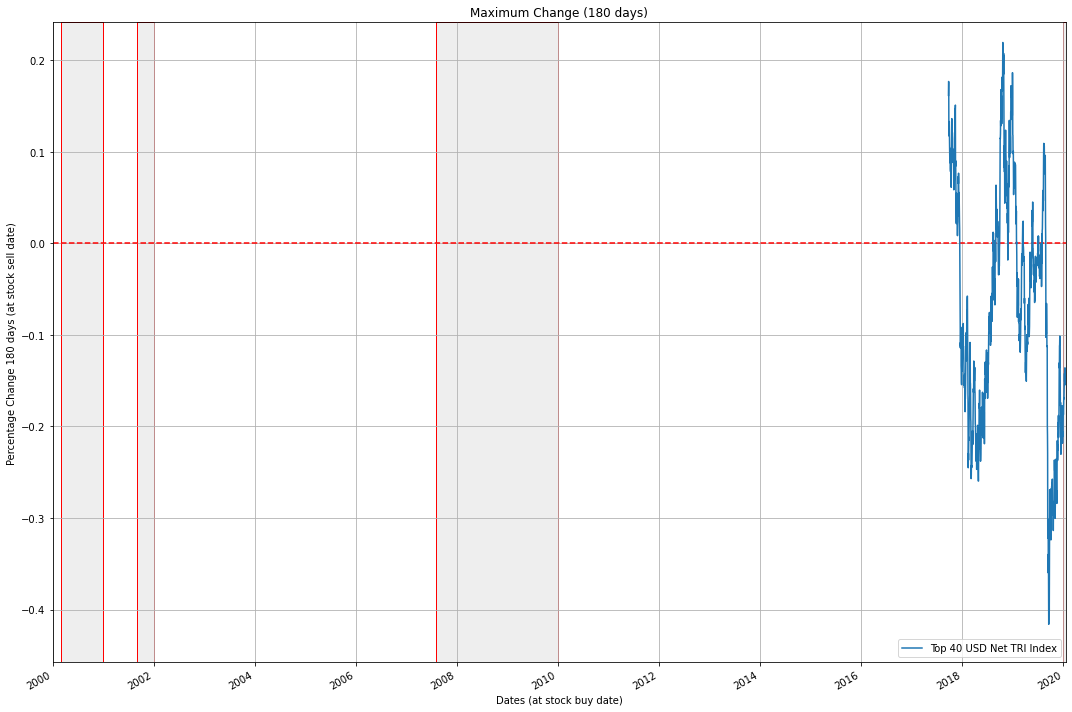

In [70]:
for stock in pivot.columns:
    buy_sell_pctchange(pivot, stock, filename=stock)

# Correlation

Text(294.0, 0.5, 'World index')

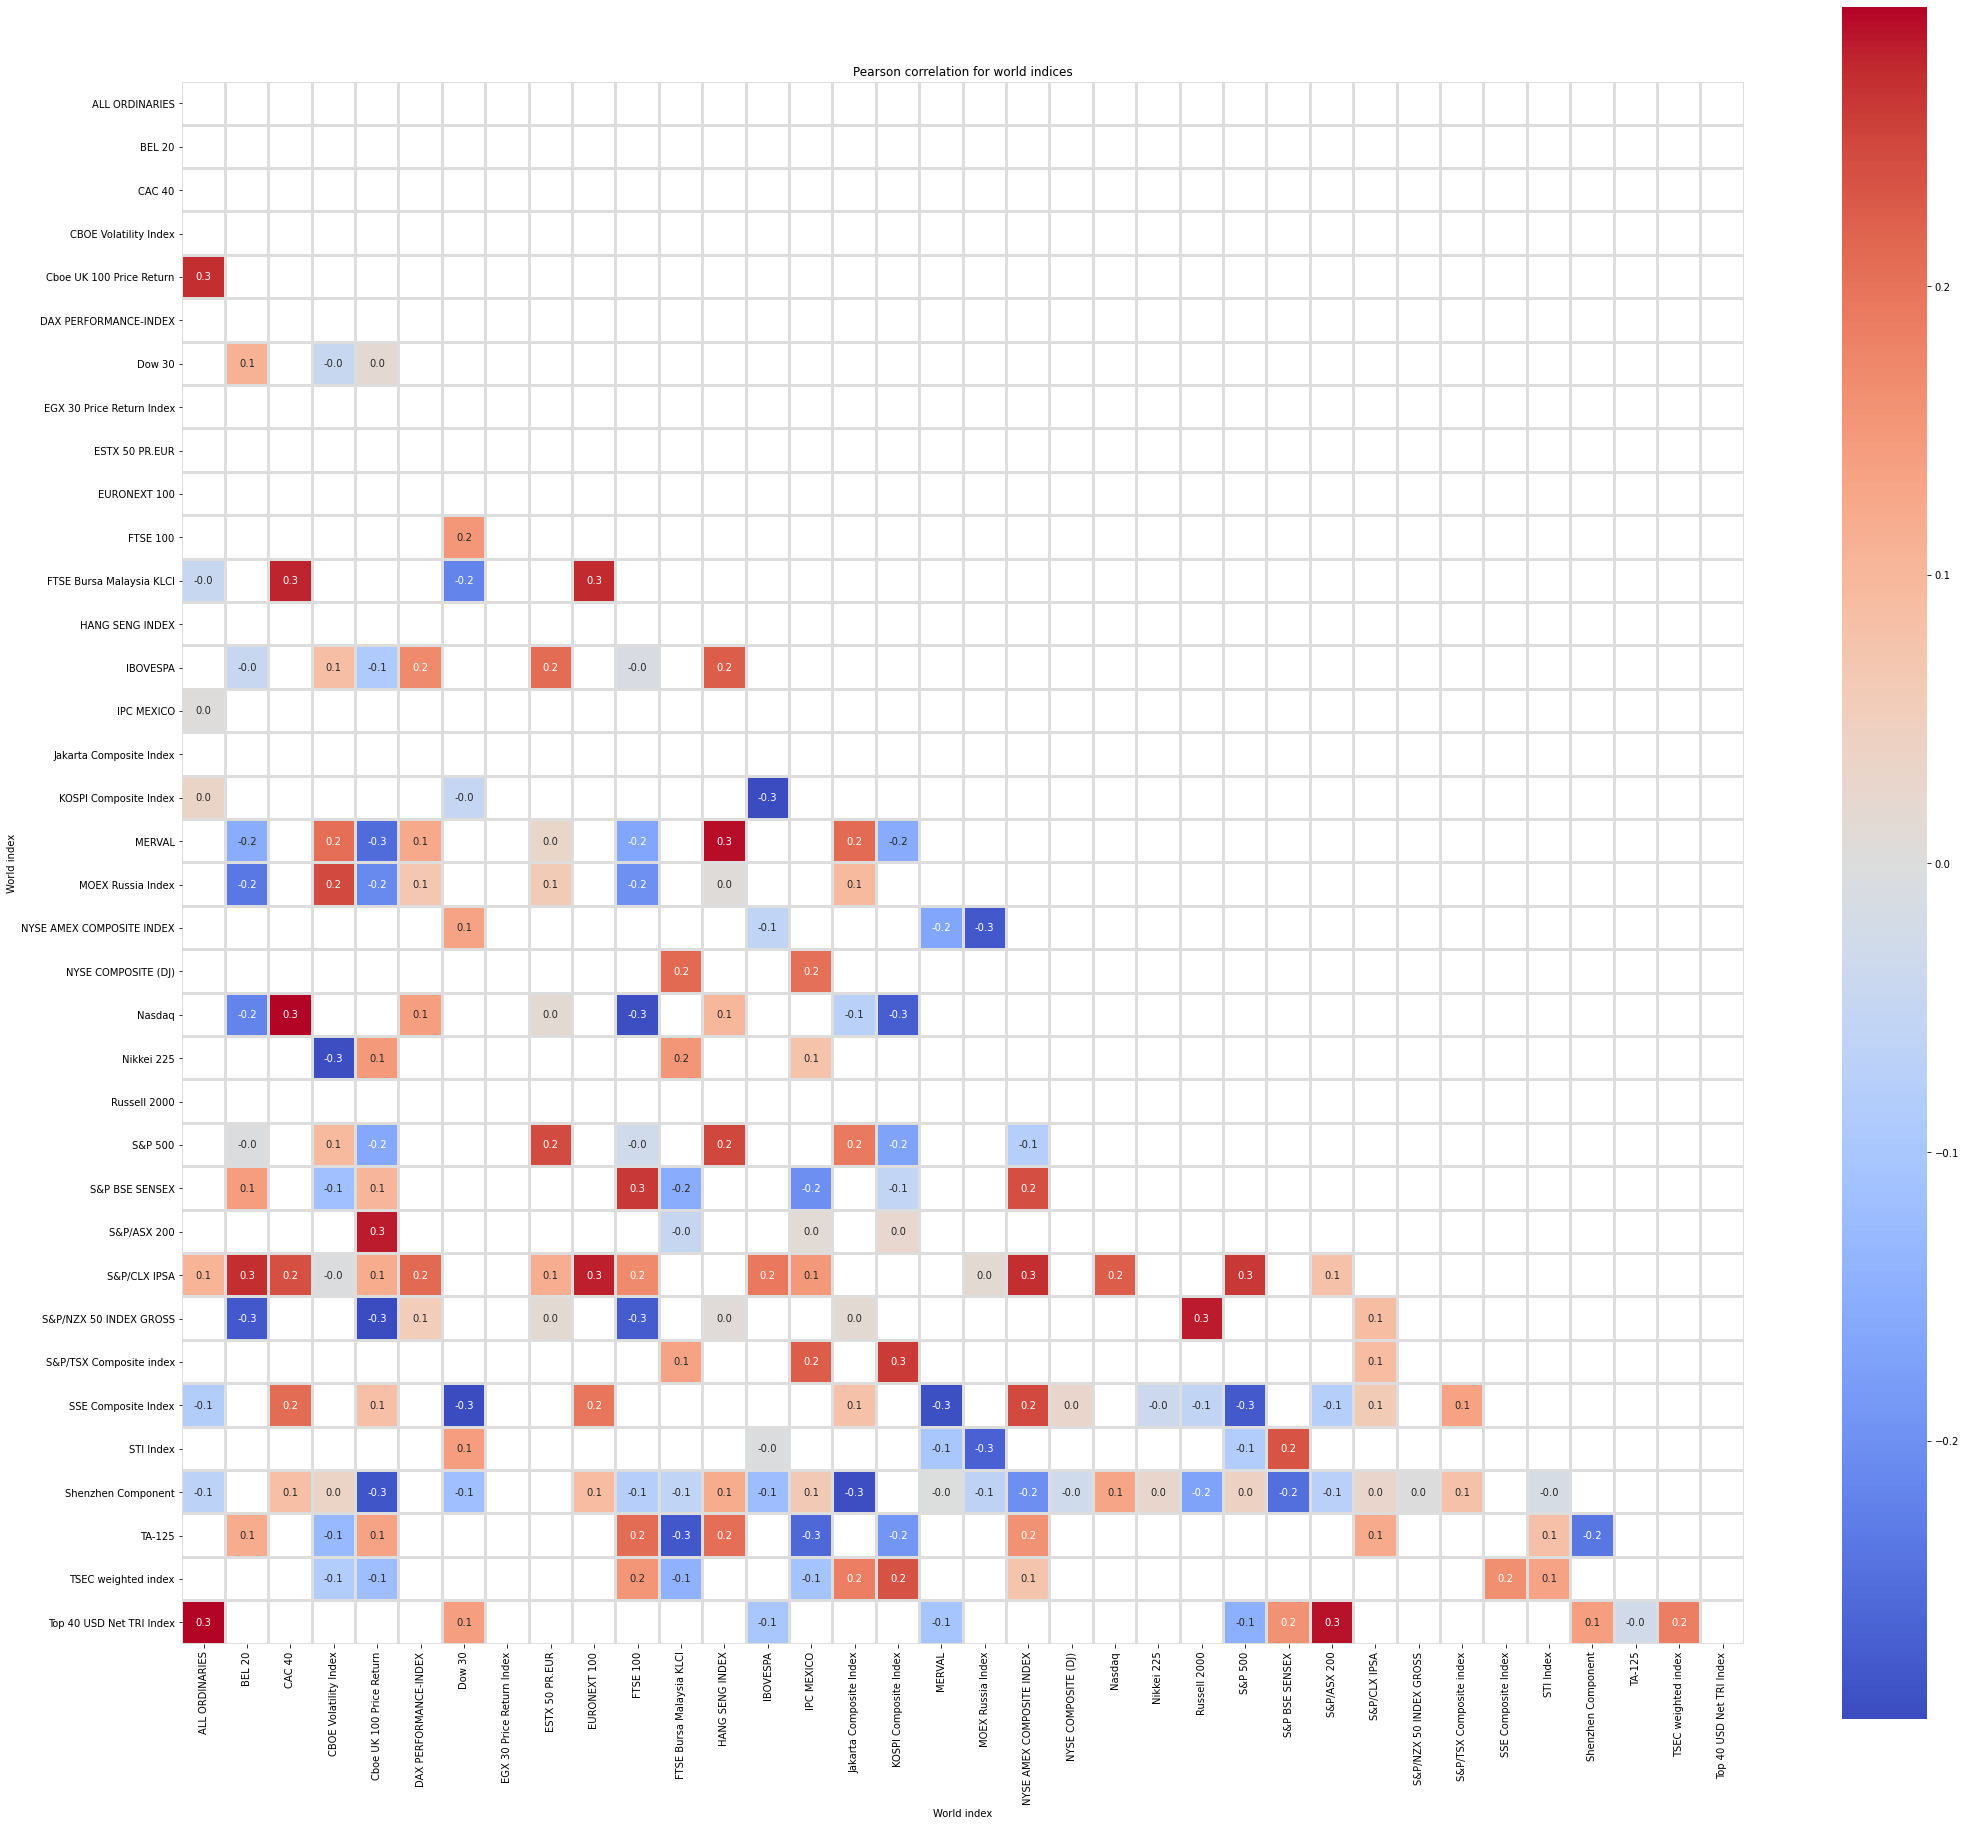

In [73]:
corr = pivot[pivot.index > '2017-01-01'].corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(35, 35))
sb.heatmap(corr[abs(corr)<0.3], mask=mask, center=0, annot=True,
           fmt='.1f', square=True, linewidths=2, linecolor='#DDDDDD',
           cmap='coolwarm', 
           cbar_kws={"shrink": .9})
plt.title('Pearson correlation for world indices');
plt.xlabel('World index')
plt.ylabel('World index')

# Volatility estimates

In [208]:
# if values are divided pivot_map[col], one receives the approximate 
# volatility per stock in indices (without weighting)

pivot_map = dict(windices[['Name', 'n_components']].values)
pivot_mean = None
pivot_std = None
for _, col in enumerate(pivot.columns):
    if _ == 0:       
        pivot_std = pivot.groupby([pd.to_datetime(pivot.index).year]
                            )[col].std().to_frame() #/ pivot_map[col]
        pivot_mean = pivot.groupby([pd.to_datetime(pivot.index).year]
                            )[col].mean().to_frame() #/ pivot_map[col]
    else:
        pivot_std_tmp = pivot.groupby([pd.to_datetime(pivot.index).year]
                            )[col].std().to_frame() #/ pivot_map[col]
        pivot_mean_tmp = pivot.groupby([pd.to_datetime(pivot.index).year]
                            )[col].mean().to_frame() #/ pivot_map[col]
        pivot_std = pd.concat([pivot_std, pivot_std_tmp], axis=1)
        pivot_mean = pd.concat([pivot_mean, pivot_mean_tmp], axis=1)

pivot_std.columns = [c+'_std' for c in  pivot_std]
pivot_mean.columns = [c+'_mean' for c in  pivot_mean]
volatility = pd.concat([pivot_mean, pivot_std], axis=1)

for col in pivot.columns:
    volatility[col+'_pct'] = volatility[col+'_std'] / full[col+'_mean']
    
volatility = volatility.loc[:, [c for c in full.columns if c.endswith('_pct')]]
volatility['year'] = volatility.index.copy()
volatility.index = pd.to_datetime(volatility.index, format='%Y')
volatility.head()

ALL ORDINARIES_pct  BEL 20_pct  CAC 40_pct  \
dates                                                    
2000-01-01            0.027614    0.044675    0.046411   
2001-01-01            0.031077    0.052423    0.109917   
2002-01-01            0.055014    0.143308    0.168521   
2003-01-01            0.052204    0.083855    0.079092   
2004-01-01            0.057765    0.072951    0.021580   

            CBOE Volatility Index_pct  Cboe UK 100 Price Return_pct  \
dates                                                                 
2000-01-01                   0.148920                           NaN   
2001-01-01                   0.186200                           NaN   
2002-01-01                   0.252269                           NaN   
2003-01-01                   0.237775                           NaN   
2004-01-01                   0.122968                           NaN   

            DAX PERFORMANCE-INDEX_pct  Dow 30_pct  \
dates                                               
2000-01-01                   0.055516    0.033501   
2001-01-01                   0.127439    0.061403   
2002-01-01                   0.214054    0.093897   
2003-01-01                   0.134625    0.078153   
2004-01-01                   0.034153    0.023794   

            EGX 30 Price Return Index_pct  ESTX 50 PR.EUR_pct  \
dates                                                           
2000-01-01                            NaN                 NaN   
2001-01-01                            NaN                 NaN   
2002-01-01                            NaN                 NaN   
2003-01-01                            NaN                 NaN   
2004-01-01                            NaN                 NaN   

            EURONEXT 100_pct  FTSE 100_pct  FTSE Bursa Malaysia KLCI_pct  \
dates                                                                      
2000-01-01          0.043525      0.025513                      0.110801   
2001-01-01          0.101011      0.074811                      0.075736   
2002-01-01          0.162799      0.120782                      0.070881   
2003-01-01          0.074630      0.064630                      0.085998   
2004-01-01          0.022877      0.029048                      0.040454   

            HANG SENG INDEX_pct  IBOVESPA_pct  IPC MEXICO_pct  \
dates                                                           
2000-01-01             0.067866      0.082582        0.101783   
2001-01-01             0.145547      0.134716        0.067256   
2002-01-01             0.072820      0.148221        0.087910   
2003-01-01             0.123711      0.228296        0.127027   
2004-01-01             0.057114      0.078787        0.086636   

            Jakarta Composite Index_pct  KOSPI Composite Index_pct  \
dates                                                                
2000-01-01                     0.155258                   0.195933   
2001-01-01                     0.073865                   0.086422   
2002-01-01                     0.122721                   0.104985   
2003-01-01                     0.181304                   0.123145   
2004-01-01                     0.101720                   0.062796   

            MERVAL_pct  MOEX Russia Index_pct  NYSE AMEX COMPOSITE INDEX_pct  \
dates                                                                          
2000-01-01    0.132910                    NaN                       0.045690   
2001-01-01    0.273319                    NaN                       0.051307   
2002-01-01    0.135921                    NaN                       0.054181   
2003-01-01    0.203445                    NaN                       0.107653   
2004-01-01    0.119305                    NaN                       0.051445   

            NYSE COMPOSITE (DJ)_pct  Nasdaq_pct  Nikkei 225_pct  \
dates                                                             
2000-01-01                 0.032482    0.156847        0.112358   
2001-01-01                 0.058042  

In [200]:
def plot_volatility(df, stock, filename=None):
    """
    DOCSTRING
    """
    max_height = df[stock].dropna().max()*1.1
    min_height = df[stock].dropna().min()*1.1
    if np.isnan(max_height):
        max_height = 1
    if np.isnan(min_height):
        min_height = 0
             
    fig, ax = plt.subplots(figsize=(15, 10), tight_layout=True)
    df[stock].plot(figsize=(15, 10), alpha=0.5, ax=ax)
    ax.scatter(df.index, df[stock])
    ax.set_ylim([min_height, max_height])
    ax.set_xlim([df.index.min(), df.index.max()])
    ax.set_xlabel('Dates')
    ax.set_title('Stock: {}'.format(stock.replace('_pct', '')))
    ax.set_ylabel('Volatility (yearly)')
    plt.grid()
    ax.legend()
    
    if filename is not None:
        title = re.sub('[^0-9a-zA-Z]+', '_', stock)
        plt.savefig('indices/volatility_{}_{}.png'.format(title, delta), dpi=150, format='png',
            bbox_inches='tight')
    plt.show()

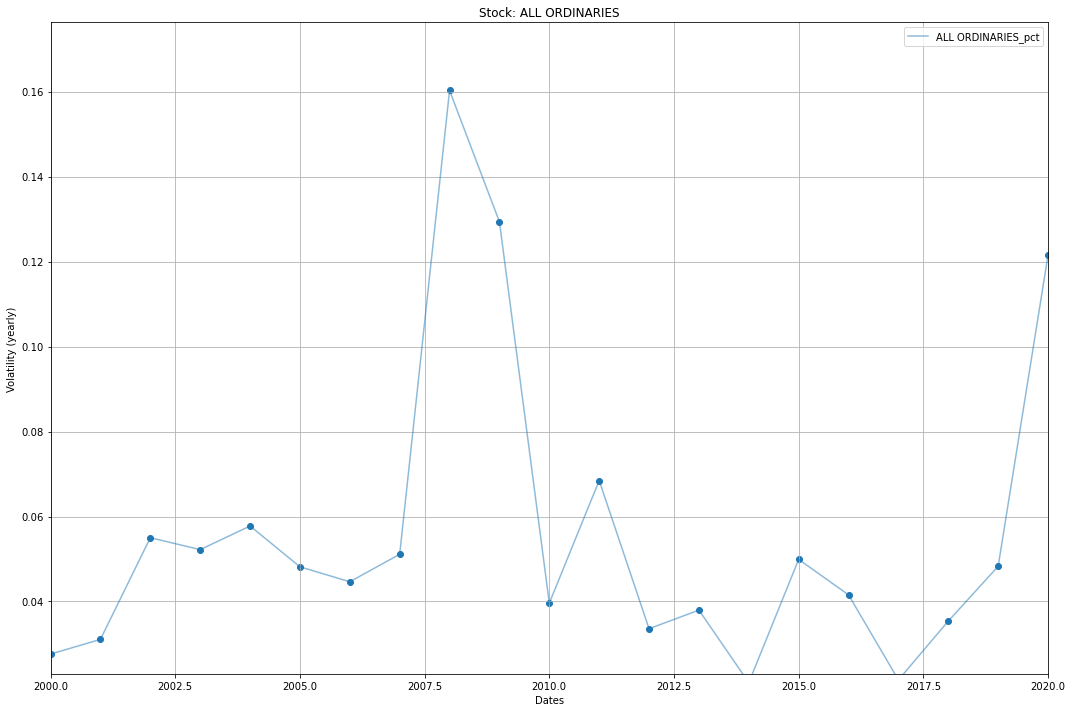

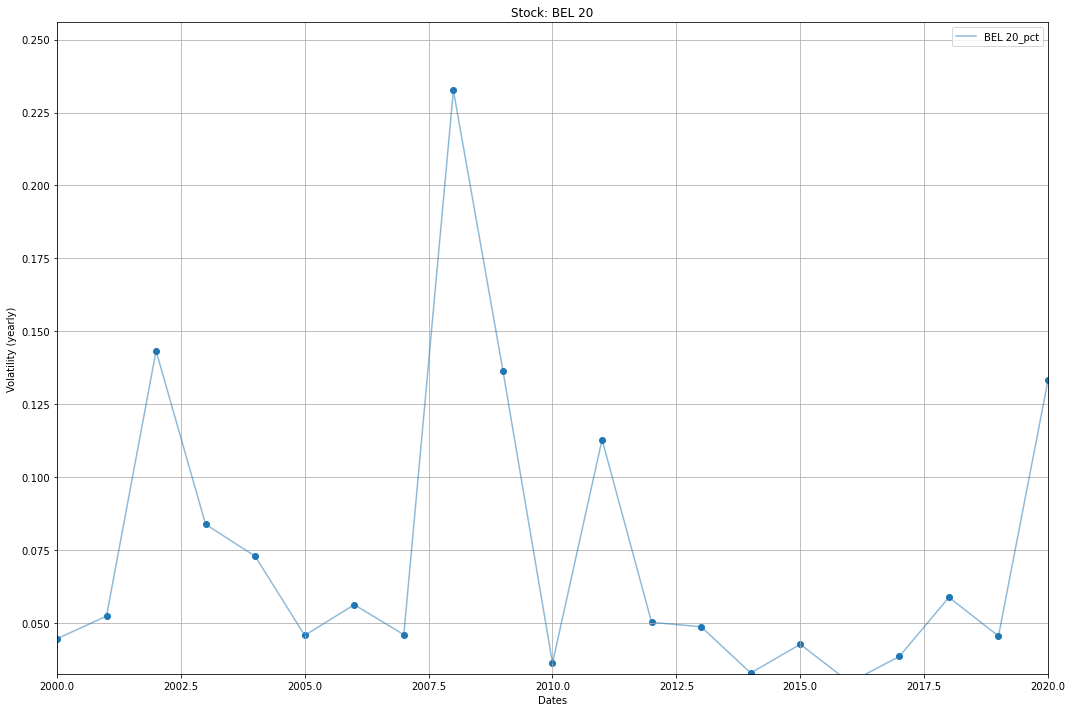

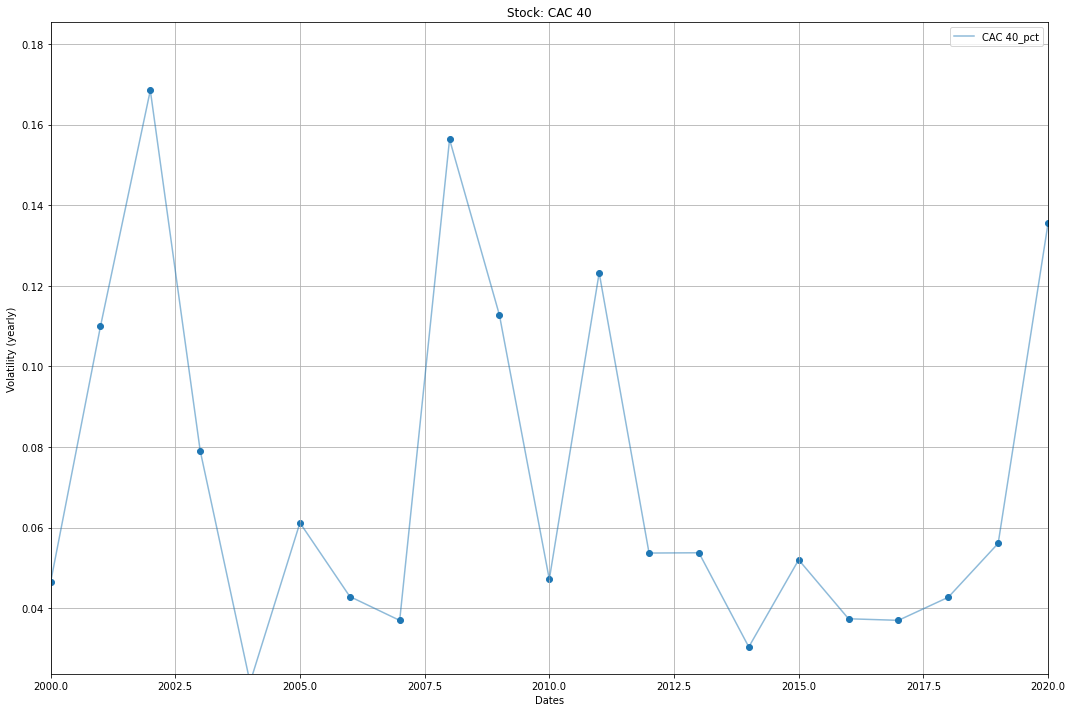

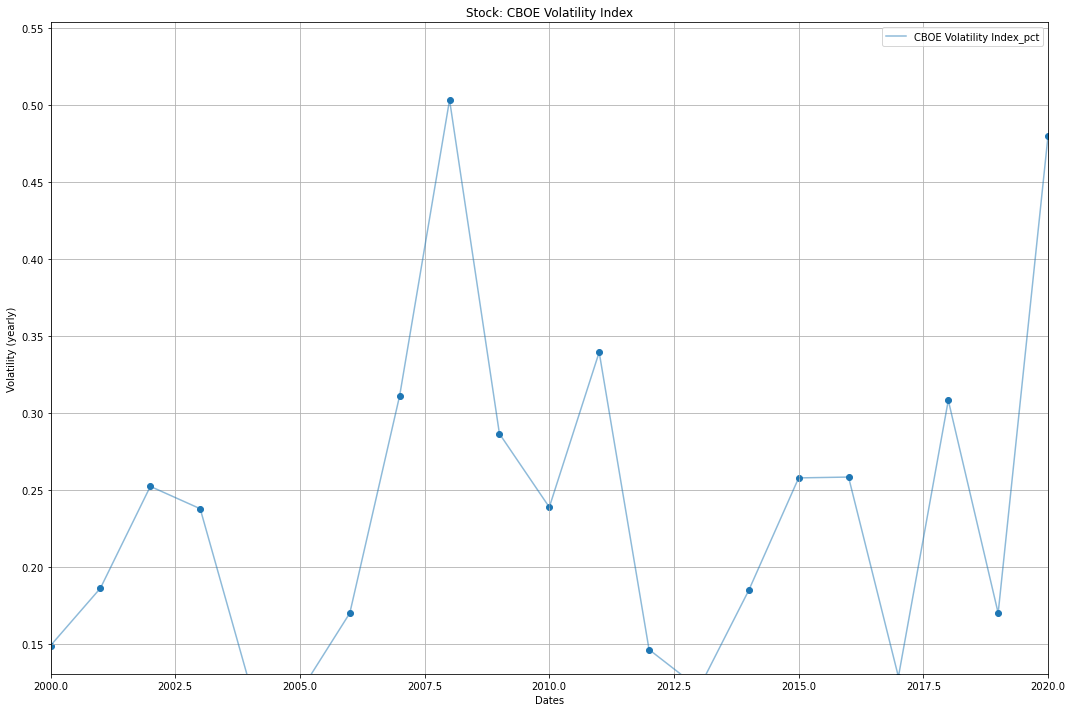

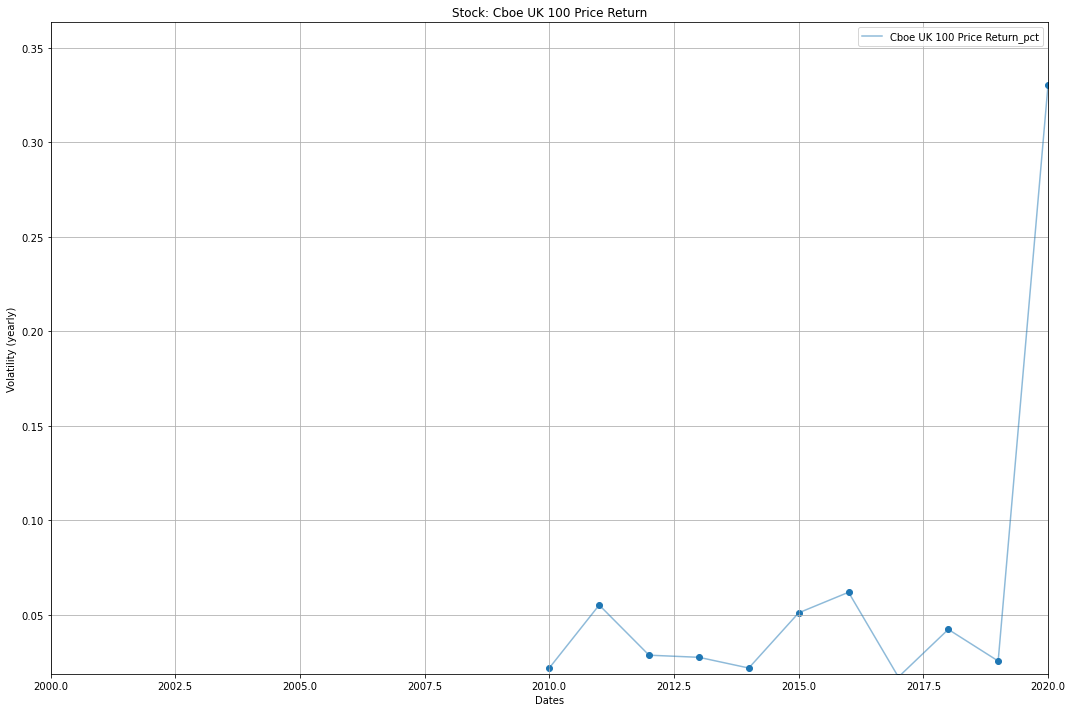

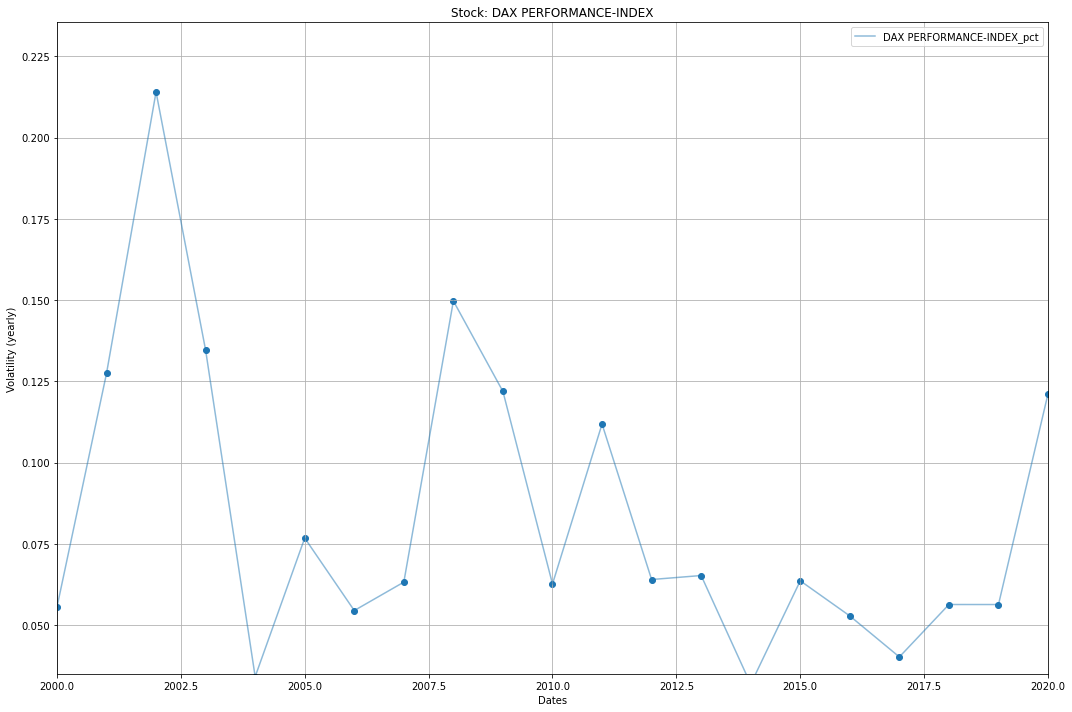

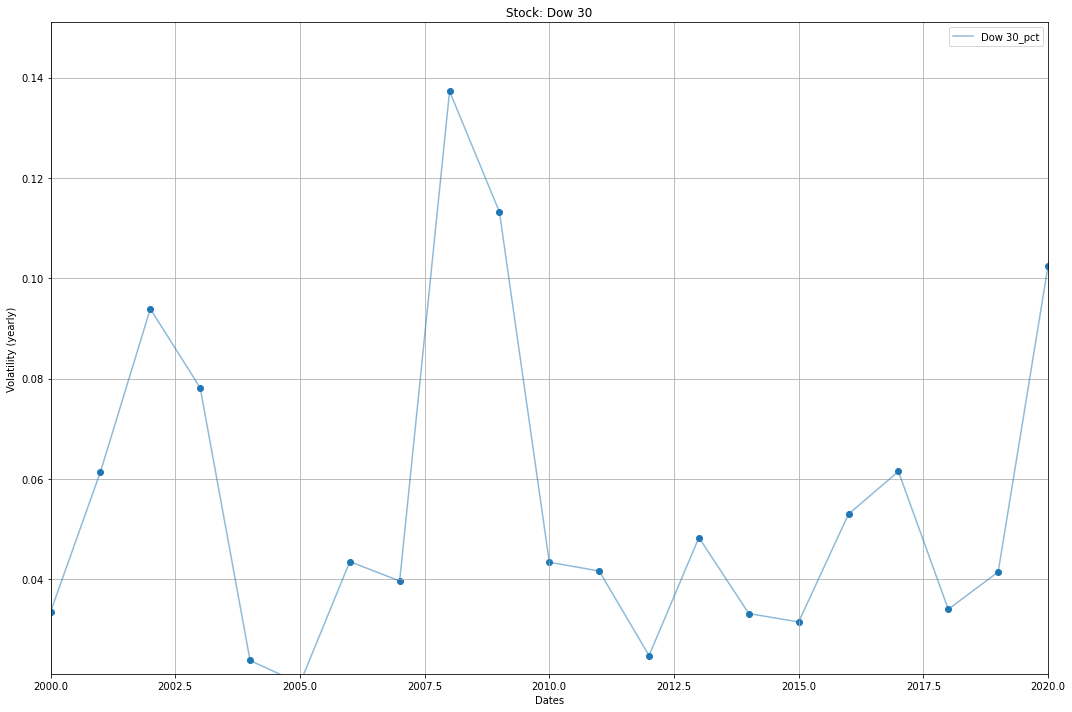

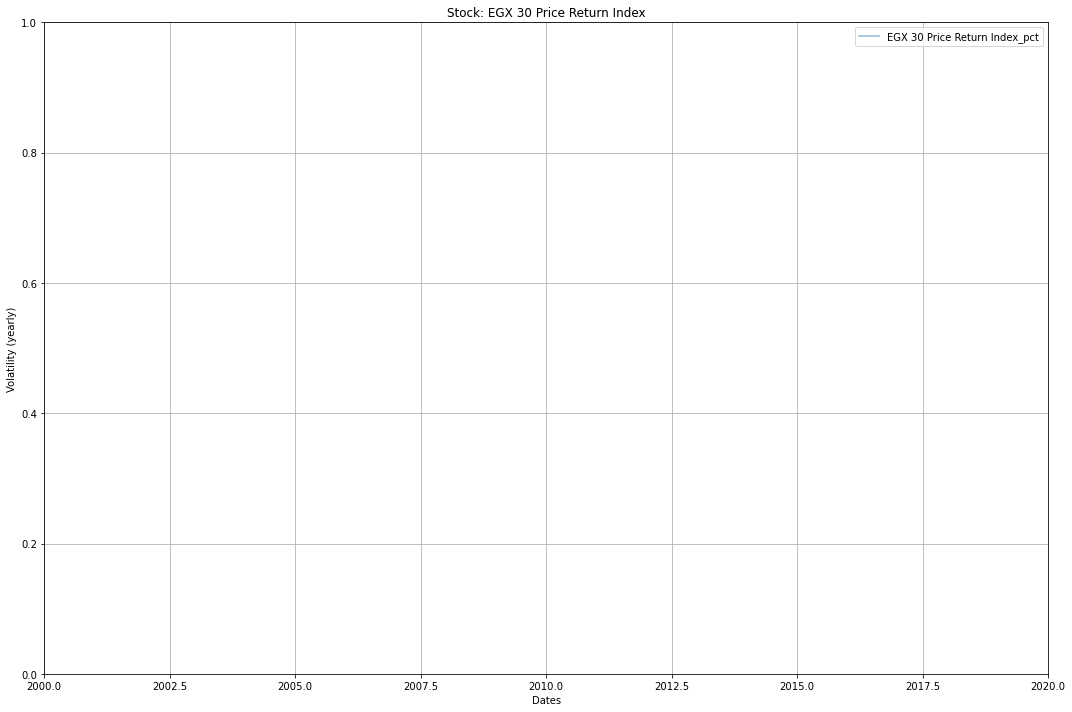

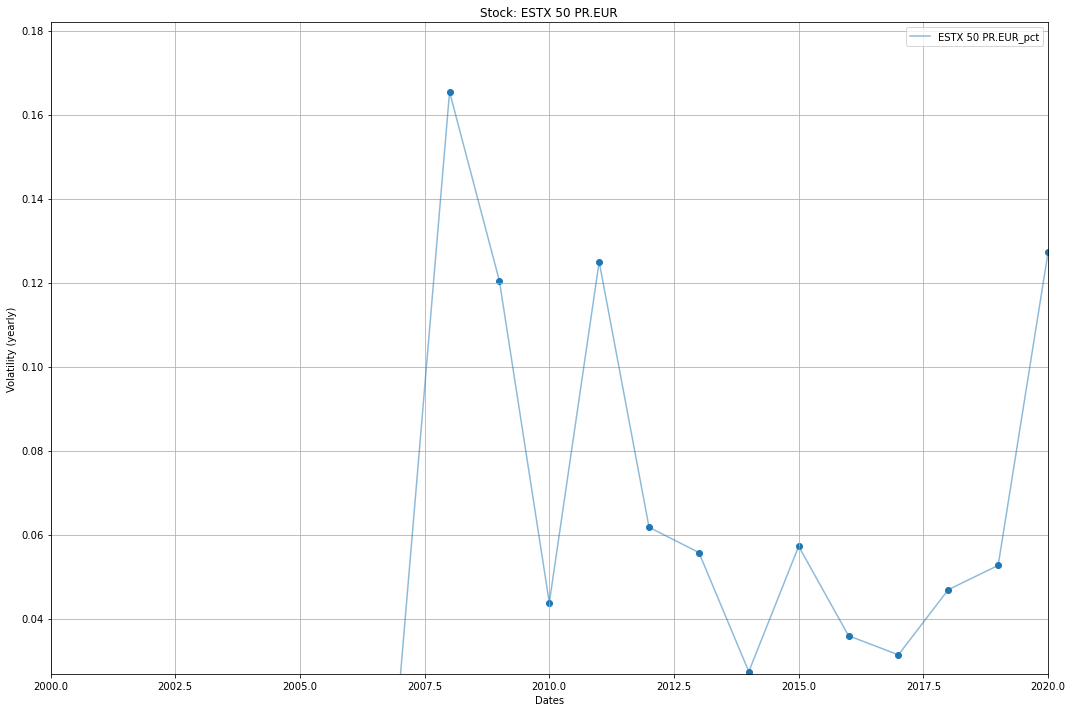

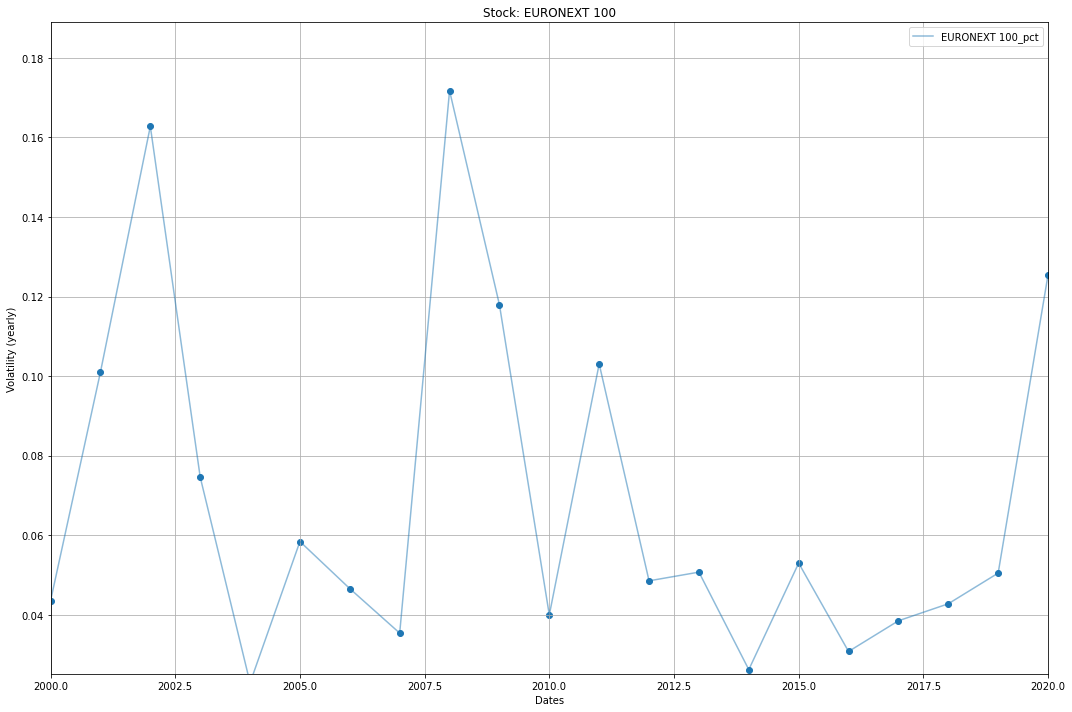

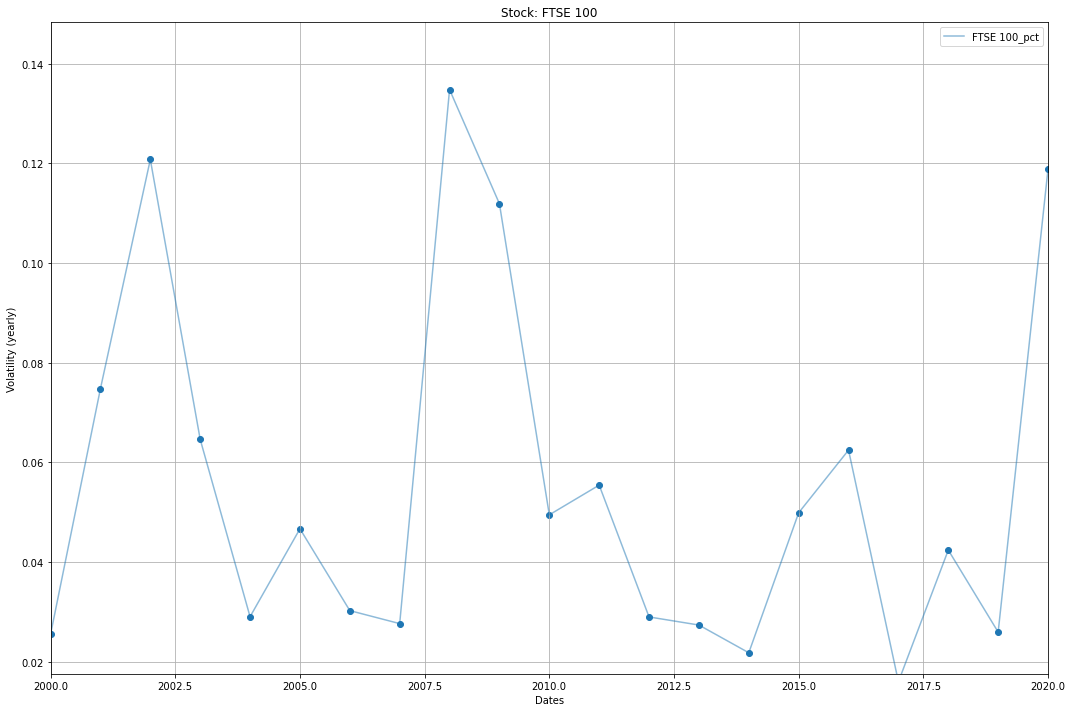

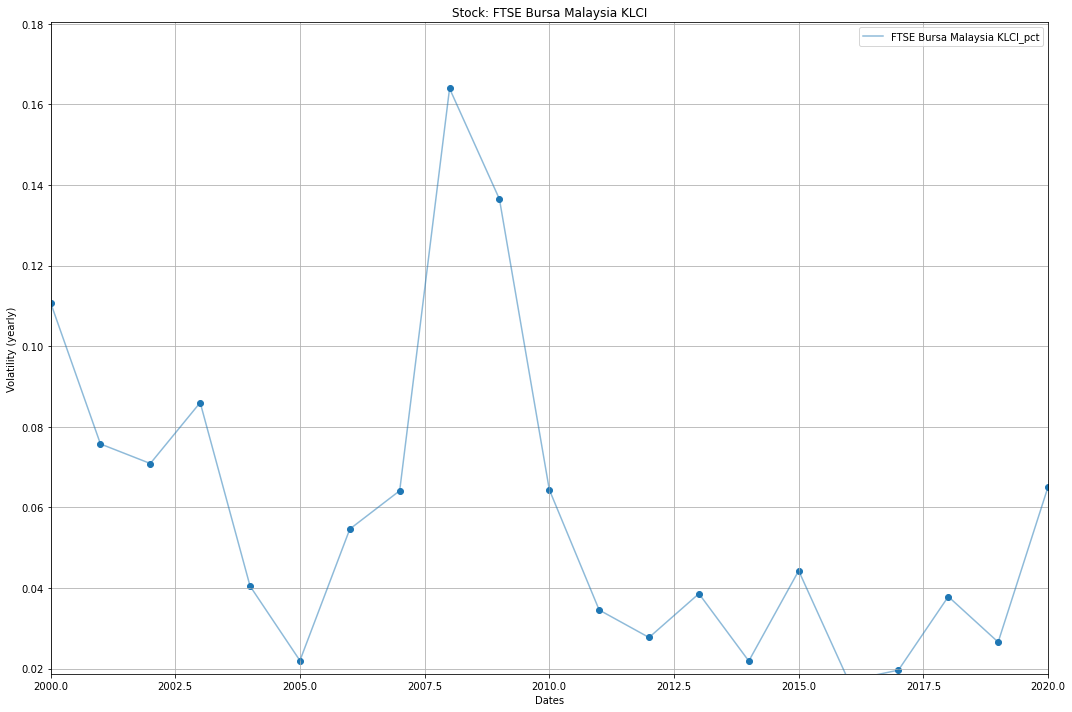

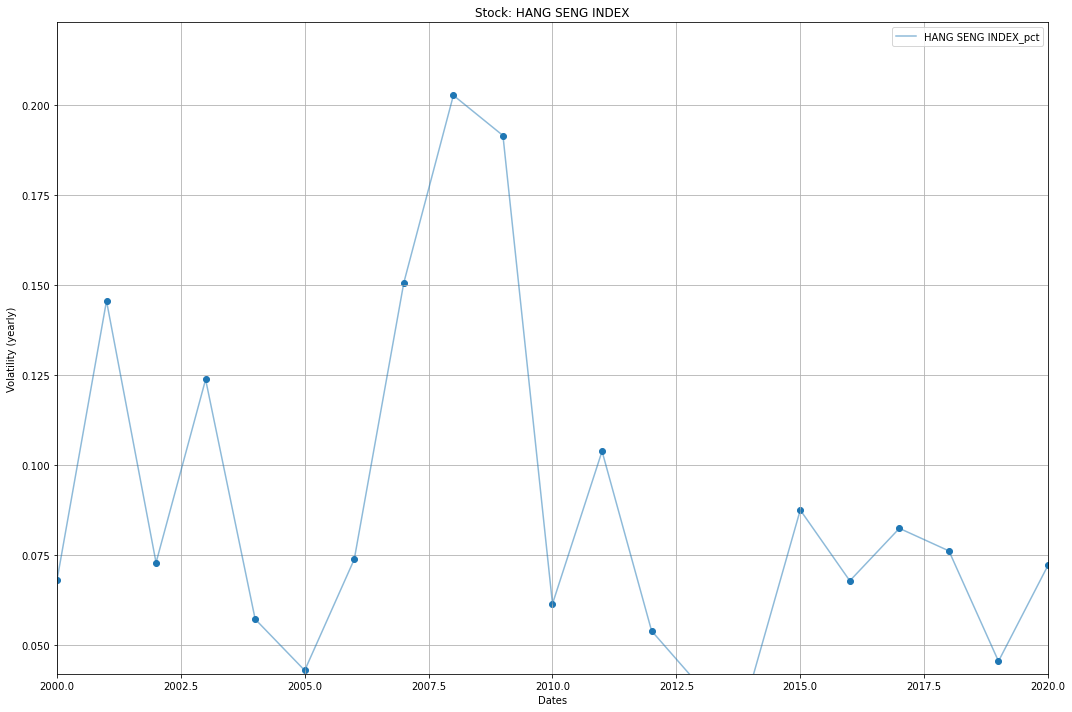

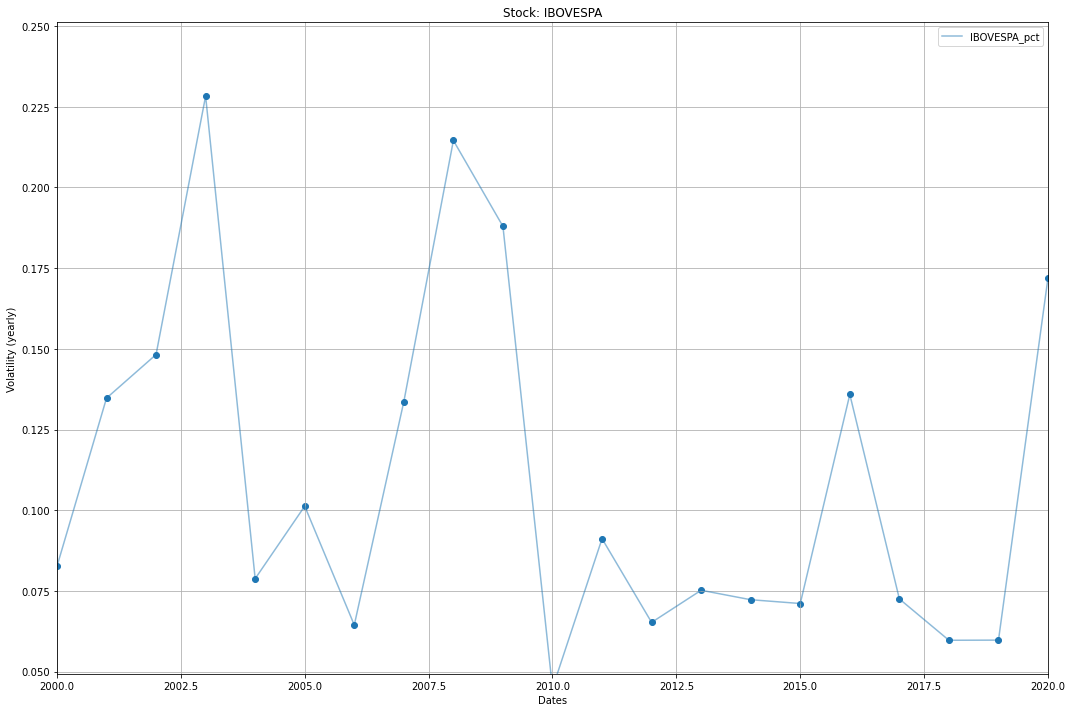

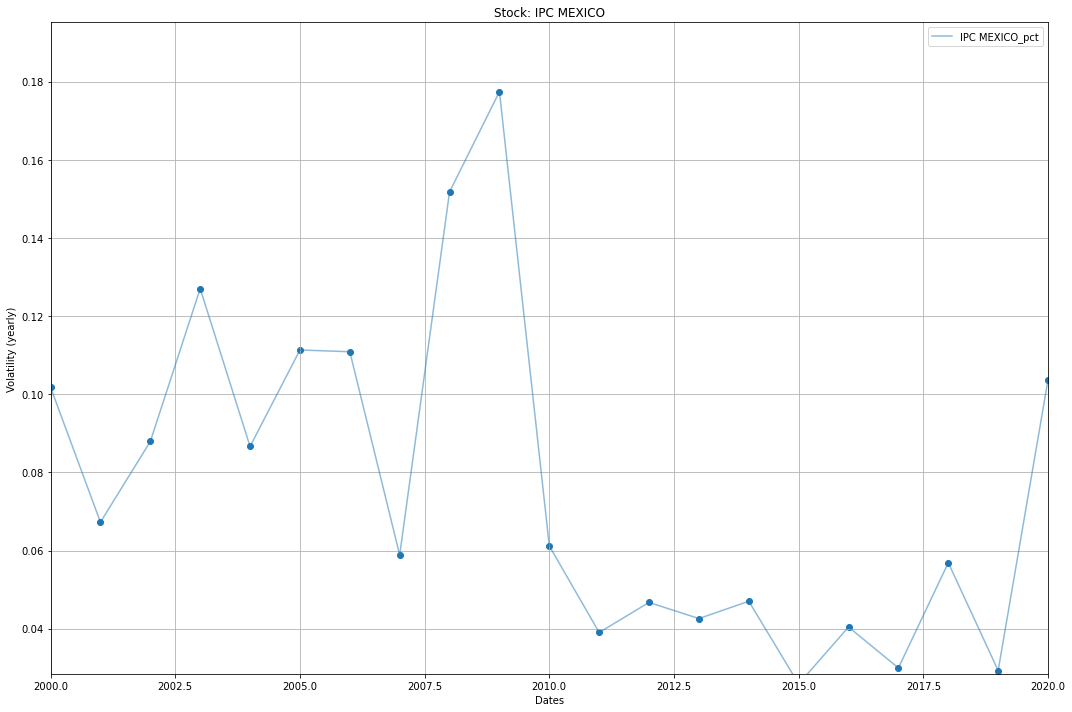

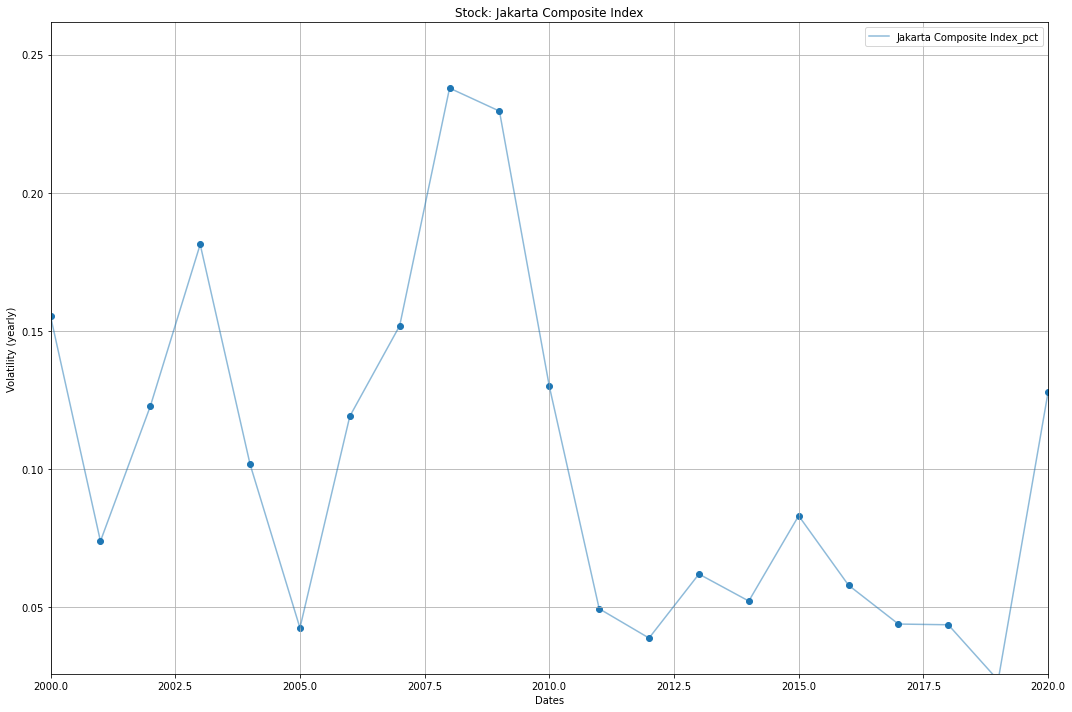

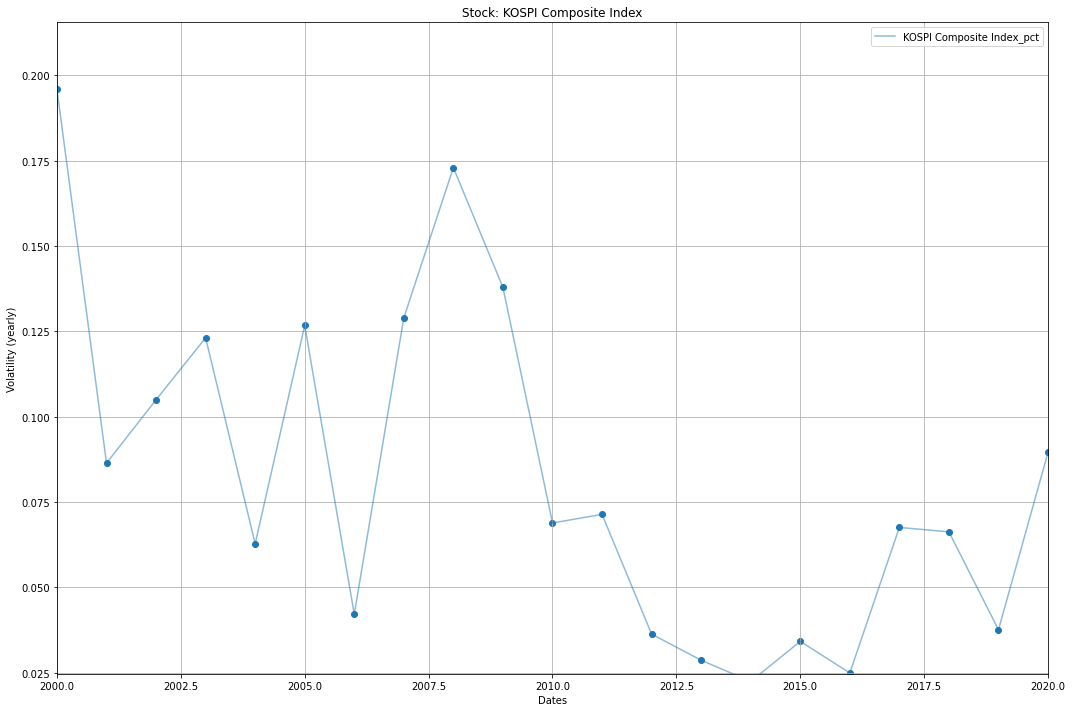

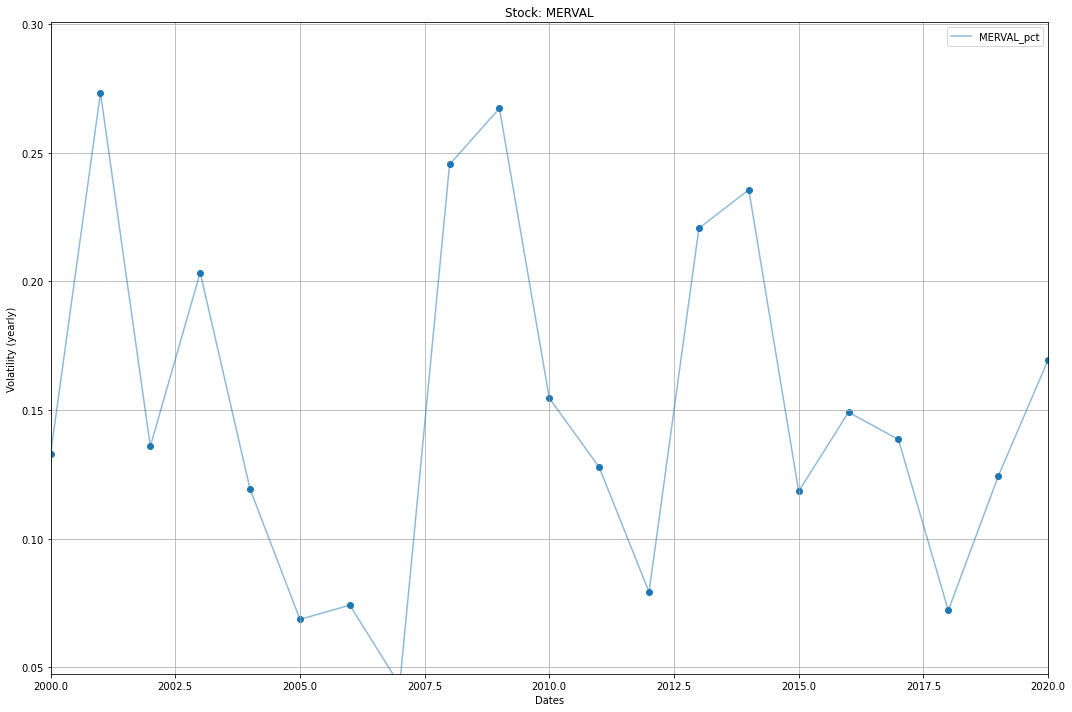

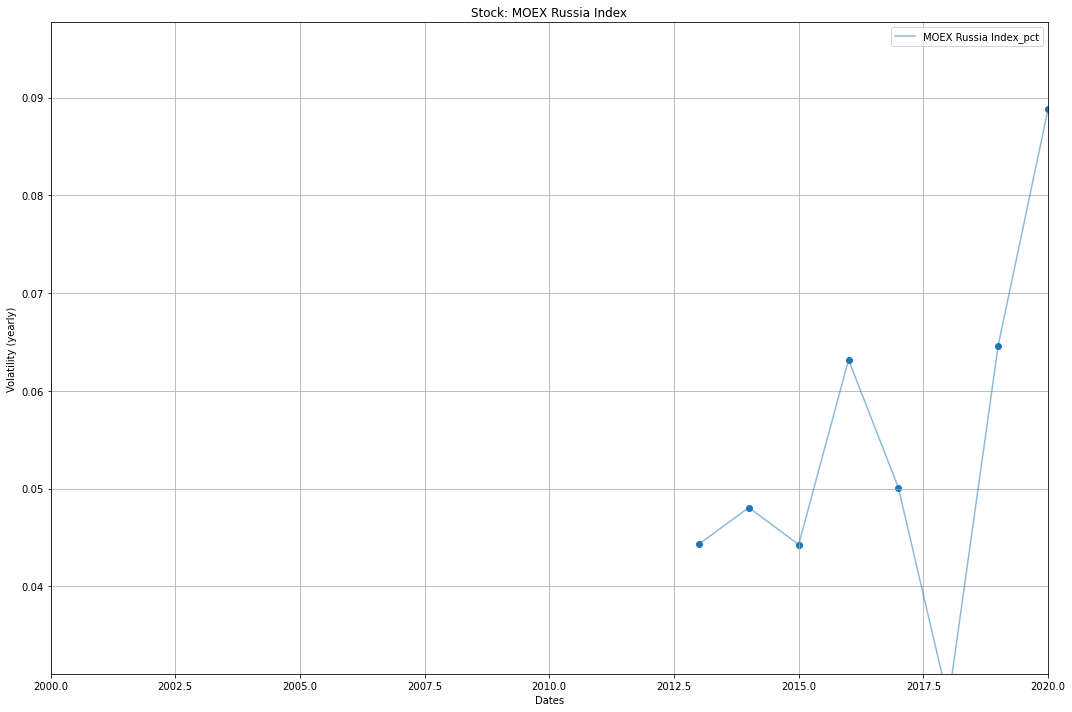

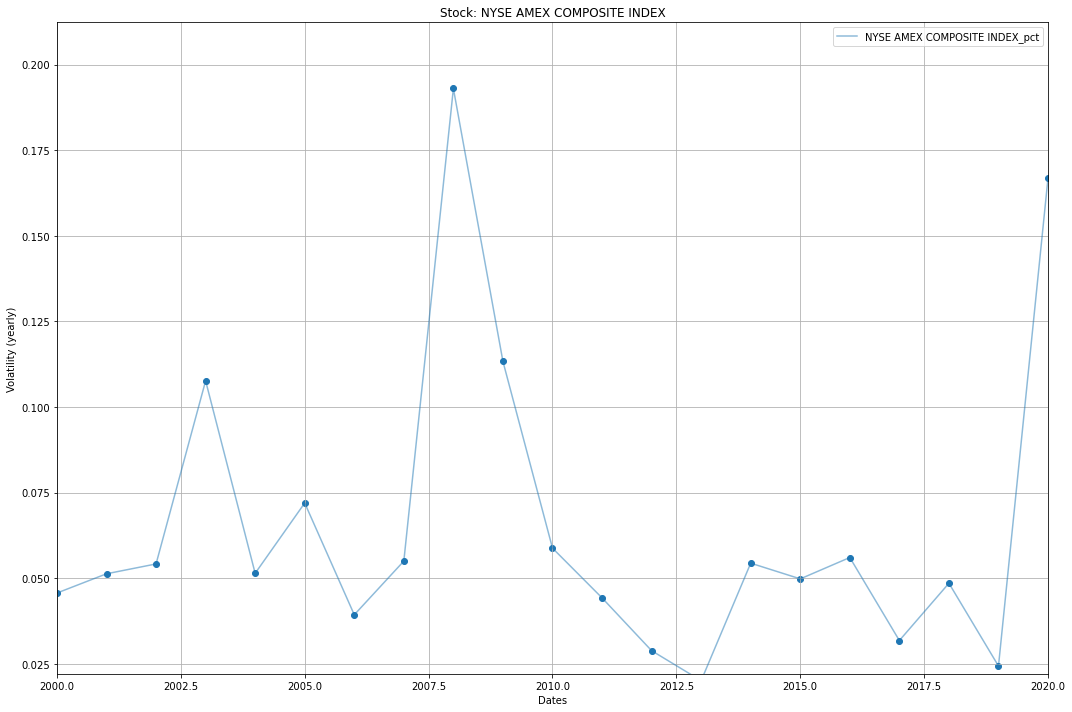

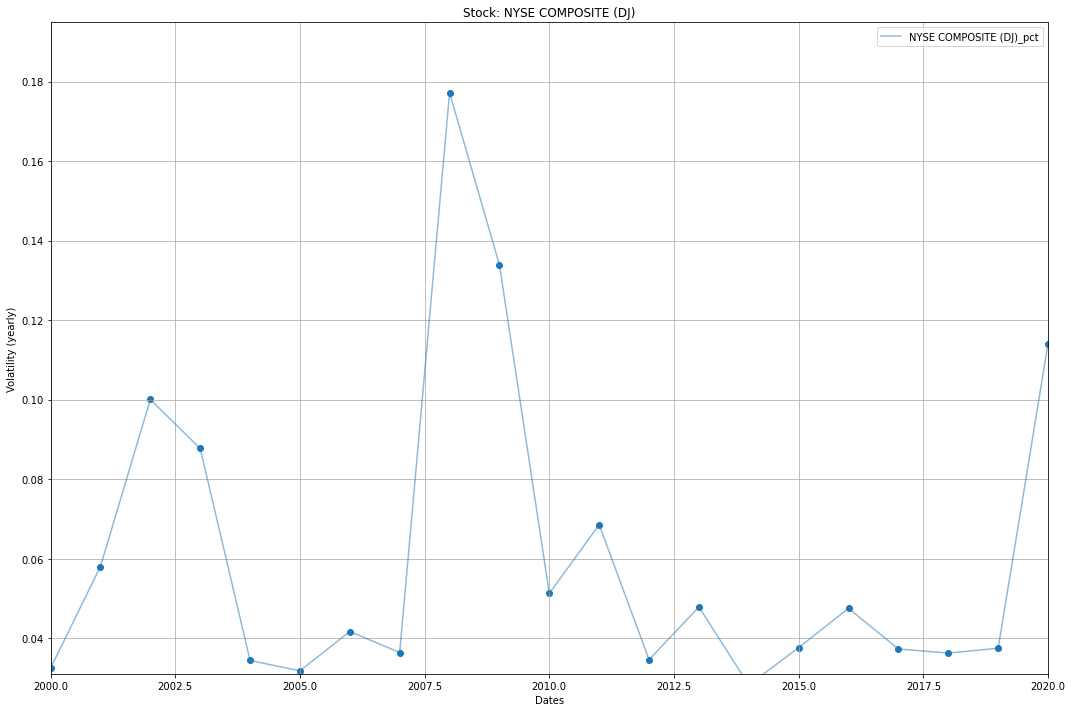

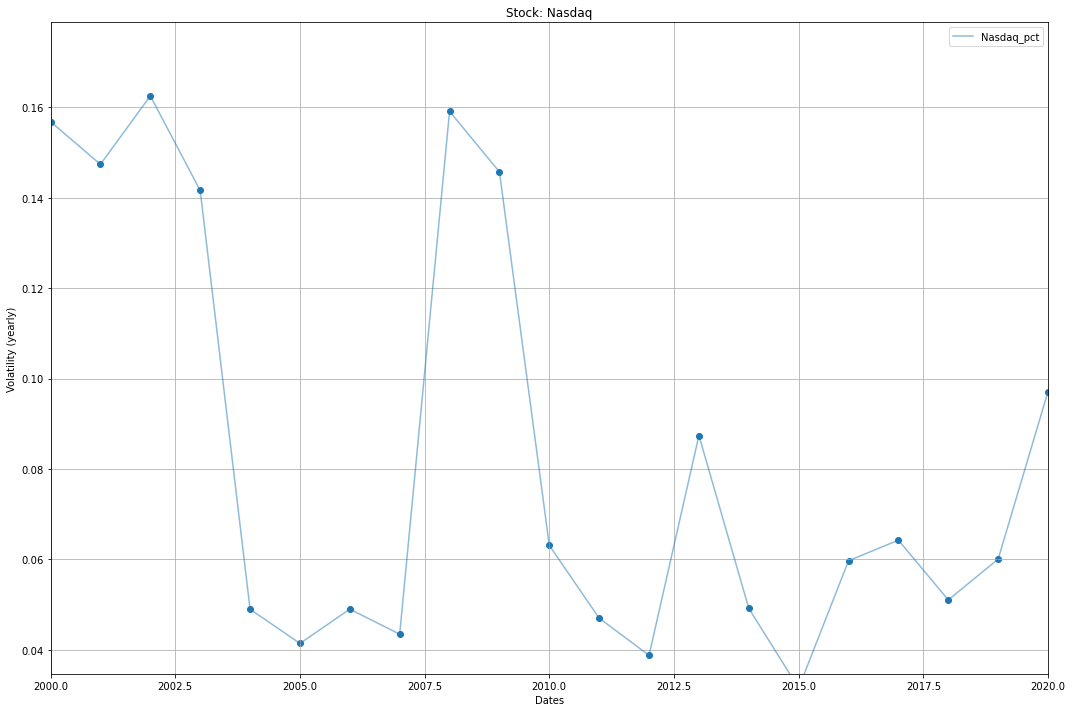

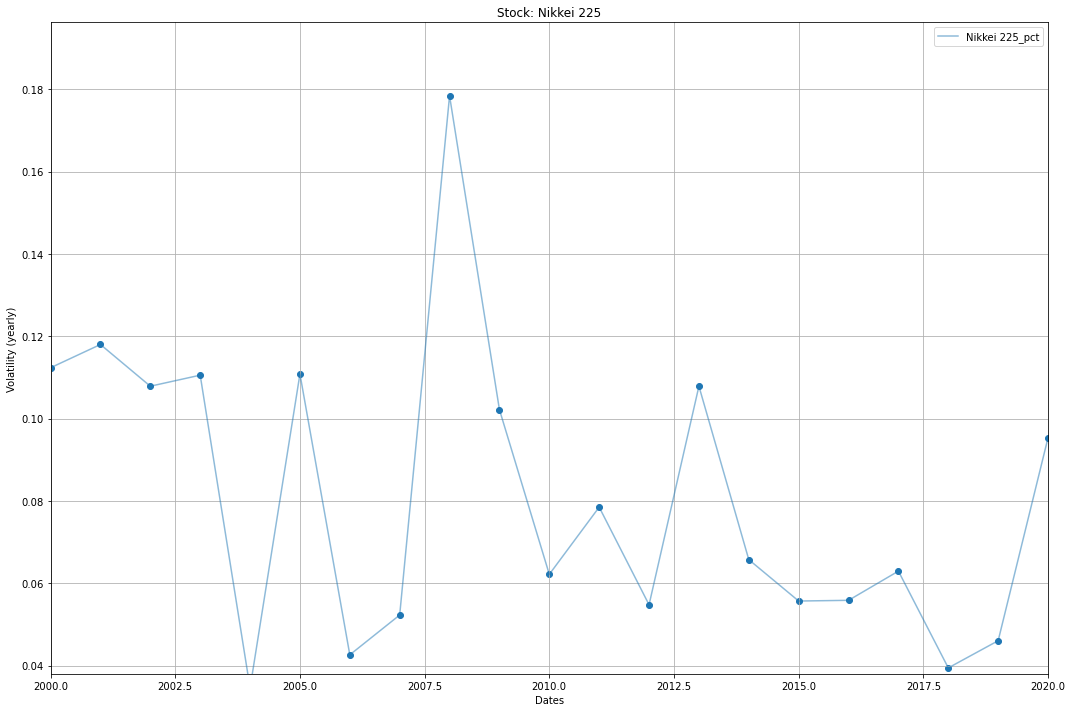

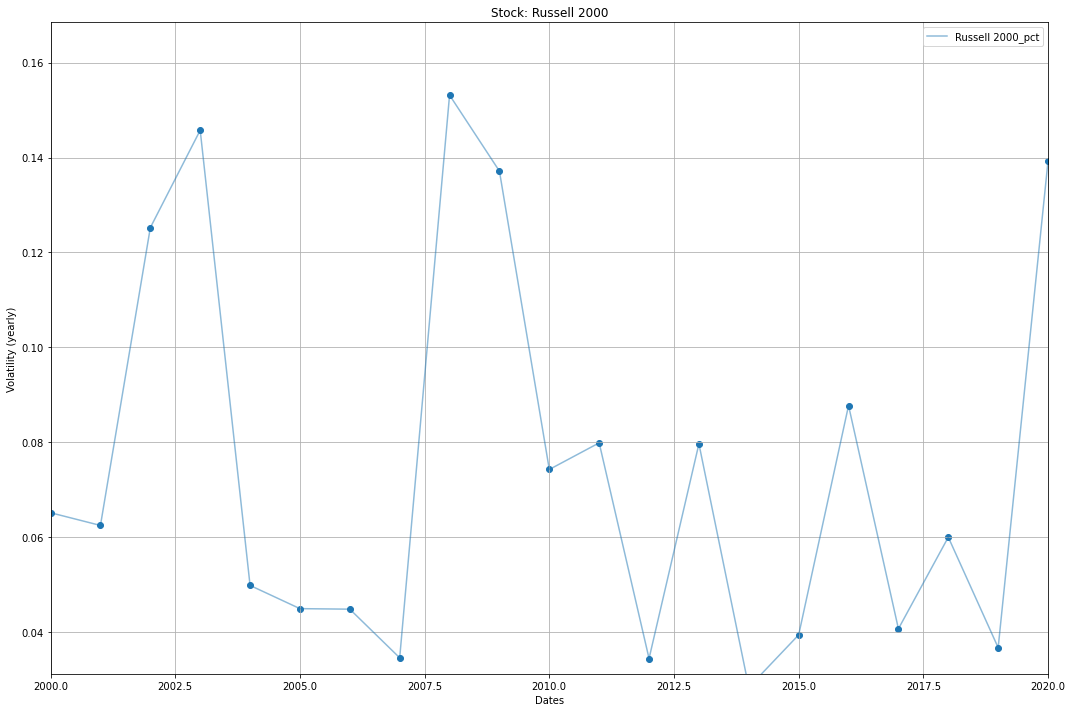

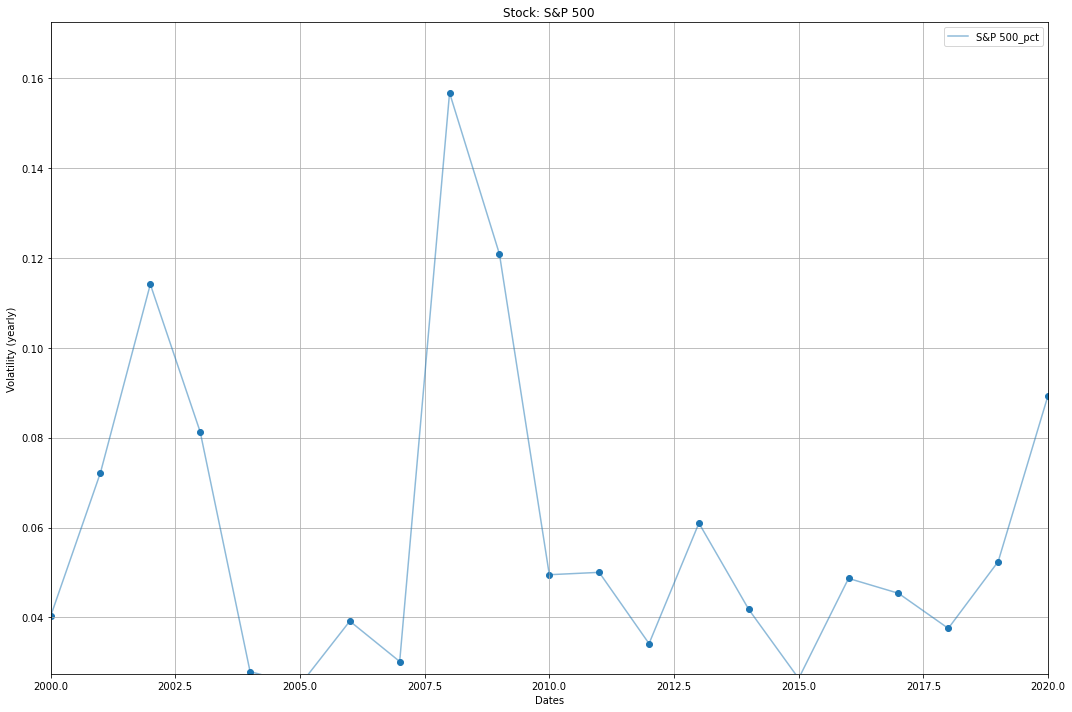

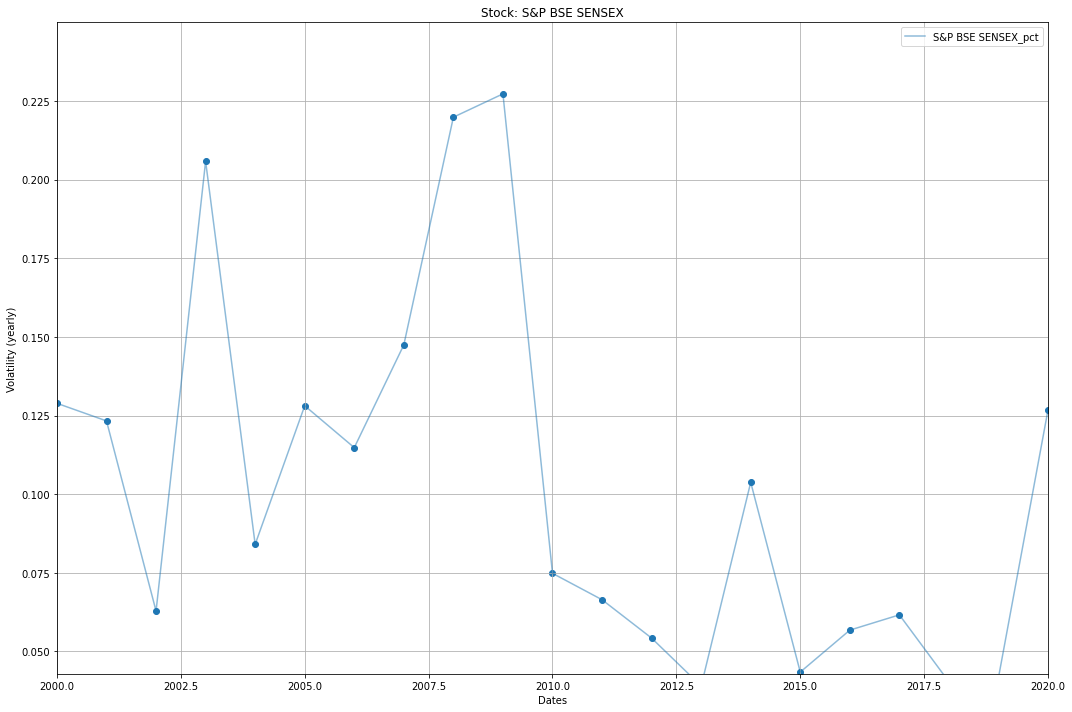

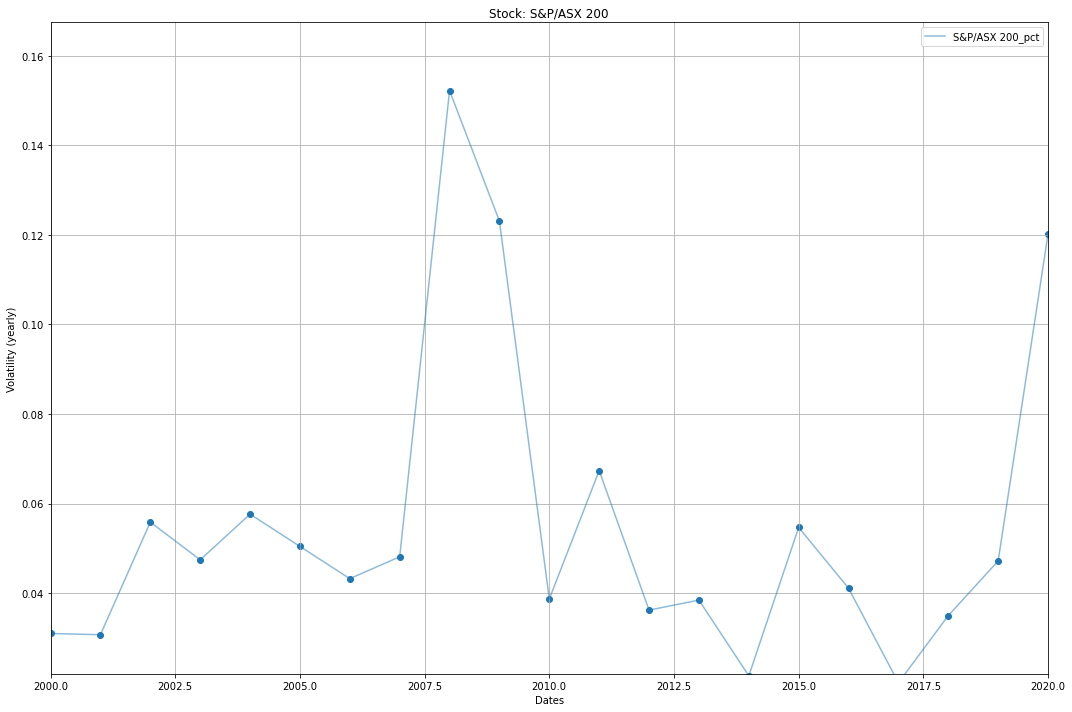

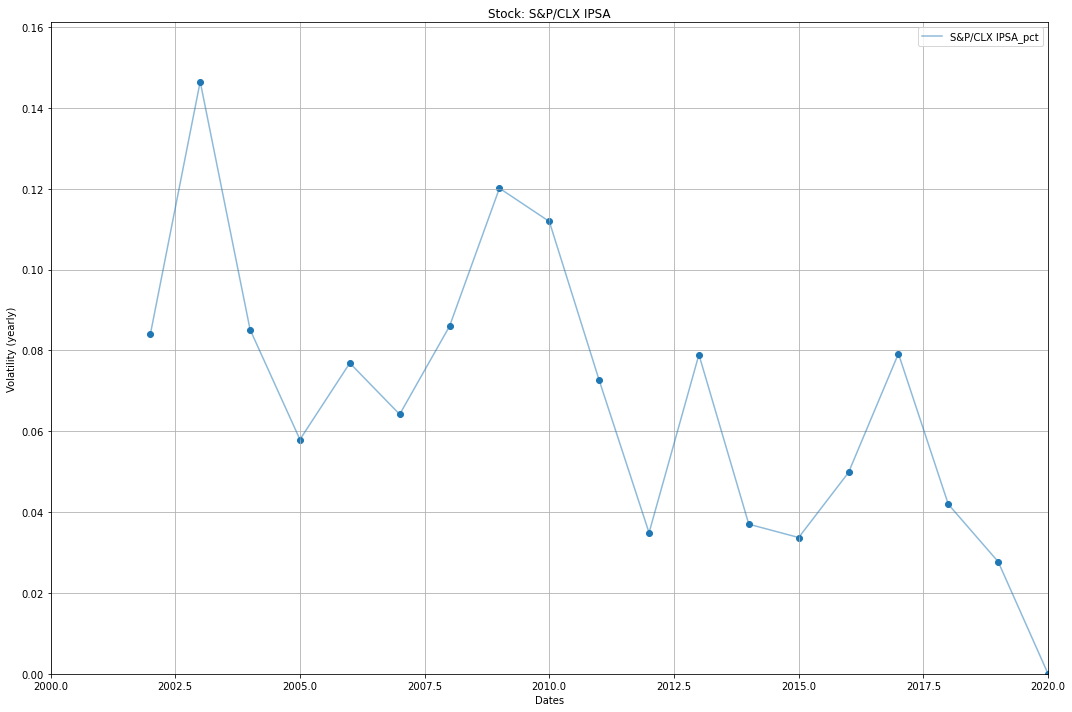

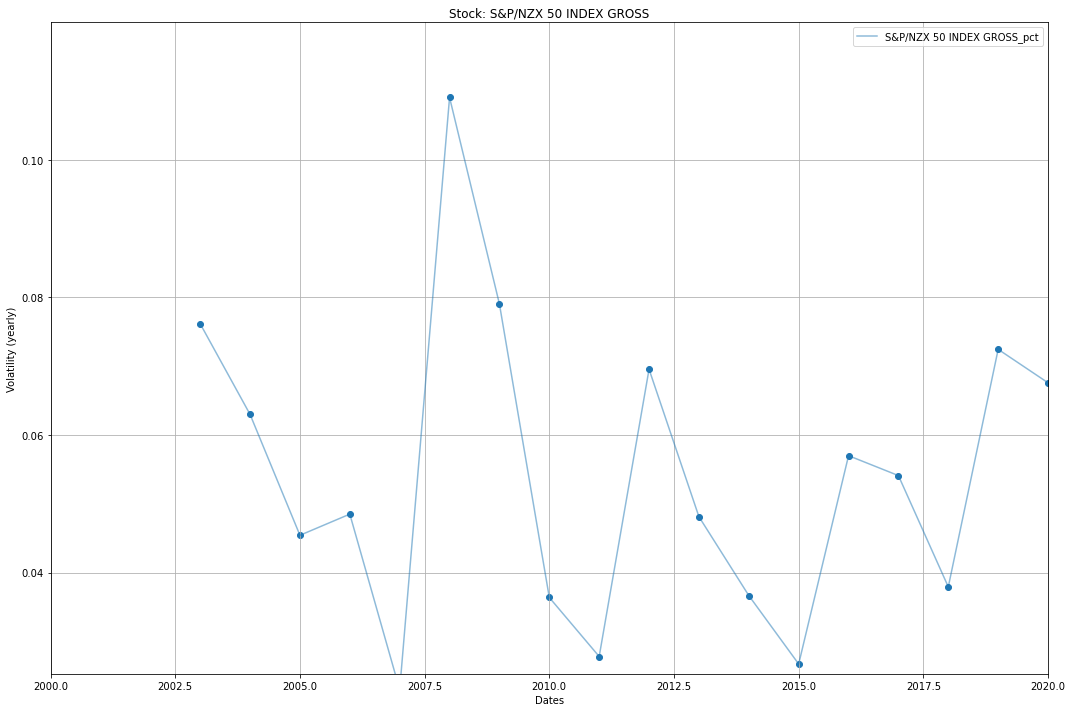

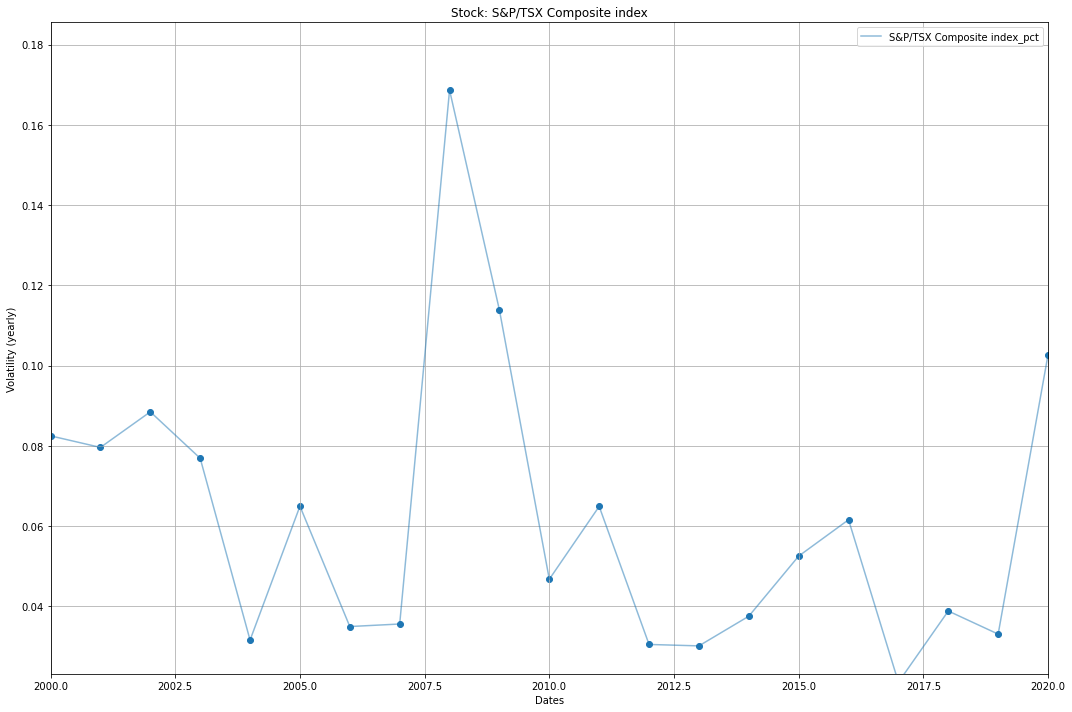

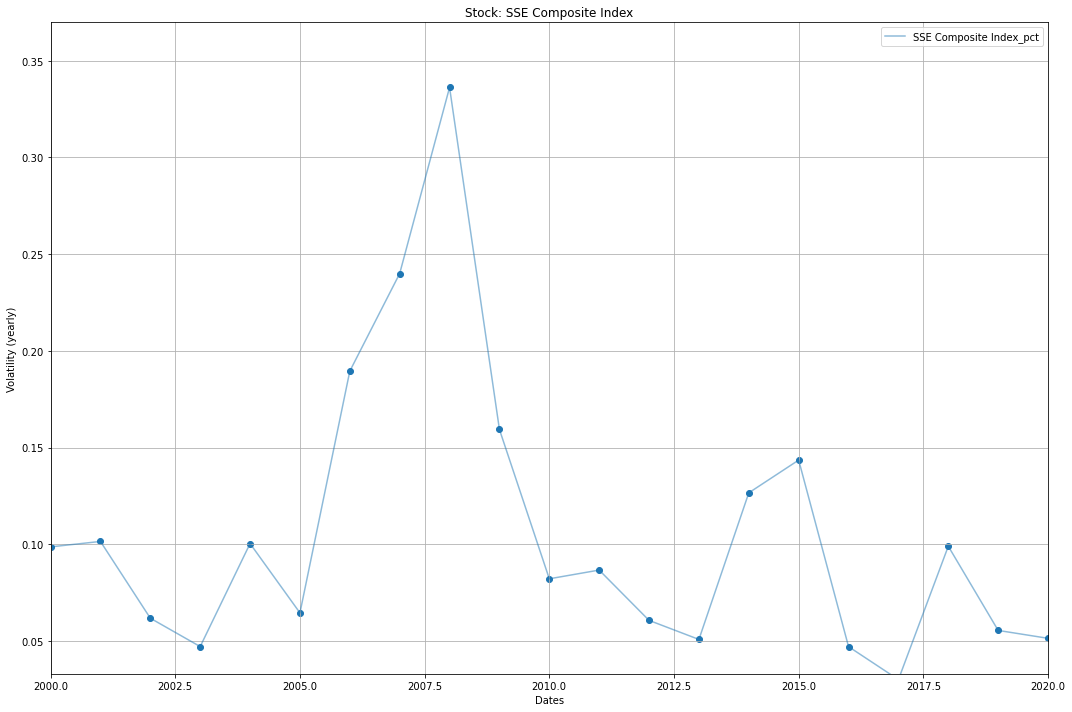

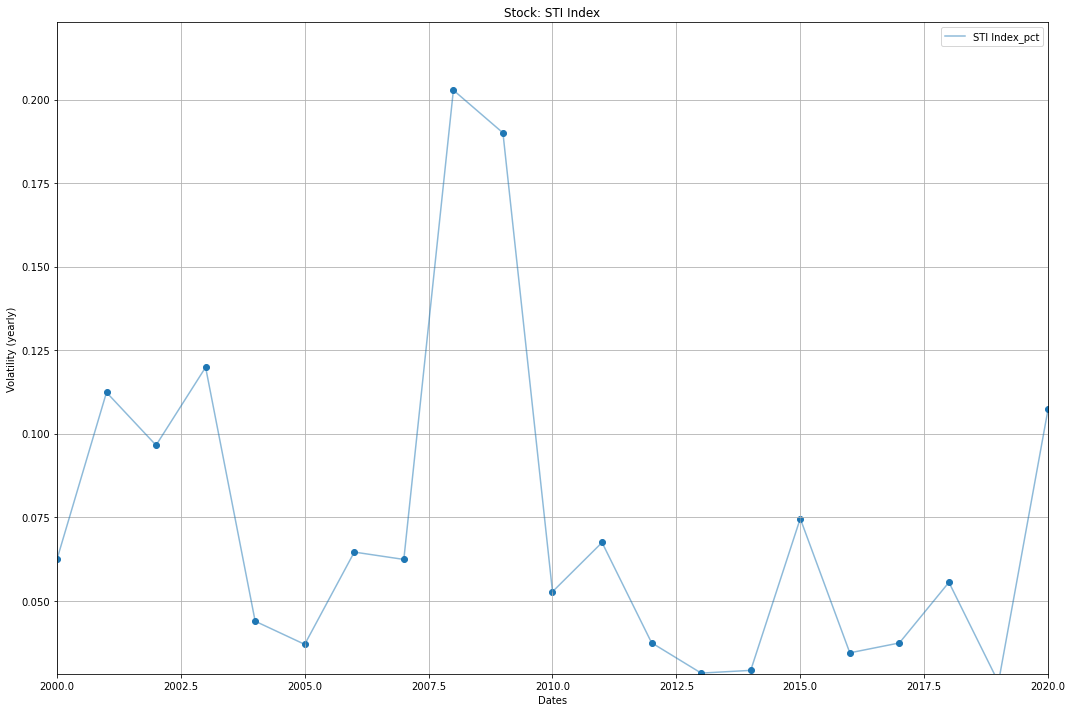

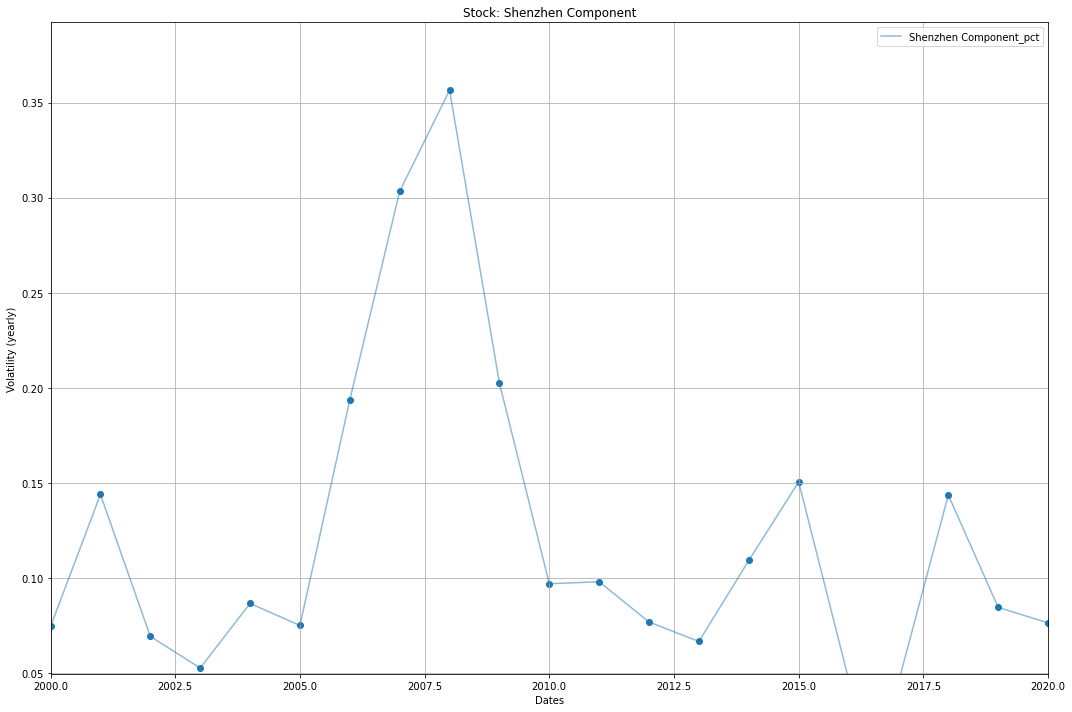

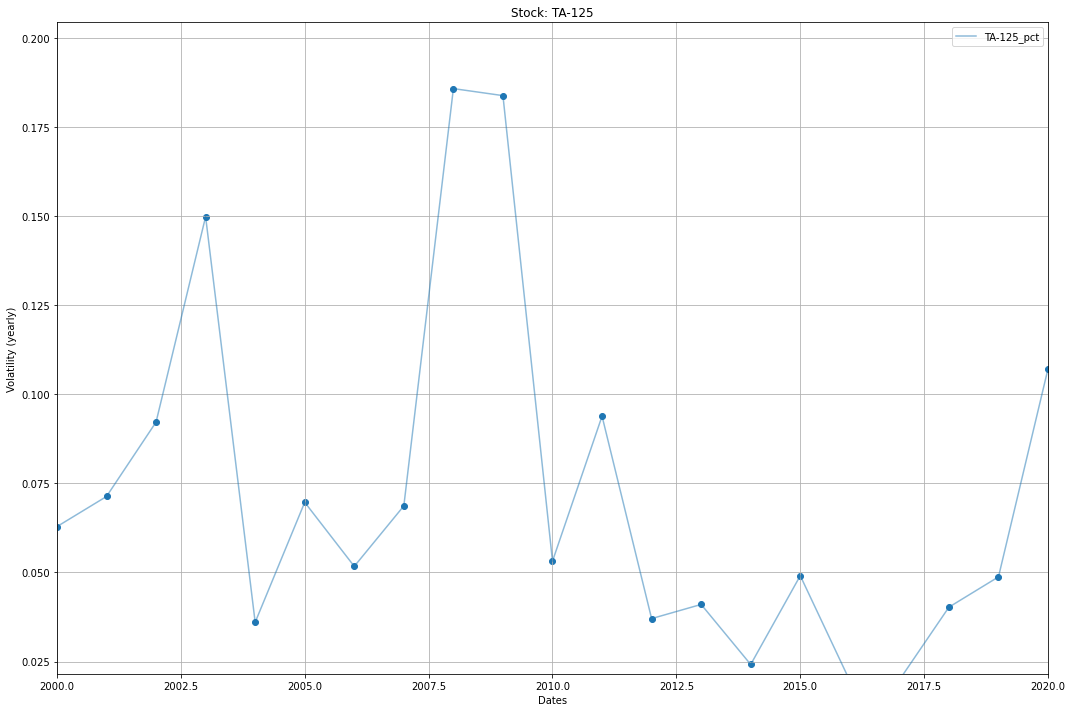

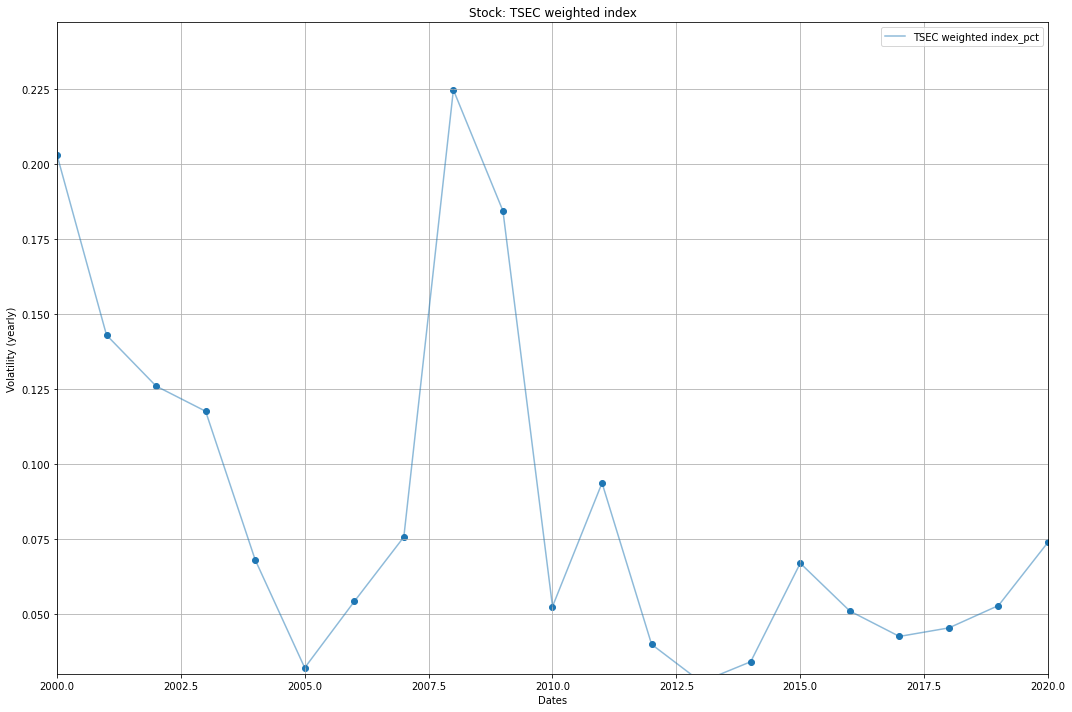

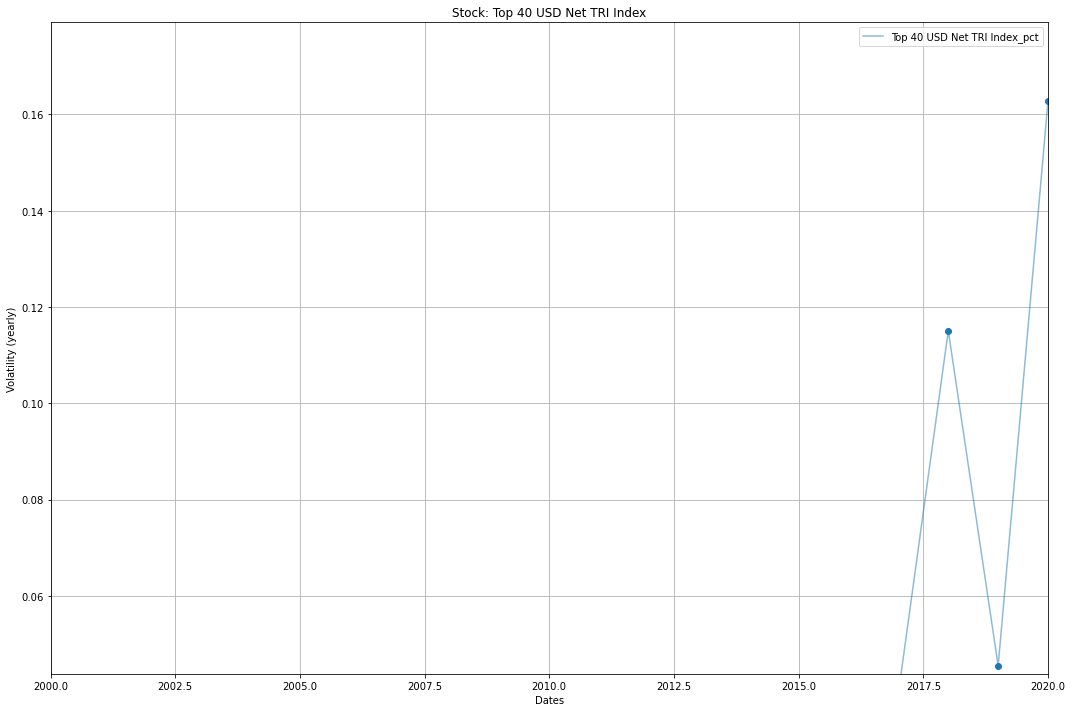

In [201]:
for stock in volatility.columns:
    if stock != 'year':
        plot_volatility(full, stock)

In [221]:
# Candicates with low volatility in the recent past are below
# Pending question: which one has potential/is growing?

n_max = 20
markets = None
for year in range(2018, 2021):
    if markets is None:
        markets = volatility.loc[volatility.year==year
                ].transpose().sort_values('{}-01-01'.format(year)
                ).head(n_max).reset_index()
    else:
        markets = pd.merge(markets, volatility.loc[volatility.year==year
                ].transpose().sort_values('{}-01-01'.format(year)
                ).head(n_max).reset_index(), left_on='index', right_on='index')
        
markets.columns = ['index'] + [year for year in range(2018, 2021)]
markets['index'] = markets['index'].str.replace('_pct', '')
markets

index      2018      2019      2020
0                    Dow 30  0.034009  0.041440  0.102462
1               S&P/ASX 200  0.034979  0.047194  0.120206
2       NYSE COMPOSITE (DJ)  0.036274  0.037488  0.114128
3  FTSE Bursa Malaysia KLCI  0.037857  0.026564  0.065073
4   S&P/TSX Composite index  0.038782  0.033023  0.102697
5                Nikkei 225  0.039424  0.046031  0.095352
6              S&P/CLX IPSA  0.041947  0.027732  0.000000
7                  FTSE 100  0.042425  0.025962  0.118875